## Imports

In [1]:
from __future__ import print_function

import os
import csv
import h5py
import numpy as np
import skimage.io
import argparse
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch.autograd import Variable



#custom libraries
import model_backend.transformers as transforms
from model_backend import progress_bar
from model_backend.create_confusion_matrix import plot_confusion_matrix
from model_backend.create_train_data import CK
from built_models import *

from sklearn.metrics import confusion_matrix

## Data Extraction and Label Creation for CK+ Dataset

### Data Dictionary

Expressions: 0 = anger 1 = disgust, 2 = fear, 3 = happy, 4 = sadness, 5 = surprise, 6 = contempt \
Dataset holds: 135, 177, 75, 207, 84, 249, 54 images for each expression respectively


In [2]:
#this code will create an .h5 file that the model will call upon when searching for inputs
emotions = {'anger' : 'anger_path' , 'disgust' : 'disgust_path', 'fear' : 'fear_path', 
            'happy' : 'happy_path' , 'sadness': 'sadness_path', 'surprise' : 'surprise_path' , 
            'contempt' : 'contempt_path'}

# path to image directory
ck_path = '../data/ck+'


# instantiate lists and counter to store data and label information
data_x = []
data_y = []
count = 0

datapath = os.path.join('../data/ck+','ck_data.h5')
if not os.path.exists(os.path.dirname(datapath)):
    os.makedirs(os.path.dirname(datapath))

for emo_key, emo_val in emotions.items():
    emo_val = os.path.join(ck_path, emo_key)
    
    files = os.listdir(emo_val)
    files.sort()
    
    for filename in files:
        I = skimage.io.imread(os.path.join(emo_val, filename))
        data_x.append(I.tolist())
        data_y.append(count)
    count += 1
    
print(f'The pixel data shape is: {np.shape(data_x)}')
print(f'The label data shape is: {np.shape(data_y)}')  


#save the pixel and labels in .h5 file in the ck+ data folder for the model to call upon
datafile = h5py.File(datapath, 'w')
datafile.create_dataset("data_pixel", dtype = 'uint8', data=data_x)
datafile.create_dataset("data_label", dtype = 'int64', data=data_y)
datafile.close()

print("Oh happy day!, the image data has been compiled without a hitch!")

The pixel data shape is: (981, 48, 48)
The label data shape is: (981,)
Oh happy day!, the image data has been compiled without a hitch!


## Instantiating Command Line Interface Arguements 

In [3]:
parser = argparse.ArgumentParser(description='PyTorch CK+ CNN Training')
parser.add_argument('--model', type=str, default='VGG19', help='CNN architecture')
parser.add_argument('--dataset', type=str, default='CK+', help='dataset')
parser.add_argument('--fold', default=1, type=int, help='k fold number')
parser.add_argument('--bs', default=128, type=int, help='batch_size')
parser.add_argument('--lr', default=0.01, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
print(parser)

ArgumentParser(prog='ipykernel_launcher.py', usage=None, description='PyTorch CK+ CNN Training', formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)


## Training Function Definition

In [4]:
# instantiating global lists to collect data for visualizations
# the lists are the reason I did not load in the functions from a seperate script

train_acc_list_vgg = []
train_loss_list_vgg = []

train_acc_list_rn = []
train_loss_list_rn = []

train_all_pred = []
train_all_targ = []

def train(epoch):
    print('This Is Training Epoch: %d' % epoch )
    global Train_acc
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    all_target = []

    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
        
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = opt.lr * decay_factor
        progress_bar.set_lr(optimizer, current_lr)  # set the decayed rate
        
    else:
        current_lr = opt.lr
   
    print(' ')    
    print('Learning Rate: %s' % str(current_lr))
    print(' ')

    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # apply optimizer
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        # apply crossentropyloss
        loss = criterion(outputs, targets)
        loss.backward()
        progress_bar.clip_gradient(optimizer, 0.1)
        optimizer.step()

        train_loss += loss.item()
        
        # make prediction
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        #draw progress bar
        progress_bar.progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Accuracy: %.3f%% (%d/%d)'
            % (train_loss / (batch_idx + 1), 100. * correct / total, correct, total))
        
        # append predicted and target global lists for visualizations
        if batch_idx == 0:
            train_all_pred.append(predicted)
            train_all_targ.append(targets)
        else:
            train_all_pred.append(torch.cat((train_all_pred[-1], predicted), 0))
            train_all_targ.append(torch.cat((train_all_targ[-1], targets), 0))
        
        print(' ')
        
        # appending accuracy and loss to global list for visualizations
        # not the test data is scaled according to cutsize for visualizations
        for index in range(cut_size):
            
            
            if opt.model == 'VGG19':
                loss_per_run = train_loss / (batch_idx + 1)
                train_loss_list_vgg.append(loss_per_run)

                acc_per_run = 100. * correct / total
                train_acc_list_vgg.append(acc_per_run)


            elif opt.model == 'Resnet18':
                loss_per_run = train_loss / (batch_idx + 1)
                train_loss_list_rn.append(loss_per_run)

                acc_per_run = 100. * correct / total
                train_acc_list_rn.append(acc_per_run)


    Train_acc = 100. * correct / total

## Testing Function Definition

In [5]:
# instantiating global lists to collect data for visualizations
# the lists are the reason I did not load in the functions from a seperate script

test_acc_list_vgg = []
test_loss_list_vgg = []

test_acc_list_rn = []
test_loss_list_rn = []

test_all_pred = []
test_all_targ = []

res_best_test_acc = []
vgg_best_test_acc = []

def test(epoch):
    print('This Is Testing Epoch: %d' % epoch )
    global Test_acc
    global best_Test_acc
    global best_Test_acc_epoch
    net.eval()
    Testing_loss = 0
    correct = 0
    total = 0
    
    
    for batch_idx, (inputs, targets) in enumerate(testloader):
        
        
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # apply optimizer
        optimizer.zero_grad()
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
        
        # apply crossentropyloss
        loss = criterion(outputs_avg, targets)
        Testing_loss += loss.item()
        
        # make prediction
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        #draw progress bar
        progress_bar.progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Accuracy: %.3f%% (%d/%d)'
            % (Testing_loss / (batch_idx + 1), 100. * correct / total, correct, total))
        
        # append predicted and target global lists for visualizations
        if batch_idx == 0:
            test_all_pred.append(predicted)
            test_all_targ.append(targets)
        else:
            test_all_pred.append(torch.cat((test_all_pred[-1], predicted), 0))
            test_all_targ.append(torch.cat((test_all_targ[-1], targets), 0))
        
        # appending accuracy and loss to global list for visualizations
        if opt.model == 'VGG19':
            loss_per_run = Testing_loss / (batch_idx+1)
            test_loss_list_vgg.append(loss_per_run)

            acc_per_run = 100. * correct / total
            test_acc_list_vgg.append(acc_per_run)


        elif opt.model == 'Resnet18':
            loss_per_run = Testing_loss / (batch_idx + 1 )
            test_loss_list_rn.append(loss_per_run)

            acc_per_run = 100.*correct / total
            test_acc_list_rn.append(acc_per_run)

        print(' ')
        
    # Save checkpoint.
    Test_acc = 100. * correct / total

    if Test_acc > best_Test_acc:
        print(' ')
        print('Awesome! Saving This Model..')
        print('Check This Out, The Best Test Accuracy So Far Is: %0.3f' % Test_acc + '%!!')
        state = {'net': net.state_dict() if use_cuda else net,
            'best_Test_acc': Test_acc,
            'best_Test_acc_epoch': epoch,
        }
        
        best_Test_acc = Test_acc
        best_Test_acc_epoch = epoch
        
        if not os.path.isdir('../model_checkpoints/' + opt.dataset + '_' + opt.model):
            os.mkdir('../model_checkpoints/' + opt.dataset + '_' + opt.model)
        if not os.path.isdir('../model_checkpoints/' + path):
            os.mkdir('../model_checkpoints/' + path)
        torch.save(state, os.path.join('../model_checkpoints/' + path, 'emoclass_model.t7'))
        
        
        if opt.model == 'VGG19':
            vgg_best_test_acc.append(best_Test_acc)
        elif opt.model == 'Resnet18':
            res_best_test_acc.append(best_Test_acc)

## Neural Network Parameters

In [6]:

#Epoch choice
total_epoch = 12
start_epoch = 1  # start from epoch 1 or last checkpoint epoch

#Learning Rate Choice by run
learning_rate_decay_start = 0 
learning_rate_decay_every = 1
learning_rate_decay_rate = 0.8 

#basically batch size
cut_size = 43

#this model is built on a cuda PC, so if you have a mac or a non NVIDIA gpu, sorry not sorry.
use_cuda = torch.cuda.is_available()


## Command Line Arguements for VGG19 Convolutional Neural Network Model

In [7]:
print('===> Reading Command Line Arguments')
opt = parser.parse_args('--model VGG19 --bs 128 --lr 0.01 --fold 10'.split())

===> Reading Command Line Arguments


## Data and Transformer Loader

In [8]:
print('===> Loading Data Transformers for Augmentation...')
# define data transformers
transform_train = transforms.Compose([
    transforms.RandomCrop(cut_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

# model loaders use data transformers
print('===> Loading Data For Model...')
trainset = CK(split = 'Training', fold = opt.fold, transform = transform_train)
testset = CK(split = 'Testing', fold = opt.fold, transform = transform_test)

print('===> Preparing Data For Model...')

# Load trainning and testing data and apply parameters
trainloader = torch.utils.data.DataLoader(trainset, batch_size = opt.bs, shuffle = True, num_workers = 0)
testloader = torch.utils.data.DataLoader(testset, batch_size = 8, shuffle = False, num_workers=0)

print('===> Data Ready For Model Execution...')

===> Loading Data Transformers for Augmentation...
===> Loading Data For Model...
 
Train Dataset Samples: 327
 
Test Dataset Samples: 981
 
===> Preparing Data For Model...
===> Data Ready For Model Execution...


## Model Loader and Executor

In [9]:
#Count instantiators
best_Test_acc = 0  
best_Test_acc_epoch = 0

print('===> Loading Model Executor...')

# where to save best model
path = os.path.join( opt.dataset + '_' + opt.model)

# Load model
if opt.model == 'VGG19':
    net = VGG('VGG19')


# resume from best model if not started    
if opt.resume:
    # Load checkpoint.
    print('===> Continuing From Checkpoint...')
    assert os.path.isdir(path), 'ERROR: NO CHECKPOINT DIRECTORY FOUND!!!!'
    checkpoint = torch.load(os.path.join('../model_checkpoints/' + path,'emoclass_model.t7'))
    
    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
    
else:
    print(' ')
    print('===> Building Model...')
    print(' ')

# initialize cuda!! Note, this is not an option it is a requirement.    
if use_cuda == True:
    net.cuda()

print('===> Preparing Optimizers For Model...')

# initialize loss and optimizer functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = opt.lr, momentum = 0.9, weight_decay = 5e-4)

print(' ')
print('===> Running Model...')
print(' ')

# start trainning and testing
for epoch in range(start_epoch, total_epoch + 1):
    train(epoch)
    print(' ')
    print('Epoch Trainning Done.')
    print(' ')
    test(epoch)
    print(' ')
    print('Epoch Testing Done')
    print(' ')
    
print('===> Calculating Confusion Matrix For Model...')
# Compute confusion matrix
vgg_matrix = confusion_matrix(test_all_targ[-1].data.cpu().numpy(), test_all_pred[-1].cpu().numpy())

# append for visualization in case no other appends have been made
if opt.model == 'VGG19':
    vgg_best_test_acc.append(best_Test_acc)
    
print("===> Best Test Accuracy: %0.3f" % best_Test_acc)
print("===> Best Test Accuracy Occured on Epoch: %d" % best_Test_acc_epoch)

# delete cuda memory cache to prevent memory errors
print('===> Clearing CUDA Memory Cache...')
del trainloader
torch.cuda.empty_cache()
del testloader
torch.cuda.empty_cache() 

print('===> Model Execution Complete...')

===> Loading Model Executor...
 
===> Building Model...
 
===> Preparing Optimizers For Model...
 
===> Running Model...
 
This Is Training Epoch: 1
 
Learning Rate: 0.008
 
 [>.............................] | Loss: 2.729 | Accuracy: 5.469% (7/128)      | Run 1 of 13 
 [==>...........................] | Loss: 2.412 | Accuracy: 11.328% (29/256)    | Run 2 of 13 
 [====>.........................] | Loss: 2.296 | Accuracy: 15.365% (59/384)    | Run 3 of 13 
 [======>.......................] | Loss: 2.267 | Accuracy: 16.797% (86/512)    | Run 4 of 13 
 [=========>....................] | Loss: 2.214 | Accuracy: 18.750% (120/640)   | Run 5 of 13 
 [===========>..................] | Loss: 2.158 | Accuracy: 20.964% (161/768)   | Run 6 of 13 
 [=============>................] | Loss: 2.129 | Accuracy: 22.321% (200/896)   | Run 7 of 13 
 [================>.............] | Loss: 2.118 | Accuracy: 23.438% (240/1024)  | Run 8 of 13 
 [==================>...........] | Loss: 2.060 | Accuracy: 25.347

 [===>..........................] | Loss: 1.970 | Accuracy: 24.107% (135/560)   | Run 70 of 614 
 [===>..........................] | Loss: 1.972 | Accuracy: 23.768% (135/568)   | Run 71 of 614 
 [===>..........................] | Loss: 1.974 | Accuracy: 23.438% (135/576)   | Run 72 of 614 
 [===>..........................] | Loss: 1.975 | Accuracy: 23.116% (135/584)   | Run 73 of 614 
 [===>..........................] | Loss: 1.977 | Accuracy: 22.804% (135/592)   | Run 74 of 614 
 [===>..........................] | Loss: 1.976 | Accuracy: 22.500% (135/600)   | Run 75 of 614 
 [===>..........................] | Loss: 1.974 | Accuracy: 22.204% (135/608)   | Run 76 of 614 
 [===>..........................] | Loss: 1.973 | Accuracy: 21.916% (135/616)   | Run 77 of 614 
 [===>..........................] | Loss: 1.971 | Accuracy: 21.635% (135/624)   | Run 78 of 614 
 [===>..........................] | Loss: 1.969 | Accuracy: 21.361% (135/632)   | Run 79 of 614 
 [===>........................

 [=======>......................] | Loss: 1.983 | Accuracy: 22.059% (270/1224)  | Run 153 of 614 
 [=======>......................] | Loss: 1.982 | Accuracy: 21.916% (270/1232)  | Run 154 of 614 
 [=======>......................] | Loss: 1.982 | Accuracy: 21.774% (270/1240)  | Run 155 of 614 
 [=======>......................] | Loss: 1.982 | Accuracy: 21.635% (270/1248)  | Run 156 of 614 
 [=======>......................] | Loss: 1.982 | Accuracy: 21.497% (270/1256)  | Run 157 of 614 
 [=======>......................] | Loss: 1.981 | Accuracy: 21.361% (270/1264)  | Run 158 of 614 
 [=======>......................] | Loss: 1.981 | Accuracy: 21.226% (270/1272)  | Run 159 of 614 
 [=======>......................] | Loss: 1.981 | Accuracy: 21.094% (270/1280)  | Run 160 of 614 
 [=======>......................] | Loss: 1.981 | Accuracy: 20.963% (270/1288)  | Run 161 of 614 
 [=======>......................] | Loss: 1.981 | Accuracy: 20.833% (270/1296)  | Run 162 of 614 
 [=======>..........

 [===========>..................] | Loss: 2.035 | Accuracy: 14.301% (270/1888)  | Run 236 of 614 
 [===========>..................] | Loss: 2.036 | Accuracy: 14.241% (270/1896)  | Run 237 of 614 
 [===========>..................] | Loss: 2.037 | Accuracy: 14.181% (270/1904)  | Run 238 of 614 
 [===========>..................] | Loss: 2.037 | Accuracy: 14.121% (270/1912)  | Run 239 of 614 
 [===========>..................] | Loss: 2.035 | Accuracy: 14.062% (270/1920)  | Run 240 of 614 
 [===========>..................] | Loss: 2.034 | Accuracy: 14.004% (270/1928)  | Run 241 of 614 
 [===========>..................] | Loss: 2.033 | Accuracy: 13.946% (270/1936)  | Run 242 of 614 
 [===========>..................] | Loss: 2.031 | Accuracy: 13.889% (270/1944)  | Run 243 of 614 
 [===========>..................] | Loss: 2.030 | Accuracy: 13.832% (270/1952)  | Run 244 of 614 
 [===========>..................] | Loss: 2.029 | Accuracy: 13.776% (270/1960)  | Run 245 of 614 
 [===========>......

 [===============>..............] | Loss: 2.016 | Accuracy: 15.870% (405/2552)  | Run 319 of 614 
 [===============>..............] | Loss: 2.016 | Accuracy: 15.820% (405/2560)  | Run 320 of 614 
 [===============>..............] | Loss: 2.016 | Accuracy: 15.771% (405/2568)  | Run 321 of 614 
 [===============>..............] | Loss: 2.015 | Accuracy: 15.722% (405/2576)  | Run 322 of 614 
 [===============>..............] | Loss: 2.015 | Accuracy: 15.673% (405/2584)  | Run 323 of 614 
 [===============>..............] | Loss: 2.014 | Accuracy: 15.625% (405/2592)  | Run 324 of 614 
 [===============>..............] | Loss: 2.013 | Accuracy: 15.577% (405/2600)  | Run 325 of 614 
 [===============>..............] | Loss: 2.013 | Accuracy: 15.529% (405/2608)  | Run 326 of 614 
 [===============>..............] | Loss: 2.012 | Accuracy: 15.482% (405/2616)  | Run 327 of 614 
 [===============>..............] | Loss: 2.012 | Accuracy: 15.434% (405/2624)  | Run 328 of 614 
 [================>.

 [===================>..........] | Loss: 2.010 | Accuracy: 16.791% (540/3216)  | Run 402 of 614 
 [===================>..........] | Loss: 2.010 | Accuracy: 16.749% (540/3224)  | Run 403 of 614 
 [===================>..........] | Loss: 2.010 | Accuracy: 16.708% (540/3232)  | Run 404 of 614 
 [===================>..........] | Loss: 2.010 | Accuracy: 16.667% (540/3240)  | Run 405 of 614 
 [===================>..........] | Loss: 2.009 | Accuracy: 16.626% (540/3248)  | Run 406 of 614 
 [===================>..........] | Loss: 2.009 | Accuracy: 16.585% (540/3256)  | Run 407 of 614 
 [===================>..........] | Loss: 2.010 | Accuracy: 16.544% (540/3264)  | Run 408 of 614 
 [===================>..........] | Loss: 2.010 | Accuracy: 16.504% (540/3272)  | Run 409 of 614 
 [===================>..........] | Loss: 2.011 | Accuracy: 16.463% (540/3280)  | Run 410 of 614 
 [====================>.........] | Loss: 2.012 | Accuracy: 16.423% (540/3288)  | Run 411 of 614 
 [==================

 [=======================>......] | Loss: 2.032 | Accuracy: 13.918% (540/3880)  | Run 485 of 614 
 [=======================>......] | Loss: 2.031 | Accuracy: 13.889% (540/3888)  | Run 486 of 614 
 [=======================>......] | Loss: 2.031 | Accuracy: 13.860% (540/3896)  | Run 487 of 614 
 [=======================>......] | Loss: 2.030 | Accuracy: 13.832% (540/3904)  | Run 488 of 614 
 [=======================>......] | Loss: 2.029 | Accuracy: 13.804% (540/3912)  | Run 489 of 614 
 [=======================>......] | Loss: 2.029 | Accuracy: 13.776% (540/3920)  | Run 490 of 614 
 [=======================>......] | Loss: 2.028 | Accuracy: 13.849% (544/3928)  | Run 491 of 614 
 [=======================>......] | Loss: 2.027 | Accuracy: 14.024% (552/3936)  | Run 492 of 614 
 [========================>.....] | Loss: 2.027 | Accuracy: 14.199% (560/3944)  | Run 493 of 614 
 [========================>.....] | Loss: 2.026 | Accuracy: 14.372% (568/3952)  | Run 494 of 614 
 [==================

 [===========================>..] | Loss: 2.021 | Accuracy: 14.855% (675/4544)  | Run 568 of 614 
 [===========================>..] | Loss: 2.020 | Accuracy: 14.829% (675/4552)  | Run 569 of 614 
 [===========================>..] | Loss: 2.020 | Accuracy: 14.803% (675/4560)  | Run 570 of 614 
 [===========================>..] | Loss: 2.020 | Accuracy: 14.777% (675/4568)  | Run 571 of 614 
 [===========================>..] | Loss: 2.019 | Accuracy: 14.751% (675/4576)  | Run 572 of 614 
 [===========================>..] | Loss: 2.019 | Accuracy: 14.725% (675/4584)  | Run 573 of 614 
 [===========================>..] | Loss: 2.019 | Accuracy: 14.699% (675/4592)  | Run 574 of 614 
 [============================>.] | Loss: 2.018 | Accuracy: 14.674% (675/4600)  | Run 575 of 614 
 [============================>.] | Loss: 2.019 | Accuracy: 14.648% (675/4608)  | Run 576 of 614 
 [============================>.] | Loss: 2.019 | Accuracy: 14.623% (675/4616)  | Run 577 of 614 
 [==================

 [=>............................] | Loss: 1.651 | Accuracy: 0.000% (0/176)      | Run 22 of 614 
 [=>............................] | Loss: 1.681 | Accuracy: 0.000% (0/184)      | Run 23 of 614 
 [=>............................] | Loss: 1.709 | Accuracy: 0.000% (0/192)      | Run 24 of 614 
 [=>............................] | Loss: 1.735 | Accuracy: 0.000% (0/200)      | Run 25 of 614 
 [=>............................] | Loss: 1.759 | Accuracy: 0.000% (0/208)      | Run 26 of 614 
 [=>............................] | Loss: 1.781 | Accuracy: 0.000% (0/216)      | Run 27 of 614 
 [=>............................] | Loss: 1.801 | Accuracy: 0.000% (0/224)      | Run 28 of 614 
 [=>............................] | Loss: 1.820 | Accuracy: 0.000% (0/232)      | Run 29 of 614 
 [=>............................] | Loss: 1.838 | Accuracy: 0.000% (0/240)      | Run 30 of 614 
 [=>............................] | Loss: 1.855 | Accuracy: 0.000% (0/248)      | Run 31 of 614 
 [=>..........................

 [=====>........................] | Loss: 2.514 | Accuracy: 0.000% (0/848)      | Run 106 of 614 
 [=====>........................] | Loss: 2.526 | Accuracy: 0.000% (0/856)      | Run 107 of 614 
 [=====>........................] | Loss: 2.537 | Accuracy: 0.000% (0/864)      | Run 108 of 614 
 [=====>........................] | Loss: 2.548 | Accuracy: 0.000% (0/872)      | Run 109 of 614 
 [=====>........................] | Loss: 2.559 | Accuracy: 0.000% (0/880)      | Run 110 of 614 
 [=====>........................] | Loss: 2.570 | Accuracy: 0.000% (0/888)      | Run 111 of 614 
 [=====>........................] | Loss: 2.581 | Accuracy: 0.000% (0/896)      | Run 112 of 614 
 [=====>........................] | Loss: 2.591 | Accuracy: 0.000% (0/904)      | Run 113 of 614 
 [=====>........................] | Loss: 2.601 | Accuracy: 0.000% (0/912)      | Run 114 of 614 
 [=====>........................] | Loss: 2.611 | Accuracy: 0.000% (0/920)      | Run 115 of 614 
 [=====>............

 [=========>....................] | Loss: 2.425 | Accuracy: 3.571% (54/1512)    | Run 189 of 614 
 [=========>....................] | Loss: 2.426 | Accuracy: 3.553% (54/1520)    | Run 190 of 614 
 [=========>....................] | Loss: 2.427 | Accuracy: 3.534% (54/1528)    | Run 191 of 614 
 [=========>....................] | Loss: 2.429 | Accuracy: 3.516% (54/1536)    | Run 192 of 614 
 [=========>....................] | Loss: 2.430 | Accuracy: 3.497% (54/1544)    | Run 193 of 614 
 [=========>....................] | Loss: 2.431 | Accuracy: 3.479% (54/1552)    | Run 194 of 614 
 [=========>....................] | Loss: 2.433 | Accuracy: 3.462% (54/1560)    | Run 195 of 614 
 [=========>....................] | Loss: 2.434 | Accuracy: 3.444% (54/1568)    | Run 196 of 614 
 [=========>....................] | Loss: 2.435 | Accuracy: 3.426% (54/1576)    | Run 197 of 614 
 [=========>....................] | Loss: 2.431 | Accuracy: 3.409% (54/1584)    | Run 198 of 614 
 [=========>........

 [=============>................] | Loss: 2.464 | Accuracy: 4.963% (108/2176)   | Run 272 of 614 
 [=============>................] | Loss: 2.464 | Accuracy: 4.945% (108/2184)   | Run 273 of 614 
 [=============>................] | Loss: 2.464 | Accuracy: 4.927% (108/2192)   | Run 274 of 614 
 [=============>................] | Loss: 2.463 | Accuracy: 4.909% (108/2200)   | Run 275 of 614 
 [=============>................] | Loss: 2.463 | Accuracy: 4.891% (108/2208)   | Run 276 of 614 
 [=============>................] | Loss: 2.462 | Accuracy: 4.874% (108/2216)   | Run 277 of 614 
 [=============>................] | Loss: 2.462 | Accuracy: 4.856% (108/2224)   | Run 278 of 614 
 [=============>................] | Loss: 2.462 | Accuracy: 4.839% (108/2232)   | Run 279 of 614 
 [=============>................] | Loss: 2.461 | Accuracy: 4.821% (108/2240)   | Run 280 of 614 
 [=============>................] | Loss: 2.461 | Accuracy: 4.804% (108/2248)   | Run 281 of 614 
 [=============>....

 [=================>............] | Loss: 2.545 | Accuracy: 3.803% (108/2840)   | Run 355 of 614 
 [=================>............] | Loss: 2.548 | Accuracy: 3.792% (108/2848)   | Run 356 of 614 
 [=================>............] | Loss: 2.552 | Accuracy: 3.782% (108/2856)   | Run 357 of 614 
 [=================>............] | Loss: 2.555 | Accuracy: 3.771% (108/2864)   | Run 358 of 614 
 [=================>............] | Loss: 2.558 | Accuracy: 3.760% (108/2872)   | Run 359 of 614 
 [=================>............] | Loss: 2.562 | Accuracy: 3.750% (108/2880)   | Run 360 of 614 
 [=================>............] | Loss: 2.565 | Accuracy: 3.740% (108/2888)   | Run 361 of 614 
 [=================>............] | Loss: 2.562 | Accuracy: 3.971% (115/2896)   | Run 362 of 614 
 [=================>............] | Loss: 2.558 | Accuracy: 4.236% (123/2904)   | Run 363 of 614 
 [=================>............] | Loss: 2.554 | Accuracy: 4.499% (131/2912)   | Run 364 of 614 
 [=================>

 [=====================>........] | Loss: 2.491 | Accuracy: 4.623% (162/3504)   | Run 438 of 614 
 [=====================>........] | Loss: 2.492 | Accuracy: 4.613% (162/3512)   | Run 439 of 614 
 [=====================>........] | Loss: 2.492 | Accuracy: 4.602% (162/3520)   | Run 440 of 614 
 [=====================>........] | Loss: 2.492 | Accuracy: 4.592% (162/3528)   | Run 441 of 614 
 [=====================>........] | Loss: 2.493 | Accuracy: 4.581% (162/3536)   | Run 442 of 614 
 [=====================>........] | Loss: 2.492 | Accuracy: 4.571% (162/3544)   | Run 443 of 614 
 [=====================>........] | Loss: 2.490 | Accuracy: 4.561% (162/3552)   | Run 444 of 614 
 [=====================>........] | Loss: 2.488 | Accuracy: 4.551% (162/3560)   | Run 445 of 614 
 [=====================>........] | Loss: 2.487 | Accuracy: 4.540% (162/3568)   | Run 446 of 614 
 [=====================>........] | Loss: 2.485 | Accuracy: 4.530% (162/3576)   | Run 447 of 614 
 [==================

 [=========================>....] | Loss: 2.499 | Accuracy: 5.182% (216/4168)   | Run 521 of 614 
 [=========================>....] | Loss: 2.499 | Accuracy: 5.172% (216/4176)   | Run 522 of 614 
 [=========================>....] | Loss: 2.498 | Accuracy: 5.163% (216/4184)   | Run 523 of 614 
 [=========================>....] | Loss: 2.498 | Accuracy: 5.153% (216/4192)   | Run 524 of 614 
 [=========================>....] | Loss: 2.498 | Accuracy: 5.143% (216/4200)   | Run 525 of 614 
 [=========================>....] | Loss: 2.498 | Accuracy: 5.133% (216/4208)   | Run 526 of 614 
 [=========================>....] | Loss: 2.497 | Accuracy: 5.123% (216/4216)   | Run 527 of 614 
 [=========================>....] | Loss: 2.497 | Accuracy: 5.114% (216/4224)   | Run 528 of 614 
 [=========================>....] | Loss: 2.497 | Accuracy: 5.104% (216/4232)   | Run 529 of 614 
 [=========================>....] | Loss: 2.496 | Accuracy: 5.094% (216/4240)   | Run 530 of 614 
 [==================

 [=============================>] | Loss: 2.550 | Accuracy: 4.470% (216/4832)   | Run 604 of 614 
 [=============================>] | Loss: 2.552 | Accuracy: 4.463% (216/4840)   | Run 605 of 614 
 [=============================>] | Loss: 2.554 | Accuracy: 4.455% (216/4848)   | Run 606 of 614 
 [=============================>] | Loss: 2.553 | Accuracy: 4.551% (221/4856)   | Run 607 of 614 
 [=============================>] | Loss: 2.551 | Accuracy: 4.708% (229/4864) | Run 608 of 614 
 [=============================>] | Loss: 2.549 | Accuracy: 4.865% (237/4872)   | Run 609 of 614 
 [=============================>] | Loss: 2.547 | Accuracy: 5.020% (245/4880)   | Run 610 of 614 
 [=============================>] | Loss: 2.544 | Accuracy: 5.176% (253/4888)   | Run 611 of 614 
 [=============================>] | Loss: 2.542 | Accuracy: 5.331% (261/4896)   | Run 612 of 614 
 [=============================>] | Loss: 2.540 | Accuracy: 5.485% (269/4904)   | Run 613 of 614 
 [====================

 [==>...........................] | Loss: 2.537 | Accuracy: 0.417% (2/480)      | Run 60 of 614 
 [==>...........................] | Loss: 2.560 | Accuracy: 0.410% (2/488)      | Run 61 of 614 
 [==>...........................] | Loss: 2.577 | Accuracy: 0.403% (2/496)      | Run 62 of 614 
 [===>..........................] | Loss: 2.592 | Accuracy: 0.397% (2/504)      | Run 63 of 614 
 [===>..........................] | Loss: 2.599 | Accuracy: 0.391% (2/512)      | Run 64 of 614 
 [===>..........................] | Loss: 2.605 | Accuracy: 0.385% (2/520)      | Run 65 of 614 
 [===>..........................] | Loss: 2.623 | Accuracy: 0.379% (2/528)      | Run 66 of 614 
 [===>..........................] | Loss: 2.641 | Accuracy: 0.373% (2/536)      | Run 67 of 614 
 [===>..........................] | Loss: 2.654 | Accuracy: 0.368% (2/544)      | Run 68 of 614 
 [===>..........................] | Loss: 2.670 | Accuracy: 0.362% (2/552)      | Run 69 of 614 
 [===>........................

 [======>.......................] | Loss: 2.747 | Accuracy: 5.990% (69/1152)    | Run 144 of 614 
 [=======>......................] | Loss: 2.743 | Accuracy: 5.948% (69/1160)    | Run 145 of 614 
 [=======>......................] | Loss: 2.741 | Accuracy: 5.908% (69/1168)    | Run 146 of 614 
 [=======>......................] | Loss: 2.739 | Accuracy: 5.867% (69/1176)    | Run 147 of 614 
 [=======>......................] | Loss: 2.738 | Accuracy: 5.828% (69/1184)    | Run 148 of 614 
 [=======>......................] | Loss: 2.737 | Accuracy: 5.789% (69/1192)    | Run 149 of 614 
 [=======>......................] | Loss: 2.735 | Accuracy: 5.750% (69/1200)    | Run 150 of 614 
 [=======>......................] | Loss: 2.734 | Accuracy: 5.712% (69/1208)    | Run 151 of 614 
 [=======>......................] | Loss: 2.733 | Accuracy: 5.674% (69/1216)    | Run 152 of 614 
 [=======>......................] | Loss: 2.730 | Accuracy: 5.637% (69/1224)    | Run 153 of 614 
 [=======>..........

 [===========>..................] | Loss: 2.892 | Accuracy: 4.295% (78/1816)    | Run 227 of 614 
 [===========>..................] | Loss: 2.894 | Accuracy: 4.276% (78/1824)    | Run 228 of 614 
 [===========>..................] | Loss: 2.899 | Accuracy: 4.258% (78/1832)    | Run 229 of 614 
 [===========>..................] | Loss: 2.898 | Accuracy: 4.402% (81/1840)    | Run 230 of 614 
 [===========>..................] | Loss: 2.905 | Accuracy: 4.383% (81/1848)    | Run 231 of 614 
 [===========>..................] | Loss: 2.911 | Accuracy: 4.364% (81/1856)    | Run 232 of 614 
 [===========>..................] | Loss: 2.916 | Accuracy: 4.345% (81/1864)    | Run 233 of 614 
 [===========>..................] | Loss: 2.925 | Accuracy: 4.327% (81/1872)    | Run 234 of 614 
 [===========>..................] | Loss: 2.930 | Accuracy: 4.309% (81/1880)    | Run 235 of 614 
 [===========>..................] | Loss: 2.935 | Accuracy: 4.290% (81/1888)    | Run 236 of 614 
 [===========>......

 [===============>..............] | Loss: 2.817 | Accuracy: 5.645% (140/2480)   | Run 310 of 614 
 [===============>..............] | Loss: 2.820 | Accuracy: 5.627% (140/2488)   | Run 311 of 614 
 [===============>..............] | Loss: 2.823 | Accuracy: 5.609% (140/2496)   | Run 312 of 614 
 [===============>..............] | Loss: 2.825 | Accuracy: 5.591% (140/2504)   | Run 313 of 614 
 [===============>..............] | Loss: 2.828 | Accuracy: 5.573% (140/2512)   | Run 314 of 614 
 [===============>..............] | Loss: 2.830 | Accuracy: 5.556% (140/2520)   | Run 315 of 614 
 [===============>..............] | Loss: 2.833 | Accuracy: 5.538% (140/2528)   | Run 316 of 614 
 [===============>..............] | Loss: 2.836 | Accuracy: 5.521% (140/2536)   | Run 317 of 614 
 [===============>..............] | Loss: 2.839 | Accuracy: 5.503% (140/2544)   | Run 318 of 614 
 [===============>..............] | Loss: 2.842 | Accuracy: 5.486% (140/2552)   | Run 319 of 614 
 [===============>..

 [===================>..........] | Loss: 2.823 | Accuracy: 6.584% (207/3144) | Run 393 of 614 
 [===================>..........] | Loss: 2.822 | Accuracy: 6.567% (207/3152)   | Run 394 of 614 
 [===================>..........] | Loss: 2.821 | Accuracy: 6.551% (207/3160)   | Run 395 of 614 
 [===================>..........] | Loss: 2.820 | Accuracy: 6.534% (207/3168)   | Run 396 of 614 
 [===================>..........] | Loss: 2.820 | Accuracy: 6.518% (207/3176)   | Run 397 of 614 
 [===================>..........] | Loss: 2.819 | Accuracy: 6.501% (207/3184)   | Run 398 of 614 
 [===================>..........] | Loss: 2.819 | Accuracy: 6.485% (207/3192)   | Run 399 of 614 
 [===================>..........] | Loss: 2.817 | Accuracy: 6.469% (207/3200)   | Run 400 of 614 
 [===================>..........] | Loss: 2.817 | Accuracy: 6.453% (207/3208)   | Run 401 of 614 
 [===================>..........] | Loss: 2.816 | Accuracy: 6.437% (207/3216)   | Run 402 of 614 
 [===================>

 [=======================>......] | Loss: 2.888 | Accuracy: 5.751% (219/3808)   | Run 476 of 614 
 [=======================>......] | Loss: 2.891 | Accuracy: 5.739% (219/3816)   | Run 477 of 614 
 [=======================>......] | Loss: 2.894 | Accuracy: 5.727% (219/3824)   | Run 478 of 614 
 [=======================>......] | Loss: 2.898 | Accuracy: 5.715% (219/3832)   | Run 479 of 614 
 [=======================>......] | Loss: 2.900 | Accuracy: 5.703% (219/3840)   | Run 480 of 614 
 [=======================>......] | Loss: 2.903 | Accuracy: 5.691% (219/3848)   | Run 481 of 614 
 [=======================>......] | Loss: 2.907 | Accuracy: 5.679% (219/3856)   | Run 482 of 614 
 [=======================>......] | Loss: 2.907 | Accuracy: 5.745% (222/3864)   | Run 483 of 614 
 [=======================>......] | Loss: 2.905 | Accuracy: 5.785% (224/3872)   | Run 484 of 614 
 [=======================>......] | Loss: 2.900 | Accuracy: 5.979% (232/3880)   | Run 485 of 614 
 [==================

 [===========================>..] | Loss: 2.848 | Accuracy: 6.216% (278/4472)   | Run 559 of 614 
 [===========================>..] | Loss: 2.849 | Accuracy: 6.205% (278/4480)   | Run 560 of 614 
 [===========================>..] | Loss: 2.850 | Accuracy: 6.194% (278/4488)   | Run 561 of 614 
 [===========================>..] | Loss: 2.852 | Accuracy: 6.183% (278/4496)   | Run 562 of 614 
 [===========================>..] | Loss: 2.854 | Accuracy: 6.172% (278/4504)   | Run 563 of 614 
 [===========================>..] | Loss: 2.855 | Accuracy: 6.161% (278/4512)   | Run 564 of 614 
 [===========================>..] | Loss: 2.856 | Accuracy: 6.150% (278/4520)   | Run 565 of 614 
 [===========================>..] | Loss: 2.856 | Accuracy: 6.140% (278/4528)   | Run 566 of 614 
 [===========================>..] | Loss: 2.855 | Accuracy: 6.129% (278/4536)   | Run 567 of 614 
 [===========================>..] | Loss: 2.854 | Accuracy: 6.118% (278/4544)   | Run 568 of 614 
 [==================

 [>.............................] | Loss: 1.011 | Accuracy: 61.607% (69/112)    | Run 14 of 614 
 [>.............................] | Loss: 1.004 | Accuracy: 63.333% (76/120)    | Run 15 of 614 
 [>.............................] | Loss: 1.001 | Accuracy: 63.281% (81/128)    | Run 16 of 614 
 [>.............................] | Loss: 0.983 | Accuracy: 64.706% (88/136)    | Run 17 of 614 
 [>.............................] | Loss: 0.965 | Accuracy: 63.889% (92/144)    | Run 18 of 614 
 [>.............................] | Loss: 0.959 | Accuracy: 62.500% (95/152)    | Run 19 of 614 
 [>.............................] | Loss: 0.966 | Accuracy: 61.875% (99/160)    | Run 20 of 614 
 [>.............................] | Loss: 0.938 | Accuracy: 62.500% (105/168)   | Run 21 of 614 
 [=>............................] | Loss: 0.905 | Accuracy: 64.205% (113/176)   | Run 22 of 614 
 [=>............................] | Loss: 0.935 | Accuracy: 62.500% (115/184)   | Run 23 of 614 
 [=>..........................

 [====>.........................] | Loss: 0.940 | Accuracy: 60.459% (474/784)   | Run 98 of 614 
 [====>.........................] | Loss: 0.950 | Accuracy: 59.848% (474/792)   | Run 99 of 614 
 [====>.........................] | Loss: 0.948 | Accuracy: 60.000% (480/800)   | Run 100 of 614 
 [====>.........................] | Loss: 0.963 | Accuracy: 59.530% (481/808)   | Run 101 of 614 
 [====>.........................] | Loss: 0.953 | Accuracy: 59.926% (489/816)   | Run 102 of 614 
 [====>.........................] | Loss: 0.945 | Accuracy: 60.316% (497/824)   | Run 103 of 614 
 [=====>........................] | Loss: 0.937 | Accuracy: 60.697% (505/832)   | Run 104 of 614 
 [=====>........................] | Loss: 0.929 | Accuracy: 61.071% (513/840)   | Run 105 of 614 
 [=====>........................] | Loss: 0.929 | Accuracy: 61.085% (518/848)   | Run 106 of 614 
 [=====>........................] | Loss: 0.925 | Accuracy: 61.215% (524/856)   | Run 107 of 614 
 [=====>..............

 [========>.....................] | Loss: 0.923 | Accuracy: 61.878% (896/1448)  | Run 181 of 614 
 [========>.....................] | Loss: 0.924 | Accuracy: 61.745% (899/1456)  | Run 182 of 614 
 [========>.....................] | Loss: 0.930 | Accuracy: 61.612% (902/1464)  | Run 183 of 614 
 [========>.....................] | Loss: 0.929 | Accuracy: 61.753% (909/1472)  | Run 184 of 614 
 [========>.....................] | Loss: 0.925 | Accuracy: 61.959% (917/1480)  | Run 185 of 614 
 [=========>....................] | Loss: 0.920 | Accuracy: 62.164% (925/1488)  | Run 186 of 614 
 [=========>....................] | Loss: 0.915 | Accuracy: 62.366% (933/1496)  | Run 187 of 614 
 [=========>....................] | Loss: 0.911 | Accuracy: 62.566% (941/1504)  | Run 188 of 614 
 [=========>....................] | Loss: 0.916 | Accuracy: 62.368% (943/1512)  | Run 189 of 614 
 [=========>....................] | Loss: 0.916 | Accuracy: 62.368% (948/1520)  | Run 190 of 614 
 [=========>........

 [============>.................] | Loss: 0.914 | Accuracy: 63.494% (1341/2112) | Run 264 of 614 
 [============>.................] | Loss: 0.916 | Accuracy: 63.349% (1343/2120) | Run 265 of 614 
 [============>.................] | Loss: 0.914 | Accuracy: 63.393% (1349/2128) | Run 266 of 614 
 [============>.................] | Loss: 0.911 | Accuracy: 63.530% (1357/2136) | Run 267 of 614 
 [=============>................] | Loss: 0.912 | Accuracy: 63.433% (1360/2144) | Run 268 of 614 
 [=============>................] | Loss: 0.911 | Accuracy: 63.522% (1367/2152) | Run 269 of 614 
 [=============>................] | Loss: 0.914 | Accuracy: 63.333% (1368/2160) | Run 270 of 614 
 [=============>................] | Loss: 0.914 | Accuracy: 63.284% (1372/2168) | Run 271 of 614 
 [=============>................] | Loss: 0.915 | Accuracy: 63.097% (1373/2176) | Run 272 of 614 
 [=============>................] | Loss: 0.915 | Accuracy: 63.049% (1377/2184) | Run 273 of 614 
 [=============>....

 [================>.............] | Loss: 0.924 | Accuracy: 62.428% (1733/2776) | Run 347 of 614 
 [================>.............] | Loss: 0.922 | Accuracy: 62.536% (1741/2784) | Run 348 of 614 
 [=================>............] | Loss: 0.919 | Accuracy: 62.643% (1749/2792) | Run 349 of 614 
 [=================>............] | Loss: 0.917 | Accuracy: 62.750% (1757/2800) | Run 350 of 614 
 [=================>............] | Loss: 0.917 | Accuracy: 62.749% (1762/2808) | Run 351 of 614 
 [=================>............] | Loss: 0.915 | Accuracy: 62.784% (1768/2816) | Run 352 of 614 
 [=================>............] | Loss: 0.914 | Accuracy: 62.854% (1775/2824) | Run 353 of 614 
 [=================>............] | Loss: 0.916 | Accuracy: 62.782% (1778/2832) | Run 354 of 614 
 [=================>............] | Loss: 0.915 | Accuracy: 62.887% (1786/2840) | Run 355 of 614 
 [=================>............] | Loss: 0.915 | Accuracy: 62.886% (1791/2848) | Run 356 of 614 
 [=================>

 [====================>.........] | Loss: 0.917 | Accuracy: 62.820% (2161/3440) | Run 430 of 614 
 [=====================>........] | Loss: 0.915 | Accuracy: 62.906% (2169/3448) | Run 431 of 614 
 [=====================>........] | Loss: 0.913 | Accuracy: 62.992% (2177/3456) | Run 432 of 614 
 [=====================>........] | Loss: 0.911 | Accuracy: 63.077% (2185/3464) | Run 433 of 614 
 [=====================>........] | Loss: 0.912 | Accuracy: 63.047% (2189/3472) | Run 434 of 614 
 [=====================>........] | Loss: 0.913 | Accuracy: 62.989% (2192/3480) | Run 435 of 614 
 [=====================>........] | Loss: 0.912 | Accuracy: 63.073% (2200/3488) | Run 436 of 614 
 [=====================>........] | Loss: 0.910 | Accuracy: 63.158% (2208/3496) | Run 437 of 614 
 [=====================>........] | Loss: 0.908 | Accuracy: 63.242% (2216/3504) | Run 438 of 614 
 [=====================>........] | Loss: 0.909 | Accuracy: 63.240% (2221/3512) | Run 439 of 614 
 [==================

 [=========================>....] | Loss: 0.911 | Accuracy: 63.499% (2606/4104) | Run 513 of 614 
 [=========================>....] | Loss: 0.911 | Accuracy: 63.497% (2611/4112) | Run 514 of 614 
 [=========================>....] | Loss: 0.912 | Accuracy: 63.447% (2614/4120) | Run 515 of 614 
 [=========================>....] | Loss: 0.912 | Accuracy: 63.421% (2618/4128) | Run 516 of 614 
 [=========================>....] | Loss: 0.913 | Accuracy: 63.298% (2618/4136) | Run 517 of 614 
 [=========================>....] | Loss: 0.913 | Accuracy: 63.248% (2621/4144) | Run 518 of 614 
 [=========================>....] | Loss: 0.913 | Accuracy: 63.247% (2626/4152) | Run 519 of 614 
 [=========================>....] | Loss: 0.913 | Accuracy: 63.245% (2631/4160) | Run 520 of 614 
 [=========================>....] | Loss: 0.912 | Accuracy: 63.244% (2636/4168) | Run 521 of 614 
 [=========================>....] | Loss: 0.912 | Accuracy: 63.290% (2643/4176) | Run 522 of 614 
 [==================

 [=============================>] | Loss: 0.914 | Accuracy: 63.087% (3008/4768) | Run 596 of 614 
 [=============================>] | Loss: 0.914 | Accuracy: 63.086% (3013/4776) | Run 597 of 614 
 [=============================>] | Loss: 0.913 | Accuracy: 63.127% (3020/4784) | Run 598 of 614 
 [=============================>] | Loss: 0.913 | Accuracy: 63.105% (3024/4792) | Run 599 of 614 
 [=============================>] | Loss: 0.913 | Accuracy: 63.125% (3030/4800) | Run 600 of 614 
 [=============================>] | Loss: 0.913 | Accuracy: 63.145% (3036/4808) | Run 601 of 614 
 [=============================>] | Loss: 0.914 | Accuracy: 63.123% (3040/4816) | Run 602 of 614 
 [=============================>] | Loss: 0.914 | Accuracy: 63.143% (3046/4824) | Run 603 of 614 
 [=============================>] | Loss: 0.915 | Accuracy: 63.100% (3049/4832) | Run 604 of 614 
 [=============================>] | Loss: 0.916 | Accuracy: 63.017% (3050/4840) | Run 605 of 614 
 [==================

 [==>...........................] | Loss: 0.750 | Accuracy: 70.343% (287/408)   | Run 51 of 614 
 [==>...........................] | Loss: 0.736 | Accuracy: 70.913% (295/416)   | Run 52 of 614 
 [==>...........................] | Loss: 0.723 | Accuracy: 71.462% (303/424)   | Run 53 of 614 
 [==>...........................] | Loss: 0.709 | Accuracy: 71.991% (311/432)   | Run 54 of 614 
 [==>...........................] | Loss: 0.696 | Accuracy: 72.500% (319/440)   | Run 55 of 614 
 [==>...........................] | Loss: 0.684 | Accuracy: 72.991% (327/448)   | Run 56 of 614 
 [==>...........................] | Loss: 0.672 | Accuracy: 73.465% (335/456)   | Run 57 of 614 
 [==>...........................] | Loss: 0.662 | Accuracy: 73.922% (343/464)   | Run 58 of 614 
 [==>...........................] | Loss: 0.653 | Accuracy: 74.364% (351/472)   | Run 59 of 614 
 [==>...........................] | Loss: 0.643 | Accuracy: 74.792% (359/480)   | Run 60 of 614 
 [==>.........................

 [======>.......................] | Loss: 0.519 | Accuracy: 81.389% (879/1080)  | Run 135 of 614 
 [======>.......................] | Loss: 0.522 | Accuracy: 81.250% (884/1088)  | Run 136 of 614 
 [======>.......................] | Loss: 0.522 | Accuracy: 81.387% (892/1096)  | Run 137 of 614 
 [======>.......................] | Loss: 0.522 | Accuracy: 81.522% (900/1104)  | Run 138 of 614 
 [======>.......................] | Loss: 0.520 | Accuracy: 81.655% (908/1112)  | Run 139 of 614 
 [======>.......................] | Loss: 0.522 | Accuracy: 81.429% (912/1120)  | Run 140 of 614 
 [======>.......................] | Loss: 0.524 | Accuracy: 81.117% (915/1128)  | Run 141 of 614 
 [======>.......................] | Loss: 0.526 | Accuracy: 80.810% (918/1136)  | Run 142 of 614 
 [======>.......................] | Loss: 0.527 | Accuracy: 80.682% (923/1144)  | Run 143 of 614 
 [======>.......................] | Loss: 0.524 | Accuracy: 80.816% (931/1152)  | Run 144 of 614 
 [=======>..........

 [==========>...................] | Loss: 0.526 | Accuracy: 80.275% (1400/1744) | Run 218 of 614 
 [==========>...................] | Loss: 0.526 | Accuracy: 80.194% (1405/1752) | Run 219 of 614 
 [==========>...................] | Loss: 0.524 | Accuracy: 80.284% (1413/1760) | Run 220 of 614 
 [==========>...................] | Loss: 0.522 | Accuracy: 80.373% (1421/1768) | Run 221 of 614 
 [==========>...................] | Loss: 0.520 | Accuracy: 80.462% (1429/1776) | Run 222 of 614 
 [==========>...................] | Loss: 0.519 | Accuracy: 80.437% (1435/1784) | Run 223 of 614 
 [==========>...................] | Loss: 0.519 | Accuracy: 80.413% (1441/1792) | Run 224 of 614 
 [==========>...................] | Loss: 0.517 | Accuracy: 80.500% (1449/1800) | Run 225 of 614 
 [==========>...................] | Loss: 0.515 | Accuracy: 80.586% (1457/1808) | Run 226 of 614 
 [===========>..................] | Loss: 0.512 | Accuracy: 80.672% (1465/1816) | Run 227 of 614 
 [===========>......

 [==============>...............] | Loss: 0.533 | Accuracy: 79.942% (1925/2408) | Run 301 of 614 
 [==============>...............] | Loss: 0.531 | Accuracy: 80.008% (1933/2416) | Run 302 of 614 
 [==============>...............] | Loss: 0.529 | Accuracy: 80.074% (1941/2424) | Run 303 of 614 
 [==============>...............] | Loss: 0.528 | Accuracy: 80.140% (1949/2432) | Run 304 of 614 
 [==============>...............] | Loss: 0.527 | Accuracy: 80.205% (1957/2440) | Run 305 of 614 
 [==============>...............] | Loss: 0.526 | Accuracy: 80.270% (1965/2448) | Run 306 of 614 
 [==============>...............] | Loss: 0.524 | Accuracy: 80.334% (1973/2456) | Run 307 of 614 
 [===============>..............] | Loss: 0.522 | Accuracy: 80.398% (1981/2464) | Run 308 of 614 
 [===============>..............] | Loss: 0.521 | Accuracy: 80.461% (1989/2472) | Run 309 of 614 
 [===============>..............] | Loss: 0.519 | Accuracy: 80.524% (1997/2480) | Run 310 of 614 
 [===============>..

 [==================>...........] | Loss: 0.506 | Accuracy: 81.576% (2506/3072) | Run 384 of 614 
 [==================>...........] | Loss: 0.506 | Accuracy: 81.558% (2512/3080) | Run 385 of 614 
 [==================>...........] | Loss: 0.507 | Accuracy: 81.444% (2515/3088) | Run 386 of 614 
 [==================>...........] | Loss: 0.507 | Accuracy: 81.331% (2518/3096) | Run 387 of 614 
 [==================>...........] | Loss: 0.508 | Accuracy: 81.250% (2522/3104) | Run 388 of 614 
 [==================>...........] | Loss: 0.508 | Accuracy: 81.266% (2529/3112) | Run 389 of 614 
 [===================>..........] | Loss: 0.508 | Accuracy: 81.218% (2534/3120) | Run 390 of 614 
 [===================>..........] | Loss: 0.511 | Accuracy: 81.106% (2537/3128) | Run 391 of 614 
 [===================>..........] | Loss: 0.511 | Accuracy: 81.059% (2542/3136) | Run 392 of 614 
 [===================>..........] | Loss: 0.513 | Accuracy: 80.948% (2545/3144) | Run 393 of 614 
 [==================

 [======================>.......] | Loss: 0.509 | Accuracy: 81.022% (3027/3736) | Run 467 of 614 
 [======================>.......] | Loss: 0.508 | Accuracy: 81.063% (3035/3744) | Run 468 of 614 
 [======================>.......] | Loss: 0.508 | Accuracy: 80.997% (3039/3752) | Run 469 of 614 
 [======================>.......] | Loss: 0.507 | Accuracy: 81.037% (3047/3760) | Run 470 of 614 
 [======================>.......] | Loss: 0.506 | Accuracy: 81.077% (3055/3768) | Run 471 of 614 
 [=======================>......] | Loss: 0.505 | Accuracy: 81.118% (3063/3776) | Run 472 of 614 
 [=======================>......] | Loss: 0.504 | Accuracy: 81.158% (3071/3784) | Run 473 of 614 
 [=======================>......] | Loss: 0.504 | Accuracy: 81.118% (3076/3792) | Run 474 of 614 
 [=======================>......] | Loss: 0.503 | Accuracy: 81.158% (3084/3800) | Run 475 of 614 
 [=======================>......] | Loss: 0.502 | Accuracy: 81.197% (3092/3808) | Run 476 of 614 
 [==================

 [==========================>...] | Loss: 0.514 | Accuracy: 80.795% (3555/4400) | Run 550 of 614 
 [==========================>...] | Loss: 0.513 | Accuracy: 80.830% (3563/4408) | Run 551 of 614 
 [==========================>...] | Loss: 0.513 | Accuracy: 80.865% (3571/4416) | Run 552 of 614 
 [==========================>...] | Loss: 0.512 | Accuracy: 80.900% (3579/4424) | Run 553 of 614 
 [===========================>..] | Loss: 0.511 | Accuracy: 80.934% (3587/4432) | Run 554 of 614 
 [===========================>..] | Loss: 0.510 | Accuracy: 80.968% (3595/4440) | Run 555 of 614 
 [===========================>..] | Loss: 0.509 | Accuracy: 81.003% (3603/4448) | Run 556 of 614 
 [===========================>..] | Loss: 0.508 | Accuracy: 81.037% (3611/4456) | Run 557 of 614 
 [===========================>..] | Loss: 0.507 | Accuracy: 81.071% (3619/4464) | Run 558 of 614 
 [===========================>..] | Loss: 0.507 | Accuracy: 81.105% (3627/4472) | Run 559 of 614 
 [==================

 [>.............................] | Loss: 0.631 | Accuracy: 81.250% (26/32)     | Run 4 of 614 
 [>.............................] | Loss: 0.560 | Accuracy: 82.500% (33/40)     | Run 5 of 614 
 [>.............................] | Loss: 0.487 | Accuracy: 85.417% (41/48)     | Run 6 of 614 
 [>.............................] | Loss: 0.439 | Accuracy: 87.500% (49/56)     | Run 7 of 614 
 [>.............................] | Loss: 0.417 | Accuracy: 87.500% (56/64)     | Run 8 of 614 
 [>.............................] | Loss: 0.487 | Accuracy: 81.944% (59/72)     | Run 9 of 614 
 [>.............................] | Loss: 0.452 | Accuracy: 83.750% (67/80)     | Run 10 of 614 
 [>.............................] | Loss: 0.440 | Accuracy: 84.091% (74/88)     | Run 11 of 614 
 [>.............................] | Loss: 0.430 | Accuracy: 85.417% (82/96)     | Run 12 of 614 
 [>.............................] | Loss: 0.441 | Accuracy: 84.615% (88/104)    | Run 13 of 614 
 [>.............................] | 

 [====>.........................] | Loss: 0.282 | Accuracy: 92.614% (652/704) | Run 88 of 614 
 [====>.........................] | Loss: 0.287 | Accuracy: 92.556% (659/712)   | Run 89 of 614 
 [====>.........................] | Loss: 0.284 | Accuracy: 92.639% (667/720)   | Run 90 of 614 
 [====>.........................] | Loss: 0.281 | Accuracy: 92.720% (675/728)   | Run 91 of 614 
 [====>.........................] | Loss: 0.277 | Accuracy: 92.799% (683/736)   | Run 92 of 614 
 [====>.........................] | Loss: 0.275 | Accuracy: 92.876% (691/744)   | Run 93 of 614 
 [====>.........................] | Loss: 0.272 | Accuracy: 92.952% (699/752)   | Run 94 of 614 
 [====>.........................] | Loss: 0.269 | Accuracy: 93.026% (707/760)   | Run 95 of 614 
 [====>.........................] | Loss: 0.266 | Accuracy: 93.099% (715/768)   | Run 96 of 614 
 [====>.........................] | Loss: 0.263 | Accuracy: 93.170% (723/776)   | Run 97 of 614 
 [====>.........................

 [========>.....................] | Loss: 0.267 | Accuracy: 92.690% (1268/1368) | Run 171 of 614 
 [========>.....................] | Loss: 0.266 | Accuracy: 92.733% (1276/1376) | Run 172 of 614 
 [========>.....................] | Loss: 0.265 | Accuracy: 92.775% (1284/1384) | Run 173 of 614 
 [========>.....................] | Loss: 0.264 | Accuracy: 92.816% (1292/1392) | Run 174 of 614 
 [========>.....................] | Loss: 0.263 | Accuracy: 92.857% (1300/1400) | Run 175 of 614 
 [========>.....................] | Loss: 0.262 | Accuracy: 92.898% (1308/1408) | Run 176 of 614 
 [========>.....................] | Loss: 0.261 | Accuracy: 92.938% (1316/1416) | Run 177 of 614 
 [========>.....................] | Loss: 0.259 | Accuracy: 92.978% (1324/1424) | Run 178 of 614 
 [========>.....................] | Loss: 0.258 | Accuracy: 93.017% (1332/1432) | Run 179 of 614 
 [========>.....................] | Loss: 0.257 | Accuracy: 93.056% (1340/1440) | Run 180 of 614 
 [========>.........

 [============>.................] | Loss: 0.234 | Accuracy: 94.144% (1913/2032) | Run 254 of 614 
 [============>.................] | Loss: 0.235 | Accuracy: 94.069% (1919/2040) | Run 255 of 614 
 [============>.................] | Loss: 0.235 | Accuracy: 94.092% (1927/2048) | Run 256 of 614 
 [============>.................] | Loss: 0.236 | Accuracy: 94.066% (1934/2056) | Run 257 of 614 
 [============>.................] | Loss: 0.236 | Accuracy: 94.089% (1942/2064) | Run 258 of 614 
 [============>.................] | Loss: 0.238 | Accuracy: 93.967% (1947/2072) | Run 259 of 614 
 [============>.................] | Loss: 0.238 | Accuracy: 93.990% (1955/2080) | Run 260 of 614 
 [============>.................] | Loss: 0.238 | Accuracy: 94.013% (1963/2088) | Run 261 of 614 
 [============>.................] | Loss: 0.238 | Accuracy: 94.036% (1971/2096) | Run 262 of 614 
 [============>.................] | Loss: 0.237 | Accuracy: 94.059% (1979/2104) | Run 263 of 614 
 [============>.....

 [================>.............] | Loss: 0.241 | Accuracy: 94.028% (2535/2696) | Run 337 of 614 
 [================>.............] | Loss: 0.240 | Accuracy: 94.046% (2543/2704) | Run 338 of 614 
 [================>.............] | Loss: 0.239 | Accuracy: 94.063% (2551/2712) | Run 339 of 614 
 [================>.............] | Loss: 0.238 | Accuracy: 94.081% (2559/2720) | Run 340 of 614 
 [================>.............] | Loss: 0.238 | Accuracy: 94.098% (2567/2728) | Run 341 of 614 
 [================>.............] | Loss: 0.237 | Accuracy: 94.115% (2575/2736) | Run 342 of 614 
 [================>.............] | Loss: 0.236 | Accuracy: 94.133% (2583/2744) | Run 343 of 614 
 [================>.............] | Loss: 0.236 | Accuracy: 94.150% (2591/275 | Run 344 of 614 
 [================>.............] | Loss: 0.235 | Accuracy: 94.167% (2599/2760) | Run 345 of 614 
 [================>.............] | Loss: 0.234 | Accuracy: 94.184% (2607/2768) | Run 346 of 614 
 [================>...

 [====================>.........] | Loss: 0.242 | Accuracy: 93.810% (3152/3360) | Run 420 of 614 
 [====================>.........] | Loss: 0.242 | Accuracy: 93.824% (3160/3368) | Run 421 of 614 
 [====================>.........] | Loss: 0.241 | Accuracy: 93.839% (3168/3376) | Run 422 of 614 
 [====================>.........] | Loss: 0.240 | Accuracy: 93.853% (3176/3384) | Run 423 of 614 
 [====================>.........] | Loss: 0.240 | Accuracy: 93.868% (3184/3392) | Run 424 of 614 
 [====================>.........] | Loss: 0.239 | Accuracy: 93.882% (3192/3400) | Run 425 of 614 
 [====================>.........] | Loss: 0.239 | Accuracy: 93.897% (3200/3408) | Run 426 of 614 
 [====================>.........] | Loss: 0.238 | Accuracy: 93.911% (3208/3416) | Run 427 of 614 
 [====================>.........] | Loss: 0.238 | Accuracy: 93.925% (3216/3424) | Run 428 of 614 
 [====================>.........] | Loss: 0.237 | Accuracy: 93.939% (3224/3432) | Run 429 of 614 
 [==================

 [========================>.....] | Loss: 0.231 | Accuracy: 94.284% (3794/4024) | Run 503 of 614 
 [========================>.....] | Loss: 0.232 | Accuracy: 94.221% (3799/4032) | Run 504 of 614 
 [========================>.....] | Loss: 0.232 | Accuracy: 94.233% (3807/4040) | Run 505 of 614 
 [========================>.....] | Loss: 0.233 | Accuracy: 94.244% (3815/4048) | Run 506 of 614 
 [========================>.....] | Loss: 0.232 | Accuracy: 94.255% (3823/4056) | Run 507 of 614 
 [========================>.....] | Loss: 0.232 | Accuracy: 94.267% (3831/4064) | Run 508 of 614 
 [========================>.....] | Loss: 0.232 | Accuracy: 94.278% (3839/4072) | Run 509 of 614 
 [========================>.....] | Loss: 0.232 | Accuracy: 94.265% (3846/4080) | Run 510 of 614 
 [========================>.....] | Loss: 0.232 | Accuracy: 94.276% (3854/4088) | Run 511 of 614 
 [========================>.....] | Loss: 0.232 | Accuracy: 94.287% (3862/4096) | Run 512 of 614 
 [==================

 [============================>.] | Loss: 0.233 | Accuracy: 94.262% (4419/4688) | Run 586 of 614 
 [============================>.] | Loss: 0.233 | Accuracy: 94.272% (4427/4696) | Run 587 of 614 
 [============================>.] | Loss: 0.232 | Accuracy: 94.281% (4435/4704) | Run 588 of 614 
 [============================>.] | Loss: 0.232 | Accuracy: 94.291% (4443/4712) | Run 589 of 614 
 [============================>.] | Loss: 0.232 | Accuracy: 94.301% (4451/4720) | Run 590 of 614 
 [============================>.] | Loss: 0.231 | Accuracy: 94.310% (4459/4728) | Run 591 of 614 
 [============================>.] | Loss: 0.231 | Accuracy: 94.320% (4467/4736) | Run 592 of 614 
 [============================>.] | Loss: 0.230 | Accuracy: 94.330% (4475/4744) | Run 593 of 614 
 [============================>.] | Loss: 0.230 | Accuracy: 94.339% (4483/4752) | Run 594 of 614 
 [=============================>] | Loss: 0.230 | Accuracy: 94.349% (4491/4760) | Run 595 of 614 
 [==================

 [=>............................] | Loss: 0.203 | Accuracy: 93.293% (306/328)   | Run 41 of 614 
 [==>...........................] | Loss: 0.205 | Accuracy: 93.452% (314/336)   | Run 42 of 614 
 [==>...........................] | Loss: 0.213 | Accuracy: 93.023% (320/344)   | Run 43 of 614 
 [==>...........................] | Loss: 0.218 | Accuracy: 93.182% (328/352)   | Run 44 of 614 
 [==>...........................] | Loss: 0.219 | Accuracy: 93.333% (336/360)   | Run 45 of 614 
 [==>...........................] | Loss: 0.219 | Accuracy: 93.478% (344/368)   | Run 46 of 614 
 [==>...........................] | Loss: 0.217 | Accuracy: 93.617% (352/376)   | Run 47 of 614 
 [==>...........................] | Loss: 0.218 | Accuracy: 93.750% (360/384)   | Run 48 of 614 
 [==>...........................] | Loss: 0.215 | Accuracy: 93.878% (368/392)   | Run 49 of 614 
 [==>...........................] | Loss: 0.211 | Accuracy: 94.000% (376/400)   | Run 50 of 614 
 [==>.........................

 [======>.......................] | Loss: 0.161 | Accuracy: 95.700% (957/1000)  | Run 125 of 614 
 [======>.......................] | Loss: 0.164 | Accuracy: 95.734% (965/1008)  | Run 126 of 614 
 [======>.......................] | Loss: 0.167 | Accuracy: 95.472% (970/1016)  | Run 127 of 614 
 [======>.......................] | Loss: 0.168 | Accuracy: 95.508% (978/1024)  | Run 128 of 614 
 [======>.......................] | Loss: 0.167 | Accuracy: 95.543% (986/1032)  | Run 129 of 614 
 [======>.......................] | Loss: 0.167 | Accuracy: 95.577% (994/1040)  | Run 130 of 614 
 [======>.......................] | Loss: 0.169 | Accuracy: 95.515% (1001/1048) | Run 131 of 614 
 [======>.......................] | Loss: 0.176 | Accuracy: 95.360% (1007/1056) | Run 132 of 614 
 [======>.......................] | Loss: 0.175 | Accuracy: 95.395% (1015/1064) | Run 133 of 614 
 [======>.......................] | Loss: 0.175 | Accuracy: 95.429% (1023/1072) | Run 134 of 614 
 [======>...........

 [==========>...................] | Loss: 0.166 | Accuracy: 95.252% (1585/1664) | Run 208 of 614 
 [==========>...................] | Loss: 0.165 | Accuracy: 95.275% (1593/1672) | Run 209 of 614 
 [==========>...................] | Loss: 0.165 | Accuracy: 95.298% (1601/1680) | Run 210 of 614 
 [==========>...................] | Loss: 0.175 | Accuracy: 95.142% (1606/1688) | Run 211 of 614 
 [==========>...................] | Loss: 0.176 | Accuracy: 95.106% (1613/1696) | Run 212 of 614 
 [==========>...................] | Loss: 0.175 | Accuracy: 95.129% (1621/1704) | Run 213 of 614 
 [==========>...................] | Loss: 0.174 | Accuracy: 95.152% (1629/1712) | Run 214 of 614 
 [==========>...................] | Loss: 0.173 | Accuracy: 95.174% (1637/1720) | Run 215 of 614 
 [==========>...................] | Loss: 0.173 | Accuracy: 95.197% (1645/1728) | Run 216 of 614 
 [==========>...................] | Loss: 0.172 | Accuracy: 95.219% (1653/1736) | Run 217 of 614 
 [==========>.......

 [==============>...............] | Loss: 0.169 | Accuracy: 95.275% (2218/2328) | Run 291 of 614 
 [==============>...............] | Loss: 0.169 | Accuracy: 95.291% (2226/2336) | Run 292 of 614 
 [==============>...............] | Loss: 0.169 | Accuracy: 95.307% (2234/2344) | Run 293 of 614 
 [==============>...............] | Loss: 0.169 | Accuracy: 95.323% (2242/2352) | Run 294 of 614 
 [==============>...............] | Loss: 0.168 | Accuracy: 95.339% (2250/2360) | Run 295 of 614 
 [==============>...............] | Loss: 0.168 | Accuracy: 95.355% (2258/2368) | Run 296 of 614 
 [==============>...............] | Loss: 0.167 | Accuracy: 95.370% (2266/2376) | Run 297 of 614 
 [==============>...............] | Loss: 0.167 | Accuracy: 95.386% (2274/2384) | Run 298 of 614 
 [==============>...............] | Loss: 0.166 | Accuracy: 95.401% (2282/2392) | Run 299 of 614 
 [==============>...............] | Loss: 0.166 | Accuracy: 95.417% (2290/2400) | Run 300 of 614 
 [==============>...

 [==================>...........] | Loss: 0.162 | Accuracy: 95.588% (2860/2992) | Run 374 of 614 
 [==================>...........] | Loss: 0.162 | Accuracy: 95.600% (2868/3000) | Run 375 of 614 
 [==================>...........] | Loss: 0.162 | Accuracy: 95.612% (2876/3008) | Run 376 of 614 
 [==================>...........] | Loss: 0.165 | Accuracy: 95.524% (2881/3016) | Run 377 of 614 
 [==================>...........] | Loss: 0.165 | Accuracy: 95.536% (2889/3024) | Run 378 of 614 
 [==================>...........] | Loss: 0.165 | Accuracy: 95.547% (2897/3032) | Run 379 of 614 
 [==================>...........] | Loss: 0.165 | Accuracy: 95.559% (2905/3040) | Run 380 of 614 
 [==================>...........] | Loss: 0.166 | Accuracy: 95.472% (2910/3048) | Run 381 of 614 
 [==================>...........] | Loss: 0.167 | Accuracy: 95.386% (2915/3056) | Run 382 of 614 
 [==================>...........] | Loss: 0.167 | Accuracy: 95.398% (2923/3064) | Run 383 of 614 
 [==================

 [======================>.......] | Loss: 0.167 | Accuracy: 95.405% (3488/3656) | Run 457 of 614 
 [======================>.......] | Loss: 0.167 | Accuracy: 95.388% (3495/3664) | Run 458 of 614 
 [======================>.......] | Loss: 0.167 | Accuracy: 95.398% (3503/3672) | Run 459 of 614 
 [======================>.......] | Loss: 0.166 | Accuracy: 95.408% (3511/3680) | Run 460 of 614 
 [======================>.......] | Loss: 0.166 | Accuracy: 95.418% (3519/3688) | Run 461 of 614 
 [======================>.......] | Loss: 0.165 | Accuracy: 95.427% (3527/3696) | Run 462 of 614 
 [======================>.......] | Loss: 0.165 | Accuracy: 95.437% (3535/3704) | Run 463 of 614 
 [======================>.......] | Loss: 0.165 | Accuracy: 95.447% (3543/3712) | Run 464 of 614 
 [======================>.......] | Loss: 0.165 | Accuracy: 95.457% (3551/3720) | Run 465 of 614 
 [======================>.......] | Loss: 0.164 | Accuracy: 95.467% (3559/3728) | Run 466 of 614 
 [==================

 [==========================>...] | Loss: 0.164 | Accuracy: 95.463% (4124/4320) | Run 540 of 614 
 [==========================>...] | Loss: 0.164 | Accuracy: 95.471% (4132/4328) | Run 541 of 614 
 [==========================>...] | Loss: 0.164 | Accuracy: 95.480% (4140/4336) | Run 542 of 614 
 [==========================>...] | Loss: 0.164 | Accuracy: 95.488% (4148/4344) | Run 543 of 614 
 [==========================>...] | Loss: 0.163 | Accuracy: 95.496% (4156/4352) | Run 544 of 614 
 [==========================>...] | Loss: 0.163 | Accuracy: 95.505% (4164/436 | Run 545 of 614 
 [==========================>...] | Loss: 0.163 | Accuracy: 95.513% (4172/436 | Run 546 of 614 
 [==========================>...] | Loss: 0.163 | Accuracy: 95.521% (4180/4376) | Run 547 of 614 
 [==========================>...] | Loss: 0.162 | Accuracy: 95.529% (4188/4384) | Run 548 of 614 
 [==========================>...] | Loss: 0.162 | Accuracy: 95.537% (4196/4392) | Run 549 of 614 
 [======================

 [================>.............] | Loss: 0.183 | Accuracy: 94.141% (964/1024)  | Run 8 of 13 
 [==================>...........] | Loss: 0.175 | Accuracy: 94.358% (1087/1152) | Run 9 of 13 
 [====================>.........] | Loss: 0.170 | Accuracy: 94.609% (1211/1280) | Run 10 of 13 
 [=======================>......] | Loss: 0.165 | Accuracy: 94.744% (1334/1408) | Run 11 of 13 
 [=========================>....] | Loss: 0.163 | Accuracy: 94.792% (1456/1536) | Run 12 of 13 
 [===========================>..] | Loss: 0.168 | Accuracy: 94.434% (1544/1635) | Run 13 of 13 
 
 
Epoch Trainning Done.
 
This Is Testing Epoch: 8
 [>.............................] | Loss: 0.456 | Accuracy: 100.000% (8/8)      | Run 1 of 614 
 [>.............................] | Loss: 0.425 | Accuracy: 100.000% (16/16)    | Run 2 of 614 
 [>.............................] | Loss: 0.307 | Accuracy: 100.000% (24/24)    | Run 3 of 614 
 [>.............................] | Loss: 0.256 | Accuracy: 100.000% (32/32)    | Run

 [===>..........................] | Loss: 0.127 | Accuracy: 96.519% (610/632)   | Run 79 of 614 
 [===>..........................] | Loss: 0.127 | Accuracy: 96.562% (618/640)   | Run 80 of 614 
 [===>..........................] | Loss: 0.140 | Accuracy: 96.142% (623/648) | Run 81 of 614 
 [===>..........................] | Loss: 0.141 | Accuracy: 96.189% (631/656)   | Run 82 of 614 
 [====>.........................] | Loss: 0.143 | Accuracy: 96.235% (639/664)   | Run 83 of 614 
 [====>.........................] | Loss: 0.143 | Accuracy: 96.280% (647/672)   | Run 84 of 614 
 [====>.........................] | Loss: 0.143 | Accuracy: 96.324% (655/680)   | Run 85 of 614 
 [====>.........................] | Loss: 0.142 | Accuracy: 96.366% (663/688)   | Run 86 of 614 
 [====>.........................] | Loss: 0.145 | Accuracy: 96.264% (670/696)   | Run 87 of 614 
 [====>.........................] | Loss: 0.160 | Accuracy: 96.023% (676/704)   | Run 88 of 614 
 [====>.........................

 [=======>......................] | Loss: 0.124 | Accuracy: 97.068% (1258/1296) | Run 162 of 614 
 [=======>......................] | Loss: 0.125 | Accuracy: 97.086% (1266/1304) | Run 163 of 614 
 [=======>......................] | Loss: 0.127 | Accuracy: 97.104% (1274/1312) | Run 164 of 614 
 [========>.....................] | Loss: 0.127 | Accuracy: 97.121% (1282/1320) | Run 165 of 614 
 [========>.....................] | Loss: 0.131 | Accuracy: 96.913% (1287/1328) | Run 166 of 614 
 [========>.....................] | Loss: 0.132 | Accuracy: 96.931% (1295/1336) | Run 167 of 614 
 [========>.....................] | Loss: 0.135 | Accuracy: 96.726% (1300/1344) | Run 168 of 614 
 [========>.....................] | Loss: 0.135 | Accuracy: 96.746% (1308/1352) | Run 169 of 614 
 [========>.....................] | Loss: 0.135 | Accuracy: 96.765% (1316/1360) | Run 170 of 614 
 [========>.....................] | Loss: 0.136 | Accuracy: 96.784% (1324/1368) | Run 171 of 614 
 [========>.........

 [===========>..................] | Loss: 0.134 | Accuracy: 96.939% (1900/1960) | Run 245 of 614 
 [===========>..................] | Loss: 0.135 | Accuracy: 96.951% (1908/1968) | Run 246 of 614 
 [============>.................] | Loss: 0.136 | Accuracy: 96.964% (1916/1976) | Run 247 of 614 
 [============>.................] | Loss: 0.137 | Accuracy: 96.976% (1924/1984) | Run 248 of 614 
 [============>.................] | Loss: 0.136 | Accuracy: 96.988% (1932/1992) | Run 249 of 614 
 [============>.................] | Loss: 0.136 | Accuracy: 97.000% (1940/2000) | Run 250 of 614 
 [============>.................] | Loss: 0.136 | Accuracy: 97.012% (1948/2008) | Run 251 of 614 
 [============>.................] | Loss: 0.135 | Accuracy: 97.024% (1956/2016) | Run 252 of 614 
 [============>.................] | Loss: 0.135 | Accuracy: 97.036% (1964/2024) | Run 253 of 614 
 [============>.................] | Loss: 0.135 | Accuracy: 97.047% (1972/2032) | Run 254 of 614 
 [============>.....

 [===============>..............] | Loss: 0.136 | Accuracy: 96.761% (2539/2624) | Run 328 of 614 
 [================>.............] | Loss: 0.137 | Accuracy: 96.771% (2547/2632) | Run 329 of 614 
 [================>.............] | Loss: 0.137 | Accuracy: 96.780% (2555/2640) | Run 330 of 614 
 [================>.............] | Loss: 0.136 | Accuracy: 96.790% (2563/2648) | Run 331 of 614 
 [================>.............] | Loss: 0.137 | Accuracy: 96.762% (2570/2656) | Run 332 of 614 
 [================>.............] | Loss: 0.137 | Accuracy: 96.772% (2578/2664) | Run 333 of 614 
 [================>.............] | Loss: 0.143 | Accuracy: 96.669% (2583/2672) | Run 334 of 614 
 [================>.............] | Loss: 0.143 | Accuracy: 96.642% (2590/2680) | Run 335 of 614 
 [================>.............] | Loss: 0.143 | Accuracy: 96.652% (2598/2688) | Run 336 of 614 
 [================>.............] | Loss: 0.142 | Accuracy: 96.662% (2606/2696) | Run 337 of 614 
 [================>.

 [====================>.........] | Loss: 0.133 | Accuracy: 96.928% (3187/3288) | Run 411 of 614 
 [====================>.........] | Loss: 0.133 | Accuracy: 96.936% (3195/3296) | Run 412 of 614 
 [====================>.........] | Loss: 0.134 | Accuracy: 96.852% (3200/3304) | Run 413 of 614 
 [====================>.........] | Loss: 0.135 | Accuracy: 96.860% (3208/3312) | Run 414 of 614 
 [====================>.........] | Loss: 0.135 | Accuracy: 96.867% (3216/3320) | Run 415 of 614 
 [====================>.........] | Loss: 0.135 | Accuracy: 96.875% (3224/3328) | Run 416 of 614 
 [====================>.........] | Loss: 0.135 | Accuracy: 96.882% (3232/3336) | Run 417 of 614 
 [====================>.........] | Loss: 0.135 | Accuracy: 96.890% (3240/3344) | Run 418 of 614 
 [====================>.........] | Loss: 0.135 | Accuracy: 96.897% (3248/3352) | Run 419 of 614 
 [====================>.........] | Loss: 0.134 | Accuracy: 96.905% (3256/3360) | Run 420 of 614 
 [==================

 [========================>.....] | Loss: 0.135 | Accuracy: 96.964% (3832/3952) | Run 494 of 614 
 [========================>.....] | Loss: 0.135 | Accuracy: 96.970% (3840/3960) | Run 495 of 614 
 [========================>.....] | Loss: 0.135 | Accuracy: 96.976% (3848/3968) | Run 496 of 614 
 [========================>.....] | Loss: 0.135 | Accuracy: 96.982% (3856/3976) | Run 497 of 614 
 [========================>.....] | Loss: 0.135 | Accuracy: 96.988% (3864/3984) | Run 498 of 614 
 [========================>.....] | Loss: 0.134 | Accuracy: 96.994% (3872/3992) | Run 499 of 614 
 [========================>.....] | Loss: 0.135 | Accuracy: 97.000% (3880/4000) | Run 500 of 614 
 [========================>.....] | Loss: 0.134 | Accuracy: 97.006% (3888/4008) | Run 501 of 614 
 [========================>.....] | Loss: 0.134 | Accuracy: 97.012% (3896/4016) | Run 502 of 614 
 [========================>.....] | Loss: 0.134 | Accuracy: 97.018% (3904/4024) | Run 503 of 614 
 [==================

 [============================>.] | Loss: 0.136 | Accuracy: 96.859% (4471/4616) | Run 577 of 614 
 [============================>.] | Loss: 0.136 | Accuracy: 96.843% (4478/4624) | Run 578 of 614 
 [============================>.] | Loss: 0.139 | Accuracy: 96.783% (4483/4632) | Run 579 of 614 
 [============================>.] | Loss: 0.140 | Accuracy: 96.767% (4490/4640) | Run 580 of 614 
 [============================>.] | Loss: 0.139 | Accuracy: 96.773% (4498/4648) | Run 581 of 614 
 [============================>.] | Loss: 0.139 | Accuracy: 96.778% (4506/4656) | Run 582 of 614 
 [============================>.] | Loss: 0.139 | Accuracy: 96.784% (4514/4664) | Run 583 of 614 
 [============================>.] | Loss: 0.139 | Accuracy: 96.789% (4522/4672) | Run 584 of 614 
 [============================>.] | Loss: 0.138 | Accuracy: 96.795% (4530/4680) | Run 585 of 614 
 [============================>.] | Loss: 0.138 | Accuracy: 96.800% (4538/4688) | Run 586 of 614 
 [==================

 [=>............................] | Loss: 0.046 | Accuracy: 100.000% (256/256)  | Run 32 of 614 
 [=>............................] | Loss: 0.045 | Accuracy: 100.000% (264/264)  | Run 33 of 614 
 [=>............................] | Loss: 0.044 | Accuracy: 100.000% (272/272)  | Run 34 of 614 
 [=>............................] | Loss: 0.043 | Accuracy: 100.000% (280/280)  | Run 35 of 614 
 [=>............................] | Loss: 0.045 | Accuracy: 100.000% (288/288)  | Run 36 of 614 
 [=>............................] | Loss: 0.045 | Accuracy: 100.000% (296/296)  | Run 37 of 614 
 [=>............................] | Loss: 0.045 | Accuracy: 100.000% (304/304)  | Run 38 of 614 
 [=>............................] | Loss: 0.044 | Accuracy: 100.000% (312/312)  | Run 39 of 614 
 [=>............................] | Loss: 0.064 | Accuracy: 99.062% (317/320)   | Run 40 of 614 
 [=>............................] | Loss: 0.079 | Accuracy: 98.171% (322/328)   | Run 41 of 614 
 [==>.........................

 [=====>........................] | Loss: 0.092 | Accuracy: 97.629% (906/928)   | Run 116 of 614 
 [=====>........................] | Loss: 0.094 | Accuracy: 97.543% (913/936)   | Run 117 of 614 
 [=====>........................] | Loss: 0.095 | Accuracy: 97.564% (921/944)   | Run 118 of 614 
 [=====>........................] | Loss: 0.096 | Accuracy: 97.584% (929/952)   | Run 119 of 614 
 [=====>........................] | Loss: 0.096 | Accuracy: 97.604% (937/960)   | Run 120 of 614 
 [=====>........................] | Loss: 0.096 | Accuracy: 97.624% (945/968)   | Run 121 of 614 
 [=====>........................] | Loss: 0.096 | Accuracy: 97.643% (953/976)   | Run 122 of 614 
 [=====>........................] | Loss: 0.097 | Accuracy: 97.663% (961/984)   | Run 123 of 614 
 [======>.......................] | Loss: 0.097 | Accuracy: 97.681% (969/992)   | Run 124 of 614 
 [======>.......................] | Loss: 0.097 | Accuracy: 97.700% (977/1000)  | Run 125 of 614 
 [======>...........

 [=========>....................] | Loss: 0.085 | Accuracy: 97.927% (1559/1592) | Run 199 of 614 
 [=========>....................] | Loss: 0.087 | Accuracy: 97.750% (1564/1600) | Run 200 of 614 
 [=========>....................] | Loss: 0.087 | Accuracy: 97.761% (1572/1608) | Run 201 of 614 
 [=========>....................] | Loss: 0.087 | Accuracy: 97.772% (1580/1616) | Run 202 of 614 
 [=========>....................] | Loss: 0.089 | Accuracy: 97.722% (1587/1624) | Run 203 of 614 
 [=========>....................] | Loss: 0.092 | Accuracy: 97.610% (1593/1632) | Run 204 of 614 
 [=========>....................] | Loss: 0.092 | Accuracy: 97.622% (1601/1640) | Run 205 of 614 
 [==========>...................] | Loss: 0.093 | Accuracy: 97.633% (1609/1648) | Run 206 of 614 
 [==========>...................] | Loss: 0.092 | Accuracy: 97.645% (1617/1656) | Run 207 of 614 
 [==========>...................] | Loss: 0.092 | Accuracy: 97.656% (1625/1664) | Run 208 of 614 
 [==========>.......

 [=============>................] | Loss: 0.090 | Accuracy: 97.961% (2210/2256) | Run 282 of 614 
 [=============>................] | Loss: 0.089 | Accuracy: 97.968% (2218/2264) | Run 283 of 614 
 [=============>................] | Loss: 0.089 | Accuracy: 97.975% (2226/2272) | Run 284 of 614 
 [=============>................] | Loss: 0.092 | Accuracy: 97.851% (2231/2280) | Run 285 of 614 
 [=============>................] | Loss: 0.093 | Accuracy: 97.771% (2237/2288) | Run 286 of 614 
 [=============>................] | Loss: 0.094 | Accuracy: 97.735% (2244/2296) | Run 287 of 614 
 [==============>...............] | Loss: 0.094 | Accuracy: 97.743% (2252/2304) | Run 288 of 614 
 [==============>...............] | Loss: 0.094 | Accuracy: 97.751% (2260/2312) | Run 289 of 614 
 [==============>...............] | Loss: 0.094 | Accuracy: 97.759% (2268/2320) | Run 290 of 614 
 [==============>...............] | Loss: 0.095 | Accuracy: 97.766% (2276/2328) | Run 291 of 614 
 [==============>...

 [=================>............] | Loss: 0.096 | Accuracy: 97.637% (2851/2920) | Run 365 of 614 
 [=================>............] | Loss: 0.096 | Accuracy: 97.643% (2859/2928) | Run 366 of 614 
 [=================>............] | Loss: 0.096 | Accuracy: 97.650% (2867/2936) | Run 367 of 614 
 [=================>............] | Loss: 0.096 | Accuracy: 97.656% (2875/2944) | Run 368 of 614 
 [=================>............] | Loss: 0.097 | Accuracy: 97.663% (2883/2952) | Run 369 of 614 
 [==================>...........] | Loss: 0.096 | Accuracy: 97.669% (2891/2960) | Run 370 of 614 
 [==================>...........] | Loss: 0.096 | Accuracy: 97.675% (2899/2968) | Run 371 of 614 
 [==================>...........] | Loss: 0.096 | Accuracy: 97.681% (2907/2976) | Run 372 of 614 
 [==================>...........] | Loss: 0.096 | Accuracy: 97.688% (2915/2984) | Run 373 of 614 
 [==================>...........] | Loss: 0.096 | Accuracy: 97.694% (2923/2992) | Run 374 of 614 
 [==================

 [=====================>........] | Loss: 0.092 | Accuracy: 97.712% (3502/3584) | Run 448 of 614 
 [=====================>........] | Loss: 0.094 | Accuracy: 97.634% (3507/3592) | Run 449 of 614 
 [=====================>........] | Loss: 0.095 | Accuracy: 97.639% (3515/3600) | Run 450 of 614 
 [=====================>........] | Loss: 0.095 | Accuracy: 97.644% (3523/3608) | Run 451 of 614 
 [======================>.......] | Loss: 0.094 | Accuracy: 97.649% (3531/3616) | Run 452 of 614 
 [======================>.......] | Loss: 0.094 | Accuracy: 97.655% (3539/3624) | Run 453 of 614 
 [======================>.......] | Loss: 0.094 | Accuracy: 97.660% (3547/3632) | Run 454 of 614 
 [======================>.......] | Loss: 0.095 | Accuracy: 97.637% (3554/3640) | Run 455 of 614 
 [======================>.......] | Loss: 0.099 | Accuracy: 97.560% (3559/3648) | Run 456 of 614 
 [======================>.......] | Loss: 0.099 | Accuracy: 97.566% (3567/3656) | Run 457 of 614 
 [==================

 [=========================>....] | Loss: 0.094 | Accuracy: 97.764% (4153/4248) | Run 531 of 614 
 [=========================>....] | Loss: 0.095 | Accuracy: 97.697% (4158/4256) | Run 532 of 614 
 [=========================>....] | Loss: 0.095 | Accuracy: 97.702% (4166/426 | Run 533 of 614 
 [==========================>...] | Loss: 0.095 | Accuracy: 97.706% (4174/4272) | Run 534 of 614 
 [==========================>...] | Loss: 0.095 | Accuracy: 97.710% (4182/4280) | Run 535 of 614 
 [==========================>...] | Loss: 0.095 | Accuracy: 97.715% (4190/4288) | Run 536 of 614 
 [==========================>...] | Loss: 0.096 | Accuracy: 97.696% (4197/4296) | Run 537 of 614 
 [==========================>...] | Loss: 0.096 | Accuracy: 97.700% (4205/4304) | Run 538 of 614 
 [==========================>...] | Loss: 0.096 | Accuracy: 97.704% (4213/4312) | Run 539 of 614 
 [==========================>...] | Loss: 0.095 | Accuracy: 97.708% (4221/4320) | Run 540 of 614 
 [====================

 [=============================>] | Loss: 0.096 | Accuracy: 97.655% (4790/490 | Run 614 of 614 
 
 
Awesome! Saving This Model..
Check This Out, The Best Test Accuracy So Far Is: 97.655%!!
 
Epoch Testing Done
 
This Is Training Epoch: 10
 
Learning Rate: 0.0010737418240000006
 
 [>.............................] | Loss: 0.214 | Accuracy: 92.969% (119/128)   | Run 1 of 13 
 [==>...........................] | Loss: 0.138 | Accuracy: 96.484% (247/256)   | Run 2 of 13 
 [====>.........................] | Loss: 0.126 | Accuracy: 97.135% (373/384)   | Run 3 of 13 
 [======>.......................] | Loss: 0.119 | Accuracy: 96.875% (496/512)   | Run 4 of 13 
 [=========>....................] | Loss: 0.124 | Accuracy: 96.406% (617/640) | Run 5 of 13 
 [===========>..................] | Loss: 0.130 | Accuracy: 96.224% (739/768)   | Run 6 of 13 
 [=============>................] | Loss: 0.120 | Accuracy: 96.317% (863/896)   | Run 7 of 13 
 [================>.............] | Loss: 0.113 | Accurac

 [===>..........................] | Loss: 0.058 | Accuracy: 98.370% (543/552)   | Run 69 of 614 
 [===>..........................] | Loss: 0.058 | Accuracy: 98.393% (551/560)   | Run 70 of 614 
 [===>..........................] | Loss: 0.057 | Accuracy: 98.415% (559/568)   | Run 71 of 614 
 [===>..........................] | Loss: 0.057 | Accuracy: 98.438% (567/576)   | Run 72 of 614 
 [===>..........................] | Loss: 0.056 | Accuracy: 98.459% (575/584)   | Run 73 of 614 
 [===>..........................] | Loss: 0.056 | Accuracy: 98.480% (583/592)   | Run 74 of 614 
 [===>..........................] | Loss: 0.057 | Accuracy: 98.500% (591/600)   | Run 75 of 614 
 [===>..........................] | Loss: 0.063 | Accuracy: 98.026% (596/608)   | Run 76 of 614 
 [===>..........................] | Loss: 0.064 | Accuracy: 98.052% (604/616)   | Run 77 of 614 
 [===>..........................] | Loss: 0.065 | Accuracy: 98.077% (612/624)   | Run 78 of 614 
 [===>........................

 [=======>......................] | Loss: 0.075 | Accuracy: 98.191% (1194/1216) | Run 152 of 614 
 [=======>......................] | Loss: 0.075 | Accuracy: 98.203% (1202/1224) | Run 153 of 614 
 [=======>......................] | Loss: 0.075 | Accuracy: 98.214% (1210/1232) | Run 154 of 614 
 [=======>......................] | Loss: 0.075 | Accuracy: 98.226% (1218/1240) | Run 155 of 614 
 [=======>......................] | Loss: 0.074 | Accuracy: 98.237% (1226/1248) | Run 156 of 614 
 [=======>......................] | Loss: 0.074 | Accuracy: 98.248% (1234/1256) | Run 157 of 614 
 [=======>......................] | Loss: 0.074 | Accuracy: 98.259% (1242/1264) | Run 158 of 614 
 [=======>......................] | Loss: 0.073 | Accuracy: 98.270% (1250/1272) | Run 159 of 614 
 [=======>......................] | Loss: 0.073 | Accuracy: 98.281% (1258/1280) | Run 160 of 614 
 [=======>......................] | Loss: 0.073 | Accuracy: 98.292% (1266/1288) | Run 161 of 614 
 [=======>..........

 [===========>..................] | Loss: 0.079 | Accuracy: 97.979% (1842/1880) | Run 235 of 614 
 [===========>..................] | Loss: 0.079 | Accuracy: 97.987% (1850/1888) | Run 236 of 614 
 [===========>..................] | Loss: 0.078 | Accuracy: 97.996% (1858/1896) | Run 237 of 614 
 [===========>..................] | Loss: 0.078 | Accuracy: 98.004% (1866/1904) | Run 238 of 614 
 [===========>..................] | Loss: 0.078 | Accuracy: 98.013% (1874/1912) | Run 239 of 614 
 [===========>..................] | Loss: 0.079 | Accuracy: 98.021% (1882/1920) | Run 240 of 614 
 [===========>..................] | Loss: 0.079 | Accuracy: 98.029% (1890/1928) | Run 241 of 614 
 [===========>..................] | Loss: 0.079 | Accuracy: 98.037% (1898/1936) | Run 242 of 614 
 [===========>..................] | Loss: 0.079 | Accuracy: 98.045% (1906/1944) | Run 243 of 614 
 [===========>..................] | Loss: 0.079 | Accuracy: 98.053% (1914/1952) | Run 244 of 614 
 [===========>......

 [===============>..............] | Loss: 0.074 | Accuracy: 98.153% (2497/2544) | Run 318 of 614 
 [===============>..............] | Loss: 0.074 | Accuracy: 98.158% (2505/2552) | Run 319 of 614 
 [===============>..............] | Loss: 0.074 | Accuracy: 98.164% (2513/256 | Run 320 of 614 
 [===============>..............] | Loss: 0.075 | Accuracy: 98.053% (2518/2568) | Run 321 of 614 
 [===============>..............] | Loss: 0.075 | Accuracy: 98.059% (2526/2576) | Run 322 of 614 
 [===============>..............] | Loss: 0.076 | Accuracy: 98.065% (2534/2584) | Run 323 of 614 
 [===============>..............] | Loss: 0.076 | Accuracy: 98.071% (2542/2592) | Run 324 of 614 
 [===============>..............] | Loss: 0.076 | Accuracy: 98.077% (2550/2600) | Run 325 of 614 
 [===============>..............] | Loss: 0.079 | Accuracy: 97.968% (2555/2608) | Run 326 of 614 
 [===============>..............] | Loss: 0.079 | Accuracy: 97.974% (2563/2616) | Run 327 of 614 
 [===============>....

 [===================>..........] | Loss: 0.077 | Accuracy: 98.130% (3148/3208) | Run 401 of 614 
 [===================>..........] | Loss: 0.077 | Accuracy: 98.134% (3156/3216) | Run 402 of 614 
 [===================>..........] | Loss: 0.077 | Accuracy: 98.139% (3164/3224) | Run 403 of 614 
 [===================>..........] | Loss: 0.077 | Accuracy: 98.144% (3172/3232) | Run 404 of 614 
 [===================>..........] | Loss: 0.077 | Accuracy: 98.148% (3180/3240) | Run 405 of 614 
 [===================>..........] | Loss: 0.077 | Accuracy: 98.153% (3188/3248) | Run 406 of 614 
 [===================>..........] | Loss: 0.077 | Accuracy: 98.127% (3195/3256) | Run 407 of 614 
 [===================>..........] | Loss: 0.077 | Accuracy: 98.070% (3201/3264) | Run 408 of 614 
 [===================>..........] | Loss: 0.078 | Accuracy: 98.075% (3209/3272) | Run 409 of 614 
 [===================>..........] | Loss: 0.078 | Accuracy: 98.079% (3217/3280) | Run 410 of 614 
 [==================

 [=======================>......] | Loss: 0.079 | Accuracy: 98.037% (3796/3872) | Run 484 of 614 
 [=======================>......] | Loss: 0.079 | Accuracy: 98.041% (3804/3880) | Run 485 of 614 
 [=======================>......] | Loss: 0.079 | Accuracy: 98.045% (3812/3888) | Run 486 of 614 
 [=======================>......] | Loss: 0.079 | Accuracy: 98.049% (3820/3896) | Run 487 of 614 
 [=======================>......] | Loss: 0.079 | Accuracy: 98.053% (3828/3904) | Run 488 of 614 
 [=======================>......] | Loss: 0.079 | Accuracy: 98.057% (3836/3912) | Run 489 of 614 
 [=======================>......] | Loss: 0.079 | Accuracy: 98.061% (3844/3920) | Run 490 of 614 
 [=======================>......] | Loss: 0.079 | Accuracy: 98.065% (3852/3928) | Run 491 of 614 
 [=======================>......] | Loss: 0.079 | Accuracy: 98.069% (3860/3936) | Run 492 of 614 
 [========================>.....] | Loss: 0.079 | Accuracy: 98.073% (3868/3944) | Run 493 of 614 
 [==================

 [===========================>..] | Loss: 0.077 | Accuracy: 98.060% (4448/4536) | Run 567 of 614 
 [===========================>..] | Loss: 0.077 | Accuracy: 98.063% (4456/4544) | Run 568 of 614 
 [===========================>..] | Loss: 0.077 | Accuracy: 98.067% (4464/4552) | Run 569 of 614 
 [===========================>..] | Loss: 0.077 | Accuracy: 98.070% (4472/4560) | Run 570 of 614 
 [===========================>..] | Loss: 0.078 | Accuracy: 98.030% (4478/4568) | Run 571 of 614 
 [===========================>..] | Loss: 0.079 | Accuracy: 98.011% (4485/4576) | Run 572 of 614 
 [===========================>..] | Loss: 0.079 | Accuracy: 98.015% (4493/4584) | Run 573 of 614 
 [===========================>..] | Loss: 0.079 | Accuracy: 98.018% (4501/4592) | Run 574 of 614 
 [============================>.] | Loss: 0.079 | Accuracy: 98.022% (4509/4600) | Run 575 of 614 
 [============================>.] | Loss: 0.079 | Accuracy: 98.025% (4517/4608) | Run 576 of 614 
 [==================

 [>.............................] | Loss: 0.043 | Accuracy: 100.000% (168/168)  | Run 21 of 614 
 [=>............................] | Loss: 0.041 | Accuracy: 100.000% (176/176)  | Run 22 of 614 
 [=>............................] | Loss: 0.044 | Accuracy: 100.000% (184/184)  | Run 23 of 614 
 [=>............................] | Loss: 0.042 | Accuracy: 100.000% (192/192)  | Run 24 of 614 
 [=>............................] | Loss: 0.045 | Accuracy: 100.000% (200/200)  | Run 25 of 614 
 [=>............................] | Loss: 0.043 | Accuracy: 100.000% (208/208)  | Run 26 of 614 
 [=>............................] | Loss: 0.042 | Accuracy: 100.000% (216/216)  | Run 27 of 614 
 [=>............................] | Loss: 0.040 | Accuracy: 100.000% (224/224)  | Run 28 of 614 
 [=>............................] | Loss: 0.039 | Accuracy: 100.000% (232/232)  | Run 29 of 614 
 [=>............................] | Loss: 0.038 | Accuracy: 100.000% (240/240)  | Run 30 of 614 
 [=>..........................

 [=====>........................] | Loss: 0.061 | Accuracy: 99.167% (833/840)   | Run 105 of 614 
 [=====>........................] | Loss: 0.061 | Accuracy: 99.175% (841/848)   | Run 106 of 614 
 [=====>........................] | Loss: 0.060 | Accuracy: 99.182% (849/856)   | Run 107 of 614 
 [=====>........................] | Loss: 0.060 | Accuracy: 99.190% (857/864)   | Run 108 of 614 
 [=====>........................] | Loss: 0.059 | Accuracy: 99.197% (865/872)   | Run 109 of 614 
 [=====>........................] | Loss: 0.059 | Accuracy: 99.205% (873/880)   | Run 110 of 614 
 [=====>........................] | Loss: 0.058 | Accuracy: 99.212% (881/888)   | Run 111 of 614 
 [=====>........................] | Loss: 0.058 | Accuracy: 99.219% (889/896)   | Run 112 of 614 
 [=====>........................] | Loss: 0.057 | Accuracy: 99.226% (897/904)   | Run 113 of 614 
 [=====>........................] | Loss: 0.057 | Accuracy: 99.232% (905/912)   | Run 114 of 614 
 [=====>............

 [=========>....................] | Loss: 0.052 | Accuracy: 99.468% (1496/1504) | Run 188 of 614 
 [=========>....................] | Loss: 0.052 | Accuracy: 99.471% (1504/1512) | Run 189 of 614 
 [=========>....................] | Loss: 0.053 | Accuracy: 99.474% (1512/1520) | Run 190 of 614 
 [=========>....................] | Loss: 0.053 | Accuracy: 99.476% (1520/1528) | Run 191 of 614 
 [=========>....................] | Loss: 0.053 | Accuracy: 99.479% (1528/1536) | Run 192 of 614 
 [=========>....................] | Loss: 0.053 | Accuracy: 99.482% (1536/1544) | Run 193 of 614 
 [=========>....................] | Loss: 0.053 | Accuracy: 99.485% (1544/1552) | Run 194 of 614 
 [=========>....................] | Loss: 0.052 | Accuracy: 99.487% (1552/1560) | Run 195 of 614 
 [=========>....................] | Loss: 0.052 | Accuracy: 99.490% (1560/1568) | Run 196 of 614 
 [=========>....................] | Loss: 0.052 | Accuracy: 99.492% (1568/1576) | Run 197 of 614 
 [=========>........

 [=============>................] | Loss: 0.062 | Accuracy: 99.262% (2152/2168) | Run 271 of 614 
 [=============>................] | Loss: 0.062 | Accuracy: 99.265% (2160/2176) | Run 272 of 614 
 [=============>................] | Loss: 0.062 | Accuracy: 99.267% (2168/2184) | Run 273 of 614 
 [=============>................] | Loss: 0.061 | Accuracy: 99.270% (2176/2192) | Run 274 of 614 
 [=============>................] | Loss: 0.061 | Accuracy: 99.273% (2184/2200) | Run 275 of 614 
 [=============>................] | Loss: 0.061 | Accuracy: 99.275% (2192/2208) | Run 276 of 614 
 [=============>................] | Loss: 0.061 | Accuracy: 99.278% (2200/2216) | Run 277 of 614 
 [=============>................] | Loss: 0.061 | Accuracy: 99.281% (2208/2224) | Run 278 of 614 
 [=============>................] | Loss: 0.061 | Accuracy: 99.283% (2216/2232) | Run 279 of 614 
 [=============>................] | Loss: 0.060 | Accuracy: 99.286% (2224/2240) | Run 280 of 614 
 [=============>....

 [=================>............] | Loss: 0.063 | Accuracy: 99.188% (2809/2832) | Run 354 of 614 
 [=================>............] | Loss: 0.062 | Accuracy: 99.190% (2817/2840) | Run 355 of 614 
 [=================>............] | Loss: 0.062 | Accuracy: 99.192% (2825/2848) | Run 356 of 614 
 [=================>............] | Loss: 0.062 | Accuracy: 99.195% (2833/2856) | Run 357 of 614 
 [=================>............] | Loss: 0.062 | Accuracy: 99.197% (2841/2864) | Run 358 of 614 
 [=================>............] | Loss: 0.062 | Accuracy: 99.199% (2849/2872) | Run 359 of 614 
 [=================>............] | Loss: 0.062 | Accuracy: 99.201% (2857/2880) | Run 360 of 614 
 [=================>............] | Loss: 0.062 | Accuracy: 99.204% (2865/2888) | Run 361 of 614 
 [=================>............] | Loss: 0.062 | Accuracy: 99.171% (2872/2896) | Run 362 of 614 
 [=================>............] | Loss: 0.063 | Accuracy: 99.174% (2880/2904) | Run 363 of 614 
 [=================>

 [=====================>........] | Loss: 0.059 | Accuracy: 99.313% (3472/3496) | Run 437 of 614 
 [=====================>........] | Loss: 0.059 | Accuracy: 99.315% (3480/3504) | Run 438 of 614 
 [=====================>........] | Loss: 0.059 | Accuracy: 99.317% (3488/3512) | Run 439 of 614 
 [=====================>........] | Loss: 0.059 | Accuracy: 99.318% (3496/3520) | Run 440 of 614 
 [=====================>........] | Loss: 0.059 | Accuracy: 99.320% (3504/3528) | Run 441 of 614 
 [=====================>........] | Loss: 0.059 | Accuracy: 99.321% (3512/3536) | Run 442 of 614 
 [=====================>........] | Loss: 0.059 | Accuracy: 99.323% (3520/3544) | Run 443 of 614 
 [=====================>........] | Loss: 0.059 | Accuracy: 99.324% (3528/3552) | Run 444 of 614 
 [=====================>........] | Loss: 0.059 | Accuracy: 99.326% (3536/3560) | Run 445 of 614 
 [=====================>........] | Loss: 0.059 | Accuracy: 99.327% (3544/3568) | Run 446 of 614 
 [==================

 [=========================>....] | Loss: 0.063 | Accuracy: 99.231% (4128/4160) | Run 520 of 614 
 [=========================>....] | Loss: 0.062 | Accuracy: 99.232% (4136/4168) | Run 521 of 614 
 [=========================>....] | Loss: 0.062 | Accuracy: 99.234% (4144/4176) | Run 522 of 614 
 [=========================>....] | Loss: 0.062 | Accuracy: 99.235% (4152/4184) | Run 523 of 614 
 [=========================>....] | Loss: 0.062 | Accuracy: 99.237% (4160/4192) | Run 524 of 614 
 [=========================>....] | Loss: 0.062 | Accuracy: 99.238% (4168/4200) | Run 525 of 614 
 [=========================>....] | Loss: 0.062 | Accuracy: 99.240% (4176/4208) | Run 526 of 614 
 [=========================>....] | Loss: 0.062 | Accuracy: 99.241% (4184/4216) | Run 527 of 614 
 [=========================>....] | Loss: 0.062 | Accuracy: 99.242% (4192/422 | Run 528 of 614 
 [=========================>....] | Loss: 0.062 | Accuracy: 99.244% (4200/4232) | Run 529 of 614 
 [====================

 [=============================>] | Loss: 0.063 | Accuracy: 99.192% (4785/4824) | Run 603 of 614 
 [=============================>] | Loss: 0.063 | Accuracy: 99.193% (4793/4832) | Run 604 of 614 
 [=============================>] | Loss: 0.063 | Accuracy: 99.194% (4801/4840) | Run 605 of 614 
 [=============================>] | Loss: 0.063 | Accuracy: 99.196% (4809/4848) | Run 606 of 614 
 [=============================>] | Loss: 0.063 | Accuracy: 99.197% (4817/4856) | Run 607 of 614 
 [=============================>] | Loss: 0.063 | Accuracy: 99.178% (4824/4864) | Run 608 of 614 
 [=============================>] | Loss: 0.063 | Accuracy: 99.179% (4832/4872) | Run 609 of 614 
 [=============================>] | Loss: 0.063 | Accuracy: 99.180% (4840/4880) | Run 610 of 614 
 [=============================>] | Loss: 0.063 | Accuracy: 99.182% (4848/4888) | Run 611 of 614 
 [=============================>] | Loss: 0.064 | Accuracy: 99.183% (4856/4896) | Run 612 of 614 
 [==================

 [==>...........................] | Loss: 0.034 | Accuracy: 99.353% (461/464)   | Run 58 of 614 
 [==>...........................] | Loss: 0.034 | Accuracy: 99.364% (469/472)   | Run 59 of 614 
 [==>...........................] | Loss: 0.033 | Accuracy: 99.375% (477/480)   | Run 60 of 614 
 [==>...........................] | Loss: 0.033 | Accuracy: 99.385% (485/488)   | Run 61 of 614 
 [==>...........................] | Loss: 0.032 | Accuracy: 99.395% (493/496)   | Run 62 of 614 
 [===>..........................] | Loss: 0.032 | Accuracy: 99.405% (501/504)   | Run 63 of 614 
 [===>..........................] | Loss: 0.031 | Accuracy: 99.414% (509/512)   | Run 64 of 614 
 [===>..........................] | Loss: 0.031 | Accuracy: 99.423% (517/520)   | Run 65 of 614 
 [===>..........................] | Loss: 0.030 | Accuracy: 99.432% (525/528)   | Run 66 of 614 
 [===>..........................] | Loss: 0.031 | Accuracy: 99.440% (533/536)   | Run 67 of 614 
 [===>........................

 [======>.......................] | Loss: 0.052 | Accuracy: 99.032% (1125/1136) | Run 142 of 614 
 [======>.......................] | Loss: 0.051 | Accuracy: 99.038% (1133/1144) | Run 143 of 614 
 [======>.......................] | Loss: 0.051 | Accuracy: 99.045% (1141/1152) | Run 144 of 614 
 [=======>......................] | Loss: 0.051 | Accuracy: 99.052% (1149/1160) | Run 145 of 614 
 [=======>......................] | Loss: 0.051 | Accuracy: 99.058% (1157/1168) | Run 146 of 614 
 [=======>......................] | Loss: 0.050 | Accuracy: 99.065% (1165/1176) | Run 147 of 614 
 [=======>......................] | Loss: 0.050 | Accuracy: 99.071% (1173/1184) | Run 148 of 614 
 [=======>......................] | Loss: 0.050 | Accuracy: 99.077% (1181/1192) | Run 149 of 614 
 [=======>......................] | Loss: 0.050 | Accuracy: 99.083% (1189/1200) | Run 150 of 614 
 [=======>......................] | Loss: 0.050 | Accuracy: 99.089% (1197/1208) | Run 151 of 614 
 [=======>..........

 [==========>...................] | Loss: 0.055 | Accuracy: 98.778% (1778/1800) | Run 225 of 614 
 [==========>...................] | Loss: 0.055 | Accuracy: 98.783% (1786/1808) | Run 226 of 614 
 [===========>..................] | Loss: 0.055 | Accuracy: 98.789% (1794/1816) | Run 227 of 614 
 [===========>..................] | Loss: 0.054 | Accuracy: 98.794% (1802/1824) | Run 228 of 614 
 [===========>..................] | Loss: 0.054 | Accuracy: 98.799% (1810/1832) | Run 229 of 614 
 [===========>..................] | Loss: 0.054 | Accuracy: 98.804% (1818/1840) | Run 230 of 614 
 [===========>..................] | Loss: 0.054 | Accuracy: 98.810% (1826/1848) | Run 231 of 614 
 [===========>..................] | Loss: 0.054 | Accuracy: 98.815% (1834/1856) | Run 232 of 614 
 [===========>..................] | Loss: 0.054 | Accuracy: 98.820% (1842/1864) | Run 233 of 614 
 [===========>..................] | Loss: 0.053 | Accuracy: 98.825% (1850/1872) | Run 234 of 614 
 [===========>......

 [===============>..............] | Loss: 0.049 | Accuracy: 98.985% (2439/2464) | Run 308 of 614 
 [===============>..............] | Loss: 0.049 | Accuracy: 98.989% (2447/2472) | Run 309 of 614 
 [===============>..............] | Loss: 0.049 | Accuracy: 98.992% (2455/2480) | Run 310 of 614 
 [===============>..............] | Loss: 0.049 | Accuracy: 98.995% (2463/2488) | Run 311 of 614 
 [===============>..............] | Loss: 0.049 | Accuracy: 98.998% (2471/2496) | Run 312 of 614 
 [===============>..............] | Loss: 0.049 | Accuracy: 99.002% (2479/2504) | Run 313 of 614 
 [===============>..............] | Loss: 0.049 | Accuracy: 99.005% (2487/2512) | Run 314 of 614 
 [===============>..............] | Loss: 0.048 | Accuracy: 99.008% (2495/2520) | Run 315 of 614 
 [===============>..............] | Loss: 0.048 | Accuracy: 99.011% (2503/2528) | Run 316 of 614 
 [===============>..............] | Loss: 0.048 | Accuracy: 99.014% (2511/2536) | Run 317 of 614 
 [===============>..

 [===================>..........] | Loss: 0.053 | Accuracy: 98.945% (3095/3128) | Run 391 of 614 
 [===================>..........] | Loss: 0.052 | Accuracy: 98.948% (3103/3136) | Run 392 of 614 
 [===================>..........] | Loss: 0.052 | Accuracy: 98.950% (3111/3144) | Run 393 of 614 
 [===================>..........] | Loss: 0.052 | Accuracy: 98.953% (3119/3152) | Run 394 of 614 
 [===================>..........] | Loss: 0.052 | Accuracy: 98.956% (3127/3160) | Run 395 of 614 
 [===================>..........] | Loss: 0.052 | Accuracy: 98.958% (3135/3168) | Run 396 of 614 
 [===================>..........] | Loss: 0.052 | Accuracy: 98.961% (3143/3176) | Run 397 of 614 
 [===================>..........] | Loss: 0.052 | Accuracy: 98.964% (3151/3184) | Run 398 of 614 
 [===================>..........] | Loss: 0.052 | Accuracy: 98.966% (3159/3192) | Run 399 of 614 
 [===================>..........] | Loss: 0.052 | Accuracy: 98.969% (3167/3200) | Run 400 of 614 
 [==================

 [=======================>......] | Loss: 0.054 | Accuracy: 98.840% (3748/3792) | Run 474 of 614 
 [=======================>......] | Loss: 0.054 | Accuracy: 98.842% (3756/3800) | Run 475 of 614 
 [=======================>......] | Loss: 0.054 | Accuracy: 98.845% (3764/3808) | Run 476 of 614 
 [=======================>......] | Loss: 0.054 | Accuracy: 98.847% (3772/3816) | Run 477 of 614 
 [=======================>......] | Loss: 0.054 | Accuracy: 98.849% (3780/3824) | Run 478 of 614 
 [=======================>......] | Loss: 0.054 | Accuracy: 98.852% (3788/3832) | Run 479 of 614 
 [=======================>......] | Loss: 0.053 | Accuracy: 98.854% (3796/3840) | Run 480 of 614 
 [=======================>......] | Loss: 0.053 | Accuracy: 98.857% (3804/3848) | Run 481 of 614 
 [=======================>......] | Loss: 0.053 | Accuracy: 98.859% (3812/3856) | Run 482 of 614 
 [=======================>......] | Loss: 0.053 | Accuracy: 98.861% (3820/3864) | Run 483 of 614 
 [==================

 [===========================>..] | Loss: 0.051 | Accuracy: 98.945% (4409/4456) | Run 557 of 614 
 [===========================>..] | Loss: 0.051 | Accuracy: 98.947% (4417/4464) | Run 558 of 614 
 [===========================>..] | Loss: 0.051 | Accuracy: 98.949% (4425/4472) | Run 559 of 614 
 [===========================>..] | Loss: 0.051 | Accuracy: 98.951% (4433/4480) | Run 560 of 614 
 [===========================>..] | Loss: 0.051 | Accuracy: 98.953% (4441/4488) | Run 561 of 614 
 [===========================>..] | Loss: 0.051 | Accuracy: 98.955% (4449/4496) | Run 562 of 614 
 [===========================>..] | Loss: 0.050 | Accuracy: 98.956% (4457/4504) | Run 563 of 614 
 [===========================>..] | Loss: 0.050 | Accuracy: 98.958% (4465/4512) | Run 564 of 614 
 [===========================>..] | Loss: 0.050 | Accuracy: 98.960% (4473/4520) | Run 565 of 614 
 [===========================>..] | Loss: 0.050 | Accuracy: 98.962% (4481/4528) | Run 566 of 614 
 [==================

## Command Line Arguements for ResNet18 Convolutional Neural Network Model

In [10]:
print('===> Reading Command Line Arguments')
opt = parser.parse_args('--model Resnet18 --bs 128 --lr 0.01 --fold 10'.split())

===> Reading Command Line Arguments


## Data and Transformer Loader

In [11]:

print('===> Loading Data Transformers for Augmentation...')
# define data transformers
transform_train = transforms.Compose([
    transforms.RandomCrop(cut_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

# model loaders use data transformers
print('===> Loading Data For Model...')
trainset = CK(split = 'Training', fold = opt.fold, transform = transform_train)
testset = CK(split = 'Testing', fold = opt.fold, transform = transform_test)


print('===> Preparing Data For Model...')

# Load trainning and testing data and apply parameters
trainloader = torch.utils.data.DataLoader(trainset, batch_size = opt.bs, shuffle = True, num_workers = 0)
testloader = torch.utils.data.DataLoader(testset, batch_size = 8, shuffle = False, num_workers=0)

print('===> Data Ready For Model Execution...')

===> Loading Data Transformers for Augmentation...
===> Loading Data For Model...
 
Train Dataset Samples: 327
 
Test Dataset Samples: 981
 
===> Preparing Data For Model...
===> Data Ready For Model Execution...


## Model Loader and Executor

In [12]:
#Count instantiators
best_Test_acc = 0  
best_Test_acc_epoch = 0

print('===> Loading Model Executor...')

# where to save best model
path = os.path.join( opt.dataset + '_' + opt.model)

# Load model
if opt.model == 'Resnet18':
    net = ResNet18()
    
# resume from best model if not started    
if opt.resume:
    # Load checkpoint.
    print(' ')
    print('===> Continuing From Checkpoint...')
    print(' ')
    
    assert os.path.isdir(path), 'ERROR: NO CHECKPOINT DIRECTORY FOUND!!!!'
    checkpoint = torch.load(os.path.join('../model_checkpoints/' + path,'emoclass_model.t7'))
    
    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
    
else:
    print(' ')
    print('===> Building Model...')
    print(' ')

# initialize cuda!! Note, this is not an option it is a requirement.
if use_cuda == True:
    net.cuda()

print('===> Preparing Optimizers For Model...')
# initialize loss and optimizer functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = opt.lr, momentum = 0.9, weight_decay = 5e-4)

print(' ')
print('===> Running Model...')
print(' ')

# start trainning and testing
for epoch in range(start_epoch, total_epoch + 1):
    train(epoch)
    print(' ')
    print('Epoch Trainning Done.')
    print(' ')
    test(epoch)
    print(' ')
    print('Epoch Testing Done.')
    print(' ')

print('===> Calculating Confusion Matrix For Model...')
# Compute confusion matrix
res_matrix = confusion_matrix(test_all_targ[-1].data.cpu().numpy(), test_all_pred[-1].cpu().numpy())

# append for visualization in case no other appends have been made
if opt.model == 'Resnet18':
    res_best_test_acc.append(best_Test_acc)

print("===> Best Test Accuracy: %0.3f" % best_Test_acc)
print("===> Best Test Accuracy Occured on Epoch: %d" % best_Test_acc_epoch)

# delete cuda memory cache to prevent memory errors
print('===> Clearing CUDA Memory Cache...')
del trainloader
torch.cuda.empty_cache()
del testloader
torch.cuda.empty_cache() 

print('===> Model Execution Complete...')

===> Loading Model Executor...
 
===> Building Model...
 
===> Preparing Optimizers For Model...
 
===> Running Model...
 
This Is Training Epoch: 1
 
Learning Rate: 0.008
 
 [>.............................] | Loss: 2.494 | Accuracy: 7.031% (9/128)      | Run 1 of 13 
 [==>...........................] | Loss: 2.238 | Accuracy: 14.062% (36/256)    | Run 2 of 13 
 [====>.........................] | Loss: 2.119 | Accuracy: 16.667% (64/384)    | Run 3 of 13 
 [======>.......................] | Loss: 2.084 | Accuracy: 19.922% (102/512)   | Run 4 of 13 
 [=========>....................] | Loss: 2.071 | Accuracy: 21.875% (140/640)   | Run 5 of 13 
 [===========>..................] | Loss: 2.065 | Accuracy: 22.526% (173/768)   | Run 6 of 13 
 [=============>................] | Loss: 2.041 | Accuracy: 23.996% (215/896)   | Run 7 of 13 
 [================>.............] | Loss: 2.017 | Accuracy: 24.902% (255/1024)  | Run 8 of 13 
 [==================>...........] | Loss: 1.997 | Accuracy: 24.566

 [===>..........................] | Loss: 2.295 | Accuracy: 0.000% (0/560)      | Run 70 of 614 
 [===>..........................] | Loss: 2.299 | Accuracy: 0.000% (0/568)      | Run 71 of 614 
 [===>..........................] | Loss: 2.303 | Accuracy: 0.000% (0/576)      | Run 72 of 614 
 [===>..........................] | Loss: 2.306 | Accuracy: 0.000% (0/584)      | Run 73 of 614 
 [===>..........................] | Loss: 2.311 | Accuracy: 0.000% (0/592)      | Run 74 of 614 
 [===>..........................] | Loss: 2.307 | Accuracy: 0.000% (0/600)      | Run 75 of 614 
 [===>..........................] | Loss: 2.301 | Accuracy: 0.000% (0/608)      | Run 76 of 614 
 [===>..........................] | Loss: 2.295 | Accuracy: 0.000% (0/616)      | Run 77 of 614 
 [===>..........................] | Loss: 2.289 | Accuracy: 0.000% (0/624)      | Run 78 of 614 
 [===>..........................] | Loss: 2.284 | Accuracy: 0.000% (0/632)      | Run 79 of 614 
 [===>........................

 [=======>......................] | Loss: 2.319 | Accuracy: 4.412% (54/1224)    | Run 153 of 614 
 [=======>......................] | Loss: 2.319 | Accuracy: 4.383% (54/1232)    | Run 154 of 614 
 [=======>......................] | Loss: 2.319 | Accuracy: 4.355% (54/1240)    | Run 155 of 614 
 [=======>......................] | Loss: 2.319 | Accuracy: 4.327% (54/1248)    | Run 156 of 614 
 [=======>......................] | Loss: 2.319 | Accuracy: 4.299% (54/1256)    | Run 157 of 614 
 [=======>......................] | Loss: 2.318 | Accuracy: 4.272% (54/1264)    | Run 158 of 614 
 [=======>......................] | Loss: 2.318 | Accuracy: 4.245% (54/1272)    | Run 159 of 614 
 [=======>......................] | Loss: 2.318 | Accuracy: 4.219% (54/1280)    | Run 160 of 614 
 [=======>......................] | Loss: 2.318 | Accuracy: 4.193% (54/1288)    | Run 161 of 614 
 [=======>......................] | Loss: 2.316 | Accuracy: 4.167% (54/1296)    | Run 162 of 614 
 [=======>..........

 [===========>..................] | Loss: 2.335 | Accuracy: 2.860% (54/1888)    | Run 236 of 614 
 [===========>..................] | Loss: 2.337 | Accuracy: 2.848% (54/1896)    | Run 237 of 614 
 [===========>..................] | Loss: 2.338 | Accuracy: 2.836% (54/1904)    | Run 238 of 614 
 [===========>..................] | Loss: 2.337 | Accuracy: 3.033% (58/1912)    | Run 239 of 614 
 [===========>..................] | Loss: 2.333 | Accuracy: 3.438% (66/1920)    | Run 240 of 614 
 [===========>..................] | Loss: 2.328 | Accuracy: 3.838% (74/1928)    | Run 241 of 614 
 [===========>..................] | Loss: 2.324 | Accuracy: 4.236% (82/1936)    | Run 242 of 614 
 [===========>..................] | Loss: 2.320 | Accuracy: 4.630% (90/1944)    | Run 243 of 614 
 [===========>..................] | Loss: 2.316 | Accuracy: 5.020% (98/1952)    | Run 244 of 614 
 [===========>..................] | Loss: 2.312 | Accuracy: 5.408% (106/1960)   | Run 245 of 614 
 [===========>......

 [===============>..............] | Loss: 2.310 | Accuracy: 4.232% (108/2552)   | Run 319 of 614 
 [===============>..............] | Loss: 2.310 | Accuracy: 4.219% (108/2560)   | Run 320 of 614 
 [===============>..............] | Loss: 2.309 | Accuracy: 4.206% (108/2568)   | Run 321 of 614 
 [===============>..............] | Loss: 2.307 | Accuracy: 4.193% (108/2576)   | Run 322 of 614 
 [===============>..............] | Loss: 2.306 | Accuracy: 4.180% (108/2584)   | Run 323 of 614 
 [===============>..............] | Loss: 2.304 | Accuracy: 4.167% (108/2592)   | Run 324 of 614 
 [===============>..............] | Loss: 2.303 | Accuracy: 4.154% (108/2600)   | Run 325 of 614 
 [===============>..............] | Loss: 2.301 | Accuracy: 4.141% (108/2608)   | Run 326 of 614 
 [===============>..............] | Loss: 2.300 | Accuracy: 4.128% (108/2616)   | Run 327 of 614 
 [===============>..............] | Loss: 2.299 | Accuracy: 4.116% (108/2624)   | Run 328 of 614 
 [================>.

 [===================>..........] | Loss: 2.314 | Accuracy: 5.037% (162/3216)   | Run 402 of 614 
 [===================>..........] | Loss: 2.314 | Accuracy: 5.025% (162/3224)   | Run 403 of 614 
 [===================>..........] | Loss: 2.314 | Accuracy: 5.012% (162/3232)   | Run 404 of 614 
 [===================>..........] | Loss: 2.313 | Accuracy: 5.000% (162/3240)   | Run 405 of 614 
 [===================>..........] | Loss: 2.313 | Accuracy: 4.988% (162/3248)   | Run 406 of 614 
 [===================>..........] | Loss: 2.313 | Accuracy: 4.975% (162/3256)   | Run 407 of 614 
 [===================>..........] | Loss: 2.311 | Accuracy: 4.963% (162/3264)   | Run 408 of 614 
 [===================>..........] | Loss: 2.309 | Accuracy: 4.951% (162/3272) | Run 409 of 614 
 [===================>..........] | Loss: 2.307 | Accuracy: 4.939% (162/3280)   | Run 410 of 614 
 [====================>.........] | Loss: 2.305 | Accuracy: 4.927% (162/3288)   | Run 411 of 614 
 [====================

 [=======================>......] | Loss: 2.322 | Accuracy: 4.433% (172/3880)   | Run 485 of 614 
 [=======================>......] | Loss: 2.320 | Accuracy: 4.630% (180/3888)   | Run 486 of 614 
 [=======================>......] | Loss: 2.318 | Accuracy: 4.825% (188/3896)   | Run 487 of 614 
 [=======================>......] | Loss: 2.316 | Accuracy: 5.020% (196/3904)   | Run 488 of 614 
 [=======================>......] | Loss: 2.314 | Accuracy: 5.215% (204/3912)   | Run 489 of 614 
 [=======================>......] | Loss: 2.312 | Accuracy: 5.408% (212/3920)   | Run 490 of 614 
 [=======================>......] | Loss: 2.311 | Accuracy: 5.499% (216/3928)   | Run 491 of 614 
 [=======================>......] | Loss: 2.311 | Accuracy: 5.488% (216/3936)   | Run 492 of 614 
 [========================>.....] | Loss: 2.311 | Accuracy: 5.477% (216/3944)   | Run 493 of 614 
 [========================>.....] | Loss: 2.311 | Accuracy: 5.466% (216/3952)   | Run 494 of 614 
 [==================

 [===========================>..] | Loss: 2.308 | Accuracy: 4.754% (216/4544)   | Run 568 of 614 
 [===========================>..] | Loss: 2.307 | Accuracy: 4.745% (216/4552)   | Run 569 of 614 
 [===========================>..] | Loss: 2.306 | Accuracy: 4.737% (216/4560)   | Run 570 of 614 
 [===========================>..] | Loss: 2.306 | Accuracy: 4.729% (216/4568)   | Run 571 of 614 
 [===========================>..] | Loss: 2.305 | Accuracy: 4.720% (216/4576)   | Run 572 of 614 
 [===========================>..] | Loss: 2.304 | Accuracy: 4.712% (216/4584)   | Run 573 of 614 
 [===========================>..] | Loss: 2.303 | Accuracy: 4.704% (216/4592)   | Run 574 of 614 
 [============================>.] | Loss: 2.302 | Accuracy: 4.696% (216/4600)   | Run 575 of 614 
 [============================>.] | Loss: 2.303 | Accuracy: 4.688% (216/4608)   | Run 576 of 614 
 [============================>.] | Loss: 2.303 | Accuracy: 4.679% (216/4616)   | Run 577 of 614 
 [==================

 [=>............................] | Loss: 2.953 | Accuracy: 0.000% (0/176)      | Run 22 of 614 
 [=>............................] | Loss: 2.974 | Accuracy: 0.000% (0/184)      | Run 23 of 614 
 [=>............................] | Loss: 2.996 | Accuracy: 0.000% (0/192)      | Run 24 of 614 
 [=>............................] | Loss: 3.010 | Accuracy: 0.000% (0/200)      | Run 25 of 614 
 [=>............................] | Loss: 3.029 | Accuracy: 0.000% (0/208)      | Run 26 of 614 
 [=>............................] | Loss: 3.055 | Accuracy: 0.000% (0/216)      | Run 27 of 614 
 [=>............................] | Loss: 3.069 | Accuracy: 0.000% (0/224)      | Run 28 of 614 
 [=>............................] | Loss: 3.087 | Accuracy: 0.000% (0/232)      | Run 29 of 614 
 [=>............................] | Loss: 3.102 | Accuracy: 0.000% (0/240)      | Run 30 of 614 
 [=>............................] | Loss: 3.115 | Accuracy: 0.000% (0/248)      | Run 31 of 614 
 [=>..........................

 [=====>........................] | Loss: 3.777 | Accuracy: 0.000% (0/848)      | Run 106 of 614 
 [=====>........................] | Loss: 3.784 | Accuracy: 0.000% (0/856)      | Run 107 of 614 
 [=====>........................] | Loss: 3.792 | Accuracy: 0.000% (0/864)    | Run 108 of 614 
 [=====>........................] | Loss: 3.799 | Accuracy: 0.000% (0/872)      | Run 109 of 614 
 [=====>........................] | Loss: 3.806 | Accuracy: 0.000% (0/880)      | Run 110 of 614 
 [=====>........................] | Loss: 3.812 | Accuracy: 0.000% (0/888)      | Run 111 of 614 
 [=====>........................] | Loss: 3.820 | Accuracy: 0.000% (0/896)      | Run 112 of 614 
 [=====>........................] | Loss: 3.827 | Accuracy: 0.000% (0/904)      | Run 113 of 614 
 [=====>........................] | Loss: 3.835 | Accuracy: 0.000% (0/912)      | Run 114 of 614 
 [=====>........................] | Loss: 3.841 | Accuracy: 0.000% (0/920)      | Run 115 of 614 
 [=====>..............

 [=========>....................] | Loss: 3.671 | Accuracy: 3.571% (54/1512)    | Run 189 of 614 
 [=========>....................] | Loss: 3.680 | Accuracy: 3.553% (54/1520)    | Run 190 of 614 
 [=========>....................] | Loss: 3.689 | Accuracy: 3.534% (54/1528)    | Run 191 of 614 
 [=========>....................] | Loss: 3.698 | Accuracy: 3.516% (54/1536)    | Run 192 of 614 
 [=========>....................] | Loss: 3.706 | Accuracy: 3.497% (54/1544)    | Run 193 of 614 
 [=========>....................] | Loss: 3.715 | Accuracy: 3.479% (54/1552)    | Run 194 of 614 
 [=========>....................] | Loss: 3.725 | Accuracy: 3.462% (54/1560)    | Run 195 of 614 
 [=========>....................] | Loss: 3.732 | Accuracy: 3.444% (54/1568)    | Run 196 of 614 
 [=========>....................] | Loss: 3.736 | Accuracy: 3.426% (54/1576)    | Run 197 of 614 
 [=========>....................] | Loss: 3.723 | Accuracy: 3.409% (54/1584)    | Run 198 of 614 
 [=========>........

 [=============>................] | Loss: 3.605 | Accuracy: 4.963% (108/2176)   | Run 272 of 614 
 [=============>................] | Loss: 3.605 | Accuracy: 4.945% (108/2184)   | Run 273 of 614 
 [=============>................] | Loss: 3.605 | Accuracy: 4.927% (108/2192)   | Run 274 of 614 
 [=============>................] | Loss: 3.605 | Accuracy: 4.909% (108/2200)   | Run 275 of 614 
 [=============>................] | Loss: 3.604 | Accuracy: 4.891% (108/2208)   | Run 276 of 614 
 [=============>................] | Loss: 3.604 | Accuracy: 4.874% (108/2216)   | Run 277 of 614 
 [=============>................] | Loss: 3.603 | Accuracy: 4.856% (108/2224)   | Run 278 of 614 
 [=============>................] | Loss: 3.603 | Accuracy: 4.839% (108/2232)   | Run 279 of 614 
 [=============>................] | Loss: 3.603 | Accuracy: 4.821% (108/2240)   | Run 280 of 614 
 [=============>................] | Loss: 3.603 | Accuracy: 4.804% (108/2248)   | Run 281 of 614 
 [=============>....

 [=================>............] | Loss: 3.709 | Accuracy: 3.803% (108/2840)   | Run 355 of 614 
 [=================>............] | Loss: 3.711 | Accuracy: 3.792% (108/2848)   | Run 356 of 614 
 [=================>............] | Loss: 3.714 | Accuracy: 3.782% (108/2856)   | Run 357 of 614 
 [=================>............] | Loss: 3.716 | Accuracy: 3.771% (108/2864)   | Run 358 of 614 
 [=================>............] | Loss: 3.719 | Accuracy: 3.760% (108/2872)   | Run 359 of 614 
 [=================>............] | Loss: 3.721 | Accuracy: 3.750% (108/2880)   | Run 360 of 614 
 [=================>............] | Loss: 3.724 | Accuracy: 3.740% (108/2888)   | Run 361 of 614 
 [=================>............] | Loss: 3.716 | Accuracy: 3.971% (115/2896)   | Run 362 of 614 
 [=================>............] | Loss: 3.708 | Accuracy: 4.236% (123/2904)   | Run 363 of 614 
 [=================>............] | Loss: 3.700 | Accuracy: 4.499% (131/2912)   | Run 364 of 614 
 [=================>

 [=====================>........] | Loss: 3.683 | Accuracy: 4.623% (162/3504)   | Run 438 of 614 
 [=====================>........] | Loss: 3.687 | Accuracy: 4.613% (162/3512)   | Run 439 of 614 
 [=====================>........] | Loss: 3.691 | Accuracy: 4.602% (162/3520)   | Run 440 of 614 
 [=====================>........] | Loss: 3.695 | Accuracy: 4.592% (162/3528)   | Run 441 of 614 
 [=====================>........] | Loss: 3.697 | Accuracy: 4.581% (162/3536)   | Run 442 of 614 
 [=====================>........] | Loss: 3.693 | Accuracy: 4.571% (162/3544)   | Run 443 of 614 
 [=====================>........] | Loss: 3.688 | Accuracy: 4.561% (162/3552)   | Run 444 of 614 
 [=====================>........] | Loss: 3.683 | Accuracy: 4.551% (162/3560)   | Run 445 of 614 
 [=====================>........] | Loss: 3.678 | Accuracy: 4.540% (162/3568)   | Run 446 of 614 
 [=====================>........] | Loss: 3.674 | Accuracy: 4.530% (162/3576)   | Run 447 of 614 
 [==================

 [=========================>....] | Loss: 3.633 | Accuracy: 5.182% (216/4168)   | Run 521 of 614 
 [=========================>....] | Loss: 3.633 | Accuracy: 5.172% (216/4176)   | Run 522 of 614 
 [=========================>....] | Loss: 3.633 | Accuracy: 5.163% (216/4184)   | Run 523 of 614 
 [=========================>....] | Loss: 3.633 | Accuracy: 5.153% (216/4192)   | Run 524 of 614 
 [=========================>....] | Loss: 3.633 | Accuracy: 5.143% (216/4200)   | Run 525 of 614 
 [=========================>....] | Loss: 3.632 | Accuracy: 5.133% (216/4208)   | Run 526 of 614 
 [=========================>....] | Loss: 3.632 | Accuracy: 5.123% (216/4216)   | Run 527 of 614 
 [=========================>....] | Loss: 3.632 | Accuracy: 5.114% (216/4224)   | Run 528 of 614 
 [=========================>....] | Loss: 3.632 | Accuracy: 5.104% (216/4232)   | Run 529 of 614 
 [=========================>....] | Loss: 3.631 | Accuracy: 5.094% (216/4240)   | Run 530 of 614 
 [==================

 [=============================>] | Loss: 3.697 | Accuracy: 4.470% (216/4832)   | Run 604 of 614 
 [=============================>] | Loss: 3.698 | Accuracy: 4.463% (216/4840)   | Run 605 of 614 
 [=============================>] | Loss: 3.700 | Accuracy: 4.455% (216/4848)   | Run 606 of 614 
 [=============================>] | Loss: 3.697 | Accuracy: 4.551% (221/4856)   | Run 607 of 614 
 [=============================>] | Loss: 3.692 | Accuracy: 4.708% (229/4864)   | Run 608 of 614 
 [=============================>] | Loss: 3.687 | Accuracy: 4.865% (237/4872)   | Run 609 of 614 
 [=============================>] | Loss: 3.682 | Accuracy: 5.020% (245/4880)   | Run 610 of 614 
 [=============================>] | Loss: 3.677 | Accuracy: 5.176% (253/4888)   | Run 611 of 614 
 [=============================>] | Loss: 3.672 | Accuracy: 5.331% (261/4896)   | Run 612 of 614 
 [=============================>] | Loss: 3.667 | Accuracy: 5.485% (269/4904)   | Run 613 of 614 
 [==================

 [==>...........................] | Loss: 2.718 | Accuracy: 28.125% (135/480)   | Run 60 of 614 
 [==>...........................] | Loss: 2.797 | Accuracy: 27.664% (135/488)   | Run 61 of 614 
 [==>...........................] | Loss: 2.855 | Accuracy: 27.218% (135/496)   | Run 62 of 614 
 [===>..........................] | Loss: 2.913 | Accuracy: 26.786% (135/504)   | Run 63 of 614 
 [===>..........................] | Loss: 2.964 | Accuracy: 26.367% (135/512)   | Run 64 of 614 
 [===>..........................] | Loss: 3.004 | Accuracy: 25.962% (135/520)   | Run 65 of 614 
 [===>..........................] | Loss: 3.063 | Accuracy: 25.568% (135/528)   | Run 66 of 614 
 [===>..........................] | Loss: 3.125 | Accuracy: 25.187% (135/536)   | Run 67 of 614 
 [===>..........................] | Loss: 3.179 | Accuracy: 24.816% (135/544)   | Run 68 of 614 
 [===>..........................] | Loss: 3.234 | Accuracy: 24.457% (135/552)   | Run 69 of 614 
 [===>........................

 [======>.......................] | Loss: 2.995 | Accuracy: 23.438% (270/1152)  | Run 144 of 614 
 [=======>......................] | Loss: 2.987 | Accuracy: 23.276% (270/1160)  | Run 145 of 614 
 [=======>......................] | Loss: 2.980 | Accuracy: 23.116% (270/1168)  | Run 146 of 614 
 [=======>......................] | Loss: 2.971 | Accuracy: 22.959% (270/1176)  | Run 147 of 614 
 [=======>......................] | Loss: 2.965 | Accuracy: 22.804% (270/1184)  | Run 148 of 614 
 [=======>......................] | Loss: 2.958 | Accuracy: 22.651% (270/1192)  | Run 149 of 614 
 [=======>......................] | Loss: 2.951 | Accuracy: 22.500% (270/1200)  | Run 150 of 614 
 [=======>......................] | Loss: 2.944 | Accuracy: 22.351% (270/1208)  | Run 151 of 614 
 [=======>......................] | Loss: 2.938 | Accuracy: 22.204% (270/1216)  | Run 152 of 614 
 [=======>......................] | Loss: 2.931 | Accuracy: 22.059% (270/1224)  | Run 153 of 614 
 [=======>..........

 [===========>..................] | Loss: 3.375 | Accuracy: 14.868% (270/1816)  | Run 227 of 614 
 [===========>..................] | Loss: 3.375 | Accuracy: 14.803% (270/1824)  | Run 228 of 614 
 [===========>..................] | Loss: 3.377 | Accuracy: 14.738% (270/1832)  | Run 229 of 614 
 [===========>..................] | Loss: 3.377 | Accuracy: 14.674% (270/1840)  | Run 230 of 614 
 [===========>..................] | Loss: 3.378 | Accuracy: 14.610% (270/1848)  | Run 231 of 614 
 [===========>..................] | Loss: 3.379 | Accuracy: 14.547% (270/1856)  | Run 232 of 614 
 [===========>..................] | Loss: 3.379 | Accuracy: 14.485% (270/1864)  | Run 233 of 614 
 [===========>..................] | Loss: 3.381 | Accuracy: 14.423% (270/1872)  | Run 234 of 614 
 [===========>..................] | Loss: 3.385 | Accuracy: 14.362% (270/1880)  | Run 235 of 614 
 [===========>..................] | Loss: 3.385 | Accuracy: 14.301% (270/1888)  | Run 236 of 614 
 [===========>......

 [===============>..............] | Loss: 3.305 | Accuracy: 16.331% (405/2480)  | Run 310 of 614 
 [===============>..............] | Loss: 3.315 | Accuracy: 16.278% (405/2488)  | Run 311 of 614 
 [===============>..............] | Loss: 3.328 | Accuracy: 16.226% (405/2496)  | Run 312 of 614 
 [===============>..............] | Loss: 3.340 | Accuracy: 16.174% (405/2504)  | Run 313 of 614 
 [===============>..............] | Loss: 3.351 | Accuracy: 16.123% (405/2512)  | Run 314 of 614 
 [===============>..............] | Loss: 3.361 | Accuracy: 16.071% (405/2520)  | Run 315 of 614 
 [===============>..............] | Loss: 3.371 | Accuracy: 16.021% (405/2528)  | Run 316 of 614 
 [===============>..............] | Loss: 3.384 | Accuracy: 15.970% (405/2536)  | Run 317 of 614 
 [===============>..............] | Loss: 3.397 | Accuracy: 15.920% (405/2544)  | Run 318 of 614 
 [===============>..............] | Loss: 3.403 | Accuracy: 15.870% (405/2552)  | Run 319 of 614 
 [===============>..

 [===================>..........] | Loss: 3.229 | Accuracy: 17.176% (540/3144)  | Run 393 of 614 
 [===================>..........] | Loss: 3.226 | Accuracy: 17.132% (540/3152)  | Run 394 of 614 
 [===================>..........] | Loss: 3.223 | Accuracy: 17.089% (540/3160)  | Run 395 of 614 
 [===================>..........] | Loss: 3.219 | Accuracy: 17.045% (540/3168)  | Run 396 of 614 
 [===================>..........] | Loss: 3.216 | Accuracy: 17.003% (540/3176)  | Run 397 of 614 
 [===================>..........] | Loss: 3.213 | Accuracy: 16.960% (540/3184)  | Run 398 of 614 
 [===================>..........] | Loss: 3.210 | Accuracy: 16.917% (540/3192)  | Run 399 of 614 
 [===================>..........] | Loss: 3.206 | Accuracy: 16.875% (540/3200)  | Run 400 of 614 
 [===================>..........] | Loss: 3.203 | Accuracy: 16.833% (540/3208)  | Run 401 of 614 
 [===================>..........] | Loss: 3.199 | Accuracy: 16.791% (540/3216)  | Run 402 of 614 
 [==================

 [=======================>......] | Loss: 3.383 | Accuracy: 14.181% (540/3808)  | Run 476 of 614 
 [=======================>......] | Loss: 3.383 | Accuracy: 14.151% (540/3816)  | Run 477 of 614 
 [=======================>......] | Loss: 3.383 | Accuracy: 14.121% (540/3824)  | Run 478 of 614 
 [=======================>......] | Loss: 3.384 | Accuracy: 14.092% (540/3832)  | Run 479 of 614 
 [=======================>......] | Loss: 3.386 | Accuracy: 14.062% (540/3840)  | Run 480 of 614 
 [=======================>......] | Loss: 3.386 | Accuracy: 14.033% (540/3848)  | Run 481 of 614 
 [=======================>......] | Loss: 3.388 | Accuracy: 14.004% (540/3856)  | Run 482 of 614 
 [=======================>......] | Loss: 3.389 | Accuracy: 13.975% (540/3864)  | Run 483 of 614 
 [=======================>......] | Loss: 3.389 | Accuracy: 13.946% (540/3872)  | Run 484 of 614 
 [=======================>......] | Loss: 3.390 | Accuracy: 13.918% (540/3880)  | Run 485 of 614 
 [==================

 [===========================>..] | Loss: 3.365 | Accuracy: 15.094% (675/4472)  | Run 559 of 614 
 [===========================>..] | Loss: 3.371 | Accuracy: 15.067% (675/4480)  | Run 560 of 614 
 [===========================>..] | Loss: 3.377 | Accuracy: 15.040% (675/4488)  | Run 561 of 614 
 [===========================>..] | Loss: 3.384 | Accuracy: 15.013% (675/4496)  | Run 562 of 614 
 [===========================>..] | Loss: 3.391 | Accuracy: 14.987% (675/4504)  | Run 563 of 614 
 [===========================>..] | Loss: 3.395 | Accuracy: 14.960% (675/4512)  | Run 564 of 614 
 [===========================>..] | Loss: 3.397 | Accuracy: 14.934% (675/4520)  | Run 565 of 614 
 [===========================>..] | Loss: 3.394 | Accuracy: 14.907% (675/4528)  | Run 566 of 614 
 [===========================>..] | Loss: 3.392 | Accuracy: 14.881% (675/4536)  | Run 567 of 614 
 [===========================>..] | Loss: 3.389 | Accuracy: 14.855% (675/4544)  | Run 568 of 614 
 [==================

 [>.............................] | Loss: 0.639 | Accuracy: 85.577% (89/104)    | Run 13 of 614 
 [>.............................] | Loss: 0.622 | Accuracy: 86.607% (97/112)    | Run 14 of 614 
 [>.............................] | Loss: 0.609 | Accuracy: 87.500% (105/120)   | Run 15 of 614 
 [>.............................] | Loss: 0.586 | Accuracy: 88.281% (113/128)   | Run 16 of 614 
 [>.............................] | Loss: 0.578 | Accuracy: 88.235% (120/136)   | Run 17 of 614 
 [>.............................] | Loss: 0.619 | Accuracy: 85.417% (123/144)   | Run 18 of 614 
 [>.............................] | Loss: 0.672 | Accuracy: 82.895% (126/152)   | Run 19 of 614 
 [>.............................] | Loss: 0.697 | Accuracy: 80.000% (128/160)   | Run 20 of 614 
 [>.............................] | Loss: 0.713 | Accuracy: 77.976% (131/168)   | Run 21 of 614 
 [=>............................] | Loss: 0.711 | Accuracy: 77.841% (137/176)   | Run 22 of 614 
 [=>..........................

 [====>.........................] | Loss: 1.277 | Accuracy: 49.098% (381/776)   | Run 97 of 614 
 [====>.........................] | Loss: 1.268 | Accuracy: 49.490% (388/784)   | Run 98 of 614 
 [====>.........................] | Loss: 1.269 | Accuracy: 49.369% (391/792)   | Run 99 of 614 
 [====>.........................] | Loss: 1.259 | Accuracy: 49.875% (399/800)   | Run 100 of 614 
 [====>.........................] | Loss: 1.256 | Accuracy: 49.876% (403/808)   | Run 101 of 614 
 [====>.........................] | Loss: 1.244 | Accuracy: 50.368% (411/816)   | Run 102 of 614 
 [====>.........................] | Loss: 1.232 | Accuracy: 50.850% (419/824)   | Run 103 of 614 
 [=====>........................] | Loss: 1.221 | Accuracy: 51.322% (427/832)   | Run 104 of 614 
 [=====>........................] | Loss: 1.210 | Accuracy: 51.786% (435/840)   | Run 105 of 614 
 [=====>........................] | Loss: 1.202 | Accuracy: 52.241% (443/848)   | Run 106 of 614 
 [=====>...............

 [========>.....................] | Loss: 1.159 | Accuracy: 52.986% (763/1440)  | Run 180 of 614 
 [========>.....................] | Loss: 1.171 | Accuracy: 52.693% (763/1448)  | Run 181 of 614 
 [========>.....................] | Loss: 1.181 | Accuracy: 52.404% (763/1456)  | Run 182 of 614 
 [========>.....................] | Loss: 1.190 | Accuracy: 52.322% (766/1464)  | Run 183 of 614 
 [========>.....................] | Loss: 1.195 | Accuracy: 52.242% (769/1472)  | Run 184 of 614 
 [========>.....................] | Loss: 1.199 | Accuracy: 52.230% (773/1480)  | Run 185 of 614 
 [=========>....................] | Loss: 1.196 | Accuracy: 52.352% (779/1488)  | Run 186 of 614 
 [=========>....................] | Loss: 1.193 | Accuracy: 52.406% (784/1496)  | Run 187 of 614 
 [=========>....................] | Loss: 1.192 | Accuracy: 52.593% (791/1504)  | Run 188 of 614 
 [=========>....................] | Loss: 1.207 | Accuracy: 52.315% (791/1512)  | Run 189 of 614 
 [=========>........

 [============>.................] | Loss: 1.074 | Accuracy: 59.078% (1243/2104) | Run 263 of 614 
 [============>.................] | Loss: 1.075 | Accuracy: 59.091% (1248/2112) | Run 264 of 614 
 [============>.................] | Loss: 1.076 | Accuracy: 58.962% (1250/2120) | Run 265 of 614 
 [============>.................] | Loss: 1.076 | Accuracy: 58.788% (1251/2128) | Run 266 of 614 
 [============>.................] | Loss: 1.075 | Accuracy: 58.848% (1257/2136) | Run 267 of 614 
 [=============>................] | Loss: 1.076 | Accuracy: 58.815% (1261/2144) | Run 268 of 614 
 [=============>................] | Loss: 1.076 | Accuracy: 58.690% (1263/2152) | Run 269 of 614 
 [=============>................] | Loss: 1.076 | Accuracy: 58.611% (1266/2160) | Run 270 of 614 
 [=============>................] | Loss: 1.077 | Accuracy: 58.533% (1269/2168) | Run 271 of 614 
 [=============>................] | Loss: 1.078 | Accuracy: 58.456% (1272/2176) | Run 272 of 614 
 [=============>....

 [================>.............] | Loss: 1.151 | Accuracy: 55.058% (1524/2768) | Run 346 of 614 
 [================>.............] | Loss: 1.148 | Accuracy: 55.151% (1531/2776) | Run 347 of 614 
 [================>.............] | Loss: 1.145 | Accuracy: 55.280% (1539/2784) | Run 348 of 614 
 [=================>............] | Loss: 1.142 | Accuracy: 55.408% (1547/2792) | Run 349 of 614 
 [=================>............] | Loss: 1.139 | Accuracy: 55.536% (1555/2800) | Run 350 of 614 
 [=================>............] | Loss: 1.136 | Accuracy: 55.662% (1563/2808) | Run 351 of 614 
 [=================>............] | Loss: 1.133 | Accuracy: 55.788% (1571/2816) | Run 352 of 614 
 [=================>............] | Loss: 1.130 | Accuracy: 55.914% (1579/2824) | Run 353 of 614 
 [=================>............] | Loss: 1.128 | Accuracy: 56.038% (1587/2832) | Run 354 of 614 
 [=================>............] | Loss: 1.125 | Accuracy: 56.162% (1595/2840) | Run 355 of 614 
 [=================>

 [====================>.........] | Loss: 1.143 | Accuracy: 55.099% (1891/3432) | Run 429 of 614 
 [====================>.........] | Loss: 1.146 | Accuracy: 55.058% (1894/3440) | Run 430 of 614 
 [=====================>........] | Loss: 1.146 | Accuracy: 55.075% (1899/3448) | Run 431 of 614 
 [=====================>........] | Loss: 1.145 | Accuracy: 55.093% (1904/3456) | Run 432 of 614 
 [=====================>........] | Loss: 1.143 | Accuracy: 55.196% (1912/3464) | Run 433 of 614 
 [=====================>........] | Loss: 1.149 | Accuracy: 55.098% (1913/3472) | Run 434 of 614 
 [=====================>........] | Loss: 1.152 | Accuracy: 55.029% (1915/3480) | Run 435 of 614 
 [=====================>........] | Loss: 1.153 | Accuracy: 55.017% (1919/3488) | Run 436 of 614 
 [=====================>........] | Loss: 1.154 | Accuracy: 54.920% (1920/3496) | Run 437 of 614 
 [=====================>........] | Loss: 1.153 | Accuracy: 54.937% (1925/3504) | Run 438 of 614 
 [==================

 [========================>.....] | Loss: 1.091 | Accuracy: 58.081% (2379/4096) | Run 512 of 614 
 [=========================>....] | Loss: 1.090 | Accuracy: 58.065% (2383/4104) | Run 513 of 614 
 [=========================>....] | Loss: 1.091 | Accuracy: 58.001% (2385/4112) | Run 514 of 614 
 [=========================>....] | Loss: 1.091 | Accuracy: 57.961% (2388/4120) | Run 515 of 614 
 [=========================>....] | Loss: 1.091 | Accuracy: 57.922% (2391/4128) | Run 516 of 614 
 [=========================>....] | Loss: 1.092 | Accuracy: 57.882% (2394/4136) | Run 517 of 614 
 [=========================>....] | Loss: 1.092 | Accuracy: 57.770% (2394/4144) | Run 518 of 614 
 [=========================>....] | Loss: 1.092 | Accuracy: 57.731% (2397/4152) | Run 519 of 614 
 [=========================>....] | Loss: 1.093 | Accuracy: 57.668% (2399/4160) | Run 520 of 614 
 [=========================>....] | Loss: 1.092 | Accuracy: 57.678% (2404/4168) | Run 521 of 614 
 [==================

 [=============================>] | Loss: 1.126 | Accuracy: 56.197% (2675/4760) | Run 595 of 614 
 [=============================>] | Loss: 1.124 | Accuracy: 56.271% (2683/4768) | Run 596 of 614 
 [=============================>] | Loss: 1.123 | Accuracy: 56.344% (2691/4776) | Run 597 of 614 
 [=============================>] | Loss: 1.121 | Accuracy: 56.417% (2699/4784) | Run 598 of 614 
 [=============================>] | Loss: 1.120 | Accuracy: 56.490% (2707/4792) | Run 599 of 614 
 [=============================>] | Loss: 1.118 | Accuracy: 56.562% (2715/4800) | Run 600 of 614 
 [=============================>] | Loss: 1.117 | Accuracy: 56.614% (2722/4808) | Run 601 of 614 
 [=============================>] | Loss: 1.115 | Accuracy: 56.686% (2730/4816) | Run 602 of 614 
 [=============================>] | Loss: 1.115 | Accuracy: 56.716% (2736/4824) | Run 603 of 614 
 [=============================>] | Loss: 1.114 | Accuracy: 56.788% (2744/4832) | Run 604 of 614 
 [==================

 [==>...........................] | Loss: 0.574 | Accuracy: 76.750% (307/400)   | Run 50 of 614 
 [==>...........................] | Loss: 0.563 | Accuracy: 77.206% (315/408)   | Run 51 of 614 
 [==>...........................] | Loss: 0.552 | Accuracy: 77.644% (323/416)   | Run 52 of 614 
 [==>...........................] | Loss: 0.545 | Accuracy: 78.066% (331/424)   | Run 53 of 614 
 [==>...........................] | Loss: 0.535 | Accuracy: 78.472% (339/432)   | Run 54 of 614 
 [==>...........................] | Loss: 0.525 | Accuracy: 78.864% (347/440)   | Run 55 of 614 
 [==>...........................] | Loss: 0.516 | Accuracy: 79.241% (355/448)   | Run 56 of 614 
 [==>...........................] | Loss: 0.507 | Accuracy: 79.605% (363/456)   | Run 57 of 614 
 [==>...........................] | Loss: 0.500 | Accuracy: 79.957% (371/464)   | Run 58 of 614 
 [==>...........................] | Loss: 0.497 | Accuracy: 80.297% (379/472)   | Run 59 of 614 
 [==>.........................

 [======>.......................] | Loss: 0.446 | Accuracy: 83.862% (899/1072)  | Run 134 of 614 
 [======>.......................] | Loss: 0.444 | Accuracy: 83.981% (907/1080)  | Run 135 of 614 
 [======>.......................] | Loss: 0.445 | Accuracy: 84.007% (914/1088)  | Run 136 of 614 
 [======>.......................] | Loss: 0.446 | Accuracy: 83.850% (919/1096)  | Run 137 of 614 
 [======>.......................] | Loss: 0.446 | Accuracy: 83.786% (925/1104)  | Run 138 of 614 
 [======>.......................] | Loss: 0.445 | Accuracy: 83.903% (933/1112)  | Run 139 of 614 
 [======>.......................] | Loss: 0.446 | Accuracy: 83.839% (939/1120)  | Run 140 of 614 
 [======>.......................] | Loss: 0.445 | Accuracy: 83.688% (944/1128)  | Run 141 of 614 
 [======>.......................] | Loss: 0.443 | Accuracy: 83.803% (952/1136)  | Run 142 of 614 
 [======>.......................] | Loss: 0.441 | Accuracy: 83.916% (960/1144)  | Run 143 of 614 
 [======>...........

 [==========>...................] | Loss: 0.455 | Accuracy: 82.949% (1440/1736) | Run 217 of 614 
 [==========>...................] | Loss: 0.453 | Accuracy: 83.028% (1448/1744) | Run 218 of 614 
 [==========>...................] | Loss: 0.453 | Accuracy: 83.105% (1456/1752) | Run 219 of 614 
 [==========>...................] | Loss: 0.451 | Accuracy: 83.182% (1464/1760) | Run 220 of 614 
 [==========>...................] | Loss: 0.450 | Accuracy: 83.258% (1472/1768) | Run 221 of 614 
 [==========>...................] | Loss: 0.448 | Accuracy: 83.333% (1480/1776) | Run 222 of 614 
 [==========>...................] | Loss: 0.447 | Accuracy: 83.408% (1488/1784) | Run 223 of 614 
 [==========>...................] | Loss: 0.446 | Accuracy: 83.482% (1496/1792) | Run 224 of 614 
 [==========>...................] | Loss: 0.444 | Accuracy: 83.556% (1504/1800) | Run 225 of 614 
 [==========>...................] | Loss: 0.442 | Accuracy: 83.628% (1512/1808) | Run 226 of 614 
 [===========>......

 [==============>...............] | Loss: 0.442 | Accuracy: 83.708% (2009/2400) | Run 300 of 614 
 [==============>...............] | Loss: 0.440 | Accuracy: 83.762% (2017/2408) | Run 301 of 614 
 [==============>...............] | Loss: 0.439 | Accuracy: 83.816% (2025/2416) | Run 302 of 614 
 [==============>...............] | Loss: 0.437 | Accuracy: 83.870% (2033/2424) | Run 303 of 614 
 [==============>...............] | Loss: 0.437 | Accuracy: 83.923% (2041/2432) | Run 304 of 614 
 [==============>...............] | Loss: 0.436 | Accuracy: 83.975% (2049/2440) | Run 305 of 614 
 [==============>...............] | Loss: 0.435 | Accuracy: 84.028% (2057/2448) | Run 306 of 614 
 [==============>...............] | Loss: 0.435 | Accuracy: 84.080% (2065/2456) | Run 307 of 614 
 [===============>..............] | Loss: 0.433 | Accuracy: 84.131% (2073/2464) | Run 308 of 614 
 [===============>..............] | Loss: 0.432 | Accuracy: 84.183% (2081/2472) | Run 309 of 614 
 [===============>..

 [==================>...........] | Loss: 0.431 | Accuracy: 84.432% (2587/3064) | Run 383 of 614 
 [==================>...........] | Loss: 0.431 | Accuracy: 84.473% (2595/3072) | Run 384 of 614 
 [==================>...........] | Loss: 0.431 | Accuracy: 84.448% (2601/3080) | Run 385 of 614 
 [==================>...........] | Loss: 0.430 | Accuracy: 84.456% (2608/3088) | Run 386 of 614 
 [==================>...........] | Loss: 0.430 | Accuracy: 84.432% (2614/3096) | Run 387 of 614 
 [==================>...........] | Loss: 0.429 | Accuracy: 84.472% (2622/3104) | Run 388 of 614 
 [==================>...........] | Loss: 0.429 | Accuracy: 84.512% (2630/3112) | Run 389 of 614 
 [===================>..........] | Loss: 0.428 | Accuracy: 84.551% (2638/3120) | Run 390 of 614 
 [===================>..........] | Loss: 0.429 | Accuracy: 84.495% (2643/3128) | Run 391 of 614 
 [===================>..........] | Loss: 0.428 | Accuracy: 84.503% (2650/3136) | Run 392 of 614 
 [==================

 [======================>.......] | Loss: 0.435 | Accuracy: 84.067% (3134/3728) | Run 466 of 614 
 [======================>.......] | Loss: 0.435 | Accuracy: 84.101% (3142/3736) | Run 467 of 614 
 [======================>.......] | Loss: 0.434 | Accuracy: 84.135% (3150/3744) | Run 468 of 614 
 [======================>.......] | Loss: 0.434 | Accuracy: 84.168% (3158/3752) | Run 469 of 614 
 [======================>.......] | Loss: 0.433 | Accuracy: 84.202% (3166/3760) | Run 470 of 614 
 [======================>.......] | Loss: 0.432 | Accuracy: 84.236% (3174/3768) | Run 471 of 614 
 [=======================>......] | Loss: 0.431 | Accuracy: 84.269% (3182/3776) | Run 472 of 614 
 [=======================>......] | Loss: 0.430 | Accuracy: 84.302% (3190/3784) | Run 473 of 614 
 [=======================>......] | Loss: 0.430 | Accuracy: 84.335% (3198/3792) | Run 474 of 614 
 [=======================>......] | Loss: 0.429 | Accuracy: 84.368% (3206/3800) | Run 475 of 614 
 [==================

 [==========================>...] | Loss: 0.431 | Accuracy: 84.312% (3703/4392) | Run 549 of 614 
 [==========================>...] | Loss: 0.430 | Accuracy: 84.341% (3711/4400) | Run 550 of 614 
 [==========================>...] | Loss: 0.430 | Accuracy: 84.369% (3719/4408) | Run 551 of 614 
 [==========================>...] | Loss: 0.429 | Accuracy: 84.398% (3727/4416) | Run 552 of 614 
 [==========================>...] | Loss: 0.429 | Accuracy: 84.426% (3735/4424) | Run 553 of 614 
 [===========================>..] | Loss: 0.428 | Accuracy: 84.454% (3743/4432) | Run 554 of 614 
 [===========================>..] | Loss: 0.427 | Accuracy: 84.482% (3751/4440) | Run 555 of 614 
 [===========================>..] | Loss: 0.426 | Accuracy: 84.510% (3759/4448) | Run 556 of 614 
 [===========================>..] | Loss: 0.427 | Accuracy: 84.538% (3767/4456) | Run 557 of 614 
 [===========================>..] | Loss: 0.426 | Accuracy: 84.565% (3775/4464) | Run 558 of 614 
 [==================

 [>.............................] | Loss: 0.614 | Accuracy: 87.500% (21/24)     | Run 3 of 614 
 [>.............................] | Loss: 0.719 | Accuracy: 75.000% (24/32)     | Run 4 of 614 
 [>.............................] | Loss: 0.665 | Accuracy: 77.500% (31/40)     | Run 5 of 614 
 [>.............................] | Loss: 0.601 | Accuracy: 81.250% (39/48)     | Run 6 of 614 
 [>.............................] | Loss: 0.567 | Accuracy: 83.929% (47/56)     | Run 7 of 614 
 [>.............................] | Loss: 0.552 | Accuracy: 84.375% (54/64)     | Run 8 of 614 
 [>.............................] | Loss: 0.654 | Accuracy: 75.000% (54/72)     | Run 9 of 614 
 [>.............................] | Loss: 0.663 | Accuracy: 73.750% (59/80)     | Run 10 of 614 
 [>.............................] | Loss: 0.654 | Accuracy: 72.727% (64/88)     | Run 11 of 614 
 [>.............................] | Loss: 0.620 | Accuracy: 75.000% (72/96)     | Run 12 of 614 
 [>.............................] | L

 [====>.........................] | Loss: 0.406 | Accuracy: 85.057% (592/696)   | Run 87 of 614 
 [====>.........................] | Loss: 0.412 | Accuracy: 84.943% (598/704)   | Run 88 of 614 
 [====>.........................] | Loss: 0.413 | Accuracy: 84.972% (605/712)   | Run 89 of 614 
 [====>.........................] | Loss: 0.408 | Accuracy: 85.139% (613/720)   | Run 90 of 614 
 [====>.........................] | Loss: 0.404 | Accuracy: 85.302% (621/728)   | Run 91 of 614 
 [====>.........................] | Loss: 0.400 | Accuracy: 85.462% (629/736)   | Run 92 of 614 
 [====>.........................] | Loss: 0.395 | Accuracy: 85.618% (637/744)   | Run 93 of 614 
 [====>.........................] | Loss: 0.391 | Accuracy: 85.771% (645/752)   | Run 94 of 614 
 [====>.........................] | Loss: 0.387 | Accuracy: 85.921% (653/760)   | Run 95 of 614 
 [====>.........................] | Loss: 0.383 | Accuracy: 86.068% (661/768)   | Run 96 of 614 
 [====>.......................

 [========>.....................] | Loss: 0.364 | Accuracy: 87.206% (1186/1360) | Run 170 of 614 
 [========>.....................] | Loss: 0.365 | Accuracy: 87.135% (1192/1368) | Run 171 of 614 
 [========>.....................] | Loss: 0.364 | Accuracy: 87.209% (1200/1376) | Run 172 of 614 
 [========>.....................] | Loss: 0.362 | Accuracy: 87.283% (1208/1384) | Run 173 of 614 
 [========>.....................] | Loss: 0.360 | Accuracy: 87.356% (1216/1392) | Run 174 of 614 
 [========>.....................] | Loss: 0.358 | Accuracy: 87.429% (1224/1400) | Run 175 of 614 
 [========>.....................] | Loss: 0.357 | Accuracy: 87.500% (1232/1408) | Run 176 of 614 
 [========>.....................] | Loss: 0.355 | Accuracy: 87.571% (1240/1416) | Run 177 of 614 
 [========>.....................] | Loss: 0.353 | Accuracy: 87.640% (1248/1424) | Run 178 of 614 
 [========>.....................] | Loss: 0.351 | Accuracy: 87.709% (1256/1432) | Run 179 of 614 
 [========>.........

 [============>.................] | Loss: 0.333 | Accuracy: 88.686% (1795/2024) | Run 253 of 614 
 [============>.................] | Loss: 0.336 | Accuracy: 88.386% (1796/2032) | Run 254 of 614 
 [============>.................] | Loss: 0.339 | Accuracy: 88.186% (1799/2040) | Run 255 of 614 
 [============>.................] | Loss: 0.340 | Accuracy: 88.086% (1804/2048) | Run 256 of 614 
 [============>.................] | Loss: 0.339 | Accuracy: 88.132% (1812/2056) | Run 257 of 614 
 [============>.................] | Loss: 0.339 | Accuracy: 88.178% (1820/2064) | Run 258 of 614 
 [============>.................] | Loss: 0.342 | Accuracy: 87.983% (1823/2072) | Run 259 of 614 
 [============>.................] | Loss: 0.343 | Accuracy: 87.885% (1828/2080) | Run 260 of 614 
 [============>.................] | Loss: 0.344 | Accuracy: 87.931% (1836/2088) | Run 261 of 614 
 [============>.................] | Loss: 0.344 | Accuracy: 87.977% (1844/2096) | Run 262 of 614 
 [============>.....

 [================>.............] | Loss: 0.347 | Accuracy: 87.835% (2361/2688) | Run 336 of 614 
 [================>.............] | Loss: 0.346 | Accuracy: 87.871% (2369/2696) | Run 337 of 614 
 [================>.............] | Loss: 0.345 | Accuracy: 87.907% (2377/2704) | Run 338 of 614 
 [================>.............] | Loss: 0.344 | Accuracy: 87.942% (2385/2712) | Run 339 of 614 
 [================>.............] | Loss: 0.343 | Accuracy: 87.978% (2393/2720) | Run 340 of 614 
 [================>.............] | Loss: 0.342 | Accuracy: 88.013% (2401/2728) | Run 341 of 614 
 [================>.............] | Loss: 0.341 | Accuracy: 88.048% (2409/2736) | Run 342 of 614 
 [================>.............] | Loss: 0.340 | Accuracy: 88.083% (2417/2744) | Run 343 of 614 
 [================>.............] | Loss: 0.339 | Accuracy: 88.118% (2425/2752) | Run 344 of 614 
 [================>.............] | Loss: 0.338 | Accuracy: 88.152% (2433/2760) | Run 345 of 614 
 [================>.

 [====================>.........] | Loss: 0.340 | Accuracy: 88.186% (2956/3352) | Run 419 of 614 
 [====================>.........] | Loss: 0.339 | Accuracy: 88.214% (2964/3360) | Run 420 of 614 
 [====================>.........] | Loss: 0.339 | Accuracy: 88.242% (2972/3368) | Run 421 of 614 
 [====================>.........] | Loss: 0.338 | Accuracy: 88.270% (2980/3376) | Run 422 of 614 
 [====================>.........] | Loss: 0.337 | Accuracy: 88.298% (2988/3384) | Run 423 of 614 
 [====================>.........] | Loss: 0.337 | Accuracy: 88.325% (2996/3392) | Run 424 of 614 
 [====================>.........] | Loss: 0.336 | Accuracy: 88.353% (3004/3400) | Run 425 of 614 
 [====================>.........] | Loss: 0.335 | Accuracy: 88.380% (3012/3408) | Run 426 of 614 
 [====================>.........] | Loss: 0.335 | Accuracy: 88.407% (3020/3416) | Run 427 of 614 
 [====================>.........] | Loss: 0.334 | Accuracy: 88.435% (3028/3424) | Run 428 of 614 
 [==================

 [========================>.....] | Loss: 0.333 | Accuracy: 88.446% (3552/4016) | Run 502 of 614 
 [========================>.....] | Loss: 0.333 | Accuracy: 88.469% (3560/4024) | Run 503 of 614 
 [========================>.....] | Loss: 0.333 | Accuracy: 88.418% (3565/4032) | Run 504 of 614 
 [========================>.....] | Loss: 0.335 | Accuracy: 88.342% (3569/4040) | Run 505 of 614 
 [========================>.....] | Loss: 0.335 | Accuracy: 88.340% (3576/4048) | Run 506 of 614 
 [========================>.....] | Loss: 0.335 | Accuracy: 88.363% (3584/4056) | Run 507 of 614 
 [========================>.....] | Loss: 0.335 | Accuracy: 88.386% (3592/4064) | Run 508 of 614 
 [========================>.....] | Loss: 0.335 | Accuracy: 88.384% (3599/4072) | Run 509 of 614 
 [========================>.....] | Loss: 0.335 | Accuracy: 88.407% (3607/4080) | Run 510 of 614 
 [========================>.....] | Loss: 0.334 | Accuracy: 88.430% (3615/4088) | Run 511 of 614 
 [==================

 [============================>.] | Loss: 0.336 | Accuracy: 88.312% (4133/4680) | Run 585 of 614 
 [============================>.] | Loss: 0.335 | Accuracy: 88.332% (4141/4688) | Run 586 of 614 
 [============================>.] | Loss: 0.335 | Accuracy: 88.352% (4149/4696) | Run 587 of 614 
 [============================>.] | Loss: 0.334 | Accuracy: 88.372% (4157/4704) | Run 588 of 614 
 [============================>.] | Loss: 0.334 | Accuracy: 88.391% (4165/4712) | Run 589 of 614 
 [============================>.] | Loss: 0.333 | Accuracy: 88.411% (4173/4720) | Run 590 of 614 
 [============================>.] | Loss: 0.333 | Accuracy: 88.431% (4181/4728) | Run 591 of 614 
 [============================>.] | Loss: 0.332 | Accuracy: 88.450% (4189/4736) | Run 592 of 614 
 [============================>.] | Loss: 0.332 | Accuracy: 88.470% (4197/4744) | Run 593 of 614 
 [============================>.] | Loss: 0.331 | Accuracy: 88.489% (4205/4752) | Run 594 of 614 
 [==================

 [=>............................] | Loss: 0.298 | Accuracy: 88.438% (283/320)   | Run 40 of 614 
 [=>............................] | Loss: 0.301 | Accuracy: 88.720% (291/328)   | Run 41 of 614 
 [==>...........................] | Loss: 0.304 | Accuracy: 88.393% (297/336)   | Run 42 of 614 
 [==>...........................] | Loss: 0.306 | Accuracy: 88.663% (305/344)   | Run 43 of 614 
 [==>...........................] | Loss: 0.310 | Accuracy: 88.636% (312/352)   | Run 44 of 614 
 [==>...........................] | Loss: 0.315 | Accuracy: 88.333% (318/360)   | Run 45 of 614 
 [==>...........................] | Loss: 0.320 | Accuracy: 88.043% (324/368)   | Run 46 of 614 
 [==>...........................] | Loss: 0.321 | Accuracy: 88.032% (331/376)   | Run 47 of 614 
 [==>...........................] | Loss: 0.321 | Accuracy: 88.281% (339/384)   | Run 48 of 614 
 [==>...........................] | Loss: 0.317 | Accuracy: 88.520% (347/392)   | Run 49 of 614 
 [==>.........................

 [======>.......................] | Loss: 0.254 | Accuracy: 90.827% (901/992)   | Run 124 of 614 
 [======>.......................] | Loss: 0.258 | Accuracy: 90.600% (906/1000)  | Run 125 of 614 
 [======>.......................] | Loss: 0.262 | Accuracy: 90.377% (911/1008)  | Run 126 of 614 
 [======>.......................] | Loss: 0.264 | Accuracy: 90.157% (916/1016)  | Run 127 of 614 
 [======>.......................] | Loss: 0.265 | Accuracy: 90.234% (924/1024)  | Run 128 of 614 
 [======>.......................] | Loss: 0.265 | Accuracy: 90.310% (932/1032)  | Run 129 of 614 
 [======>.......................] | Loss: 0.267 | Accuracy: 90.288% (939/1040)  | Run 130 of 614 
 [======>.......................] | Loss: 0.270 | Accuracy: 89.981% (943/1048)  | Run 131 of 614 
 [======>.......................] | Loss: 0.279 | Accuracy: 89.299% (943/1056)  | Run 132 of 614 
 [======>.......................] | Loss: 0.280 | Accuracy: 89.192% (949/1064)  | Run 133 of 614 
 [======>...........

 [==========>...................] | Loss: 0.268 | Accuracy: 90.459% (1498/1656) | Run 207 of 614 
 [==========>...................] | Loss: 0.269 | Accuracy: 90.445% (1505/1664) | Run 208 of 614 
 [==========>...................] | Loss: 0.267 | Accuracy: 90.490% (1513/1672) | Run 209 of 614 
 [==========>...................] | Loss: 0.266 | Accuracy: 90.536% (1521/1680) | Run 210 of 614 
 [==========>...................] | Loss: 0.270 | Accuracy: 90.403% (1526/1688) | Run 211 of 614 
 [==========>...................] | Loss: 0.269 | Accuracy: 90.448% (1534/1696) | Run 212 of 614 
 [==========>...................] | Loss: 0.268 | Accuracy: 90.493% (1542/1704) | Run 213 of 614 
 [==========>...................] | Loss: 0.267 | Accuracy: 90.537% (1550/1712) | Run 214 of 614 
 [==========>...................] | Loss: 0.266 | Accuracy: 90.581% (1558/1720) | Run 215 of 614 
 [==========>...................] | Loss: 0.264 | Accuracy: 90.625% (1566/1728) | Run 216 of 614 
 [==========>.......

 [==============>...............] | Loss: 0.260 | Accuracy: 90.603% (2102/2320) | Run 290 of 614 
 [==============>...............] | Loss: 0.261 | Accuracy: 90.636% (2110/2328) | Run 291 of 614 
 [==============>...............] | Loss: 0.262 | Accuracy: 90.539% (2115/2336) | Run 292 of 614 
 [==============>...............] | Loss: 0.262 | Accuracy: 90.572% (2123/2344) | Run 293 of 614 
 [==============>...............] | Loss: 0.262 | Accuracy: 90.604% (2131/2352) | Run 294 of 614 
 [==============>...............] | Loss: 0.261 | Accuracy: 90.636% (2139/2360) | Run 295 of 614 
 [==============>...............] | Loss: 0.261 | Accuracy: 90.667% (2147/2368) | Run 296 of 614 
 [==============>...............] | Loss: 0.260 | Accuracy: 90.699% (2155/2376) | Run 297 of 614 
 [==============>...............] | Loss: 0.259 | Accuracy: 90.730% (2163/2384) | Run 298 of 614 
 [==============>...............] | Loss: 0.258 | Accuracy: 90.761% (2171/2392) | Run 299 of 614 
 [==============>...

 [==================>...........] | Loss: 0.255 | Accuracy: 90.751% (2708/2984) | Run 373 of 614 
 [==================>...........] | Loss: 0.256 | Accuracy: 90.775% (2716/2992) | Run 374 of 614 
 [==================>...........] | Loss: 0.256 | Accuracy: 90.767% (2723/3000) | Run 375 of 614 
 [==================>...........] | Loss: 0.257 | Accuracy: 90.725% (2729/3008) | Run 376 of 614 
 [==================>...........] | Loss: 0.260 | Accuracy: 90.484% (2729/3016) | Run 377 of 614 
 [==================>...........] | Loss: 0.261 | Accuracy: 90.443% (2735/3024) | Run 378 of 614 
 [==================>...........] | Loss: 0.261 | Accuracy: 90.369% (2740/3032) | Run 379 of 614 
 [==================>...........] | Loss: 0.261 | Accuracy: 90.395% (2748/3040) | Run 380 of 614 
 [==================>...........] | Loss: 0.262 | Accuracy: 90.420% (2756/3048) | Run 381 of 614 
 [==================>...........] | Loss: 0.263 | Accuracy: 90.347% (2761/3056) | Run 382 of 614 
 [==================

 [======================>.......] | Loss: 0.260 | Accuracy: 90.735% (3310/3648) | Run 456 of 614 
 [======================>.......] | Loss: 0.259 | Accuracy: 90.755% (3318/3656) | Run 457 of 614 
 [======================>.......] | Loss: 0.259 | Accuracy: 90.775% (3326/3664) | Run 458 of 614 
 [======================>.......] | Loss: 0.258 | Accuracy: 90.795% (3334/3672) | Run 459 of 614 
 [======================>.......] | Loss: 0.258 | Accuracy: 90.815% (3342/3680) | Run 460 of 614 
 [======================>.......] | Loss: 0.257 | Accuracy: 90.835% (3350/3688) | Run 461 of 614 
 [======================>.......] | Loss: 0.257 | Accuracy: 90.855% (3358/3696) | Run 462 of 614 
 [======================>.......] | Loss: 0.256 | Accuracy: 90.875% (3366/3704) | Run 463 of 614 
 [======================>.......] | Loss: 0.255 | Accuracy: 90.894% (3374/3712) | Run 464 of 614 
 [======================>.......] | Loss: 0.255 | Accuracy: 90.914% (3382/3720) | Run 465 of 614 
 [==================

 [==========================>...] | Loss: 0.257 | Accuracy: 90.793% (3915/4312) | Run 539 of 614 
 [==========================>...] | Loss: 0.256 | Accuracy: 90.810% (3923/4320) | Run 540 of 614 
 [==========================>...] | Loss: 0.256 | Accuracy: 90.827% (3931/4328) | Run 541 of 614 
 [==========================>...] | Loss: 0.256 | Accuracy: 90.844% (3939/4336) | Run 542 of 614 
 [==========================>...] | Loss: 0.255 | Accuracy: 90.861% (3947/4344) | Run 543 of 614 
 [==========================>...] | Loss: 0.255 | Accuracy: 90.878% (3955/4352) | Run 544 of 614 
 [==========================>...] | Loss: 0.254 | Accuracy: 90.894% (3963/4360) | Run 545 of 614 
 [==========================>...] | Loss: 0.254 | Accuracy: 90.911% (3971/4368) | Run 546 of 614 
 [==========================>...] | Loss: 0.254 | Accuracy: 90.928% (3979/4376) | Run 547 of 614 
 [==========================>...] | Loss: 0.253 | Accuracy: 90.944% (3987/4384) | Run 548 of 614 
 [==================

 [===========>..................] | Loss: 0.221 | Accuracy: 93.490% (718/768)   | Run 6 of 13 
 [=============>................] | Loss: 0.226 | Accuracy: 93.415% (837/896)   | Run 7 of 13 
 [================>.............] | Loss: 0.237 | Accuracy: 92.871% (951/1024)  | Run 8 of 13 
 [==================>...........] | Loss: 0.236 | Accuracy: 93.056% (1072/1152) | Run 9 of 13 
 [====================>.........] | Loss: 0.232 | Accuracy: 93.281% (1194/1280) | Run 10 of 13 
 [=======================>......] | Loss: 0.231 | Accuracy: 93.253% (1313/1408) | Run 11 of 13 
 [=========================>....] | Loss: 0.226 | Accuracy: 93.490% (1436/1536) | Run 12 of 13 
 [===========================>..] | Loss: 0.225 | Accuracy: 93.456% (1528/1635) | Run 13 of 13 
 
 
Epoch Trainning Done.
 
This Is Testing Epoch: 8
 [>.............................] | Loss: 0.469 | Accuracy: 62.500% (5/8)       | Run 1 of 614 
 [>.............................] | Loss: 0.551 | Accuracy: 62.500% (10/16)     | Run 2

 [===>..........................] | Loss: 0.207 | Accuracy: 92.370% (569/616)   | Run 77 of 614 
 [===>..........................] | Loss: 0.217 | Accuracy: 91.667% (572/624)   | Run 78 of 614 
 [===>..........................] | Loss: 0.228 | Accuracy: 91.297% (577/632)   | Run 79 of 614 
 [===>..........................] | Loss: 0.236 | Accuracy: 90.938% (582/640)   | Run 80 of 614 
 [===>..........................] | Loss: 0.242 | Accuracy: 91.049% (590/648)   | Run 81 of 614 
 [===>..........................] | Loss: 0.249 | Accuracy: 90.854% (596/656)   | Run 82 of 614 
 [====>.........................] | Loss: 0.253 | Accuracy: 90.813% (603/664)   | Run 83 of 614 
 [====>.........................] | Loss: 0.256 | Accuracy: 90.923% (611/672)   | Run 84 of 614 
 [====>.........................] | Loss: 0.258 | Accuracy: 91.029% (619/680)   | Run 85 of 614 
 [====>.........................] | Loss: 0.255 | Accuracy: 91.134% (627/688)   | Run 86 of 614 
 [====>.......................

 [=======>......................] | Loss: 0.214 | Accuracy: 93.281% (1194/1280) | Run 160 of 614 
 [=======>......................] | Loss: 0.213 | Accuracy: 93.323% (1202/1288) | Run 161 of 614 
 [=======>......................] | Loss: 0.215 | Accuracy: 93.133% (1207/1296) | Run 162 of 614 
 [=======>......................] | Loss: 0.216 | Accuracy: 93.175% (1215/1304) | Run 163 of 614 
 [=======>......................] | Loss: 0.219 | Accuracy: 93.140% (1222/1312) | Run 164 of 614 
 [========>.....................] | Loss: 0.222 | Accuracy: 92.955% (1227/1320) | Run 165 of 614 
 [========>.....................] | Loss: 0.226 | Accuracy: 92.771% (1232/1328) | Run 166 of 614 
 [========>.....................] | Loss: 0.229 | Accuracy: 92.590% (1237/1336) | Run 167 of 614 
 [========>.....................] | Loss: 0.232 | Accuracy: 92.485% (1243/1344) | Run 168 of 614 
 [========>.....................] | Loss: 0.238 | Accuracy: 92.160% (1246/1352) | Run 169 of 614 
 [========>.........

 [===========>..................] | Loss: 0.225 | Accuracy: 93.004% (1808/1944) | Run 243 of 614 
 [===========>..................] | Loss: 0.224 | Accuracy: 93.033% (1816/1952) | Run 244 of 614 
 [===========>..................] | Loss: 0.224 | Accuracy: 93.061% (1824/1960) | Run 245 of 614 
 [===========>..................] | Loss: 0.225 | Accuracy: 92.937% (1829/1968) | Run 246 of 614 
 [============>.................] | Loss: 0.226 | Accuracy: 92.864% (1835/1976) | Run 247 of 614 
 [============>.................] | Loss: 0.227 | Accuracy: 92.843% (1842/1984) | Run 248 of 614 
 [============>.................] | Loss: 0.228 | Accuracy: 92.721% (1847/1992) | Run 249 of 614 
 [============>.................] | Loss: 0.229 | Accuracy: 92.750% (1855/2000) | Run 250 of 614 
 [============>.................] | Loss: 0.229 | Accuracy: 92.779% (1863/2008) | Run 251 of 614 
 [============>.................] | Loss: 0.229 | Accuracy: 92.808% (1871/2016) | Run 252 of 614 
 [============>.....

 [===============>..............] | Loss: 0.228 | Accuracy: 92.561% (2414/2608) | Run 326 of 614 
 [===============>..............] | Loss: 0.229 | Accuracy: 92.584% (2422/2616) | Run 327 of 614 
 [===============>..............] | Loss: 0.231 | Accuracy: 92.492% (2427/2624) | Run 328 of 614 
 [================>.............] | Loss: 0.232 | Accuracy: 92.515% (2435/2632) | Run 329 of 614 
 [================>.............] | Loss: 0.233 | Accuracy: 92.538% (2443/2640) | Run 330 of 614 
 [================>.............] | Loss: 0.232 | Accuracy: 92.560% (2451/2648) | Run 331 of 614 
 [================>.............] | Loss: 0.232 | Accuracy: 92.583% (2459/2656) | Run 332 of 614 
 [================>.............] | Loss: 0.232 | Accuracy: 92.605% (2467/2664) | Run 333 of 614 
 [================>.............] | Loss: 0.235 | Accuracy: 92.515% (2472/2672) | Run 334 of 614 
 [================>.............] | Loss: 0.235 | Accuracy: 92.537% (2480/2680) | Run 335 of 614 
 [================>.

 [===================>..........] | Loss: 0.222 | Accuracy: 93.123% (3047/3272) | Run 409 of 614 
 [===================>..........] | Loss: 0.223 | Accuracy: 93.018% (3051/3280) | Run 410 of 614 
 [====================>.........] | Loss: 0.224 | Accuracy: 92.944% (3056/3288) | Run 411 of 614 
 [====================>.........] | Loss: 0.226 | Accuracy: 92.900% (3062/3296) | Run 412 of 614 
 [====================>.........] | Loss: 0.227 | Accuracy: 92.827% (3067/3304) | Run 413 of 614 
 [====================>.........] | Loss: 0.229 | Accuracy: 92.754% (3072/3312) | Run 414 of 614 
 [====================>.........] | Loss: 0.230 | Accuracy: 92.711% (3078/3320) | Run 415 of 614 
 [====================>.........] | Loss: 0.231 | Accuracy: 92.608% (3082/3328) | Run 416 of 614 
 [====================>.........] | Loss: 0.231 | Accuracy: 92.566% (3088/3336) | Run 417 of 614 
 [====================>.........] | Loss: 0.231 | Accuracy: 92.584% (3096/3344) | Run 418 of 614 
 [==================

 [=======================>......] | Loss: 0.225 | Accuracy: 93.013% (3661/3936) | Run 492 of 614 
 [========================>.....] | Loss: 0.226 | Accuracy: 92.951% (3666/3944) | Run 493 of 614 
 [========================>.....] | Loss: 0.226 | Accuracy: 92.890% (3671/3952) | Run 494 of 614 
 [========================>.....] | Loss: 0.226 | Accuracy: 92.904% (3679/3960) | Run 495 of 614 
 [========================>.....] | Loss: 0.227 | Accuracy: 92.918% (3687/3968) | Run 496 of 614 
 [========================>.....] | Loss: 0.226 | Accuracy: 92.933% (3695/3976) | Run 497 of 614 
 [========================>.....] | Loss: 0.226 | Accuracy: 92.947% (3703/3984) | Run 498 of 614 
 [========================>.....] | Loss: 0.226 | Accuracy: 92.961% (3711/3992) | Run 499 of 614 
 [========================>.....] | Loss: 0.227 | Accuracy: 92.900% (3716/4000) | Run 500 of 614 
 [========================>.....] | Loss: 0.227 | Accuracy: 92.914% (3724/4008) | Run 501 of 614 
 [==================

 [============================>.] | Loss: 0.229 | Accuracy: 92.761% (4267/4600) | Run 575 of 614 
 [============================>.] | Loss: 0.229 | Accuracy: 92.773% (4275/4608) | Run 576 of 614 
 [============================>.] | Loss: 0.229 | Accuracy: 92.786% (4283/4616) | Run 577 of 614 
 [============================>.] | Loss: 0.228 | Accuracy: 92.798% (4291/4624) | Run 578 of 614 
 [============================>.] | Loss: 0.231 | Accuracy: 92.746% (4296/4632) | Run 579 of 614 
 [============================>.] | Loss: 0.230 | Accuracy: 92.759% (4304/4640) | Run 580 of 614 
 [============================>.] | Loss: 0.230 | Accuracy: 92.771% (4312/4648) | Run 581 of 614 
 [============================>.] | Loss: 0.230 | Accuracy: 92.784% (4320/4656) | Run 582 of 614 
 [============================>.] | Loss: 0.229 | Accuracy: 92.796% (4328/4664) | Run 583 of 614 
 [============================>.] | Loss: 0.229 | Accuracy: 92.808% (4336/4672) | Run 584 of 614 
 [==================

 [=>............................] | Loss: 0.219 | Accuracy: 93.534% (217/232)   | Run 29 of 614 
 [=>............................] | Loss: 0.213 | Accuracy: 93.750% (225/240)   | Run 30 of 614 
 [=>............................] | Loss: 0.208 | Accuracy: 93.952% (233/248)   | Run 31 of 614 
 [=>............................] | Loss: 0.202 | Accuracy: 94.141% (241/256)   | Run 32 of 614 
 [=>............................] | Loss: 0.197 | Accuracy: 94.318% (249/264)   | Run 33 of 614 
 [=>............................] | Loss: 0.192 | Accuracy: 94.485% (257/272)   | Run 34 of 614 
 [=>............................] | Loss: 0.187 | Accuracy: 94.643% (265/280)   | Run 35 of 614 
 [=>............................] | Loss: 0.185 | Accuracy: 94.792% (273/288)   | Run 36 of 614 
 [=>............................] | Loss: 0.180 | Accuracy: 94.932% (281/296)   | Run 37 of 614 
 [=>............................] | Loss: 0.177 | Accuracy: 95.066% (289/304)   | Run 38 of 614 
 [=>..........................

 [=====>........................] | Loss: 0.171 | Accuracy: 95.686% (865/904)   | Run 113 of 614 
 [=====>........................] | Loss: 0.169 | Accuracy: 95.724% (873/912)   | Run 114 of 614 
 [=====>........................] | Loss: 0.168 | Accuracy: 95.761% (881/920)   | Run 115 of 614 
 [=====>........................] | Loss: 0.167 | Accuracy: 95.797% (889/928)   | Run 116 of 614 
 [=====>........................] | Loss: 0.173 | Accuracy: 95.620% (895/936)   | Run 117 of 614 
 [=====>........................] | Loss: 0.175 | Accuracy: 95.657% (903/944)   | Run 118 of 614 
 [=====>........................] | Loss: 0.176 | Accuracy: 95.693% (911/952)   | Run 119 of 614 
 [=====>........................] | Loss: 0.175 | Accuracy: 95.729% (919/960)   | Run 120 of 614 
 [=====>........................] | Loss: 0.174 | Accuracy: 95.764% (927/968)   | Run 121 of 614 
 [=====>........................] | Loss: 0.173 | Accuracy: 95.799% (935/976)   | Run 122 of 614 
 [=====>............

 [=========>....................] | Loss: 0.171 | Accuracy: 96.173% (1508/1568) | Run 196 of 614 
 [=========>....................] | Loss: 0.170 | Accuracy: 96.193% (1516/1576) | Run 197 of 614 
 [=========>....................] | Loss: 0.172 | Accuracy: 96.023% (1521/1584) | Run 198 of 614 
 [=========>....................] | Loss: 0.175 | Accuracy: 96.043% (1529/1592) | Run 199 of 614 
 [=========>....................] | Loss: 0.176 | Accuracy: 95.938% (1535/1600) | Run 200 of 614 
 [=========>....................] | Loss: 0.180 | Accuracy: 95.585% (1537/1608) | Run 201 of 614 
 [=========>....................] | Loss: 0.181 | Accuracy: 95.606% (1545/1616) | Run 202 of 614 
 [=========>....................] | Loss: 0.183 | Accuracy: 95.443% (1550/1624) | Run 203 of 614 
 [=========>....................] | Loss: 0.183 | Accuracy: 95.466% (1558/1632) | Run 204 of 614 
 [=========>....................] | Loss: 0.186 | Accuracy: 95.305% (1563/1640) | Run 205 of 614 
 [==========>.......

 [=============>................] | Loss: 0.176 | Accuracy: 95.654% (2135/2232) | Run 279 of 614 
 [=============>................] | Loss: 0.175 | Accuracy: 95.670% (2143/2240) | Run 280 of 614 
 [=============>................] | Loss: 0.175 | Accuracy: 95.685% (2151/2248) | Run 281 of 614 
 [=============>................] | Loss: 0.175 | Accuracy: 95.700% (2159/2256) | Run 282 of 614 
 [=============>................] | Loss: 0.174 | Accuracy: 95.716% (2167/2264) | Run 283 of 614 
 [=============>................] | Loss: 0.174 | Accuracy: 95.731% (2175/2272) | Run 284 of 614 
 [=============>................] | Loss: 0.176 | Accuracy: 95.614% (2180/2280) | Run 285 of 614 
 [=============>................] | Loss: 0.176 | Accuracy: 95.629% (2188/2288) | Run 286 of 614 
 [=============>................] | Loss: 0.177 | Accuracy: 95.645% (2196/2296) | Run 287 of 614 
 [==============>...............] | Loss: 0.177 | Accuracy: 95.660% (2204/2304) | Run 288 of 614 
 [==============>...

 [=================>............] | Loss: 0.173 | Accuracy: 95.753% (2773/2896) | Run 362 of 614 
 [=================>............] | Loss: 0.174 | Accuracy: 95.764% (2781/2904) | Run 363 of 614 
 [=================>............] | Loss: 0.174 | Accuracy: 95.776% (2789/2912) | Run 364 of 614 
 [=================>............] | Loss: 0.174 | Accuracy: 95.788% (2797/2920) | Run 365 of 614 
 [=================>............] | Loss: 0.174 | Accuracy: 95.799% (2805/2928) | Run 366 of 614 
 [=================>............] | Loss: 0.174 | Accuracy: 95.811% (2813/2936) | Run 367 of 614 
 [=================>............] | Loss: 0.174 | Accuracy: 95.822% (2821/2944) | Run 368 of 614 
 [=================>............] | Loss: 0.175 | Accuracy: 95.833% (2829/2952) | Run 369 of 614 
 [==================>...........] | Loss: 0.176 | Accuracy: 95.743% (2834/2960) | Run 370 of 614 
 [==================>...........] | Loss: 0.176 | Accuracy: 95.721% (2841/2968) | Run 371 of 614 
 [==================

 [=====================>........] | Loss: 0.175 | Accuracy: 95.899% (3414/3560) | Run 445 of 614 
 [=====================>........] | Loss: 0.176 | Accuracy: 95.768% (3417/3568) | Run 446 of 614 
 [=====================>........] | Loss: 0.177 | Accuracy: 95.721% (3423/3576) | Run 447 of 614 
 [=====================>........] | Loss: 0.178 | Accuracy: 95.647% (3428/3584) | Run 448 of 614 
 [=====================>........] | Loss: 0.178 | Accuracy: 95.657% (3436/3592) | Run 449 of 614 
 [=====================>........] | Loss: 0.179 | Accuracy: 95.583% (3441/3600) | Run 450 of 614 
 [=====================>........] | Loss: 0.180 | Accuracy: 95.593% (3449/3608) | Run 451 of 614 
 [======================>.......] | Loss: 0.180 | Accuracy: 95.603% (3457/3616) | Run 452 of 614 
 [======================>.......] | Loss: 0.180 | Accuracy: 95.613% (3465/3624) | Run 453 of 614 
 [======================>.......] | Loss: 0.180 | Accuracy: 95.622% (3473/3632) | Run 454 of 614 
 [==================

 [=========================>....] | Loss: 0.174 | Accuracy: 95.762% (4045/4224) | Run 528 of 614 
 [=========================>....] | Loss: 0.174 | Accuracy: 95.770% (4053/4232) | Run 529 of 614 
 [=========================>....] | Loss: 0.175 | Accuracy: 95.708% (4058/4240) | Run 530 of 614 
 [=========================>....] | Loss: 0.175 | Accuracy: 95.716% (4066/4248) | Run 531 of 614 
 [=========================>....] | Loss: 0.175 | Accuracy: 95.724% (4074/4256) | Run 532 of 614 
 [=========================>....] | Loss: 0.176 | Accuracy: 95.732% (4082/4264) | Run 533 of 614 
 [==========================>...] | Loss: 0.176 | Accuracy: 95.740% (4090/4272) | Run 534 of 614 
 [==========================>...] | Loss: 0.177 | Accuracy: 95.748% (4098/4280) | Run 535 of 614 
 [==========================>...] | Loss: 0.178 | Accuracy: 95.756% (4106/4288) | Run 536 of 614 
 [==========================>...] | Loss: 0.178 | Accuracy: 95.740% (4113/4296) | Run 537 of 614 
 [==================

 [=============================>] | Loss: 0.174 | Accuracy: 95.806% (4683/4888) | Run 611 of 614 
 [=============================>] | Loss: 0.174 | Accuracy: 95.813% (4691/4896) | Run 612 of 614 
 [=============================>] | Loss: 0.174 | Accuracy: 95.820% (4699/4904) | Run 613 of 614 
 [=============================>] | Loss: 0.174 | Accuracy: 95.821% (4700/4905) | Run 614 of 614 
 
 
Awesome! Saving This Model..
Check This Out, The Best Test Accuracy So Far Is: 95.821%!!
 
Epoch Testing Done.
 
This Is Training Epoch: 10
 
Learning Rate: 0.0010737418240000006
 
 [>.............................] | Loss: 0.189 | Accuracy: 94.531% (121/128)   | Run 1 of 13 
 [==>...........................] | Loss: 0.168 | Accuracy: 95.703% (245/256)   | Run 2 of 13 
 [====>.........................] | Loss: 0.166 | Accuracy: 96.354% (370/384)   | Run 3 of 13 
 [======>.......................] | Loss: 0.163 | Accuracy: 95.703% (490/512)   | Run 4 of 13 
 [=========>....................] | Loss: 0

 [===>..........................] | Loss: 0.126 | Accuracy: 97.727% (516/528)   | Run 66 of 614 
 [===>..........................] | Loss: 0.126 | Accuracy: 97.761% (524/536)   | Run 67 of 614 
 [===>..........................] | Loss: 0.124 | Accuracy: 97.794% (532/544)   | Run 68 of 614 
 [===>..........................] | Loss: 0.122 | Accuracy: 97.826% (540/552)   | Run 69 of 614 
 [===>..........................] | Loss: 0.121 | Accuracy: 97.857% (548/560)   | Run 70 of 614 
 [===>..........................] | Loss: 0.120 | Accuracy: 97.887% (556/568)   | Run 71 of 614 
 [===>..........................] | Loss: 0.118 | Accuracy: 97.917% (564/576)   | Run 72 of 614 
 [===>..........................] | Loss: 0.117 | Accuracy: 97.945% (572/584)   | Run 73 of 614 
 [===>..........................] | Loss: 0.116 | Accuracy: 97.973% (580/592)   | Run 74 of 614 
 [===>..........................] | Loss: 0.117 | Accuracy: 98.000% (588/600)   | Run 75 of 614 
 [===>........................

 [=======>......................] | Loss: 0.151 | Accuracy: 96.057% (1145/1192) | Run 149 of 614 
 [=======>......................] | Loss: 0.150 | Accuracy: 96.083% (1153/1200) | Run 150 of 614 
 [=======>......................] | Loss: 0.149 | Accuracy: 96.109% (1161/1208) | Run 151 of 614 
 [=======>......................] | Loss: 0.149 | Accuracy: 96.135% (1169/1216) | Run 152 of 614 
 [=======>......................] | Loss: 0.148 | Accuracy: 96.160% (1177/1224) | Run 153 of 614 
 [=======>......................] | Loss: 0.147 | Accuracy: 96.185% (1185/1232) | Run 154 of 614 
 [=======>......................] | Loss: 0.146 | Accuracy: 96.210% (1193/1240) | Run 155 of 614 
 [=======>......................] | Loss: 0.145 | Accuracy: 96.234% (1201/1248) | Run 156 of 614 
 [=======>......................] | Loss: 0.144 | Accuracy: 96.258% (1209/1256) | Run 157 of 614 
 [=======>......................] | Loss: 0.144 | Accuracy: 96.282% (1217/1264) | Run 158 of 614 
 [=======>..........

 [===========>..................] | Loss: 0.149 | Accuracy: 96.175% (1785/1856) | Run 232 of 614 
 [===========>..................] | Loss: 0.149 | Accuracy: 96.191% (1793/1864) | Run 233 of 614 
 [===========>..................] | Loss: 0.148 | Accuracy: 96.207% (1801/1872) | Run 234 of 614 
 [===========>..................] | Loss: 0.148 | Accuracy: 96.223% (1809/1880) | Run 235 of 614 
 [===========>..................] | Loss: 0.147 | Accuracy: 96.239% (1817/1888) | Run 236 of 614 
 [===========>..................] | Loss: 0.146 | Accuracy: 96.255% (1825/1896) | Run 237 of 614 
 [===========>..................] | Loss: 0.146 | Accuracy: 96.271% (1833/1904) | Run 238 of 614 
 [===========>..................] | Loss: 0.147 | Accuracy: 96.234% (1840/1912) | Run 239 of 614 
 [===========>..................] | Loss: 0.150 | Accuracy: 96.146% (1846/1920) | Run 240 of 614 
 [===========>..................] | Loss: 0.151 | Accuracy: 96.162% (1854/1928) | Run 241 of 614 
 [===========>......

 [===============>..............] | Loss: 0.144 | Accuracy: 96.587% (2434/2520) | Run 315 of 614 
 [===============>..............] | Loss: 0.144 | Accuracy: 96.598% (2442/2528) | Run 316 of 614 
 [===============>..............] | Loss: 0.143 | Accuracy: 96.609% (2450/2536) | Run 317 of 614 
 [===============>..............] | Loss: 0.143 | Accuracy: 96.619% (2458/2544) | Run 318 of 614 
 [===============>..............] | Loss: 0.142 | Accuracy: 96.630% (2466/2552) | Run 319 of 614 
 [===============>..............] | Loss: 0.142 | Accuracy: 96.641% (2474/2560) | Run 320 of 614 
 [===============>..............] | Loss: 0.145 | Accuracy: 96.534% (2479/2568) | Run 321 of 614 
 [===============>..............] | Loss: 0.146 | Accuracy: 96.545% (2487/2576) | Run 322 of 614 
 [===============>..............] | Loss: 0.147 | Accuracy: 96.401% (2491/2584) | Run 323 of 614 
 [===============>..............] | Loss: 0.150 | Accuracy: 96.219% (2494/2592) | Run 324 of 614 
 [===============>..

 [===================>..........] | Loss: 0.149 | Accuracy: 96.200% (3063/3184) | Run 398 of 614 
 [===================>..........] | Loss: 0.149 | Accuracy: 96.209% (3071/3192) | Run 399 of 614 
 [===================>..........] | Loss: 0.149 | Accuracy: 96.219% (3079/3200) | Run 400 of 614 
 [===================>..........] | Loss: 0.148 | Accuracy: 96.228% (3087/3208) | Run 401 of 614 
 [===================>..........] | Loss: 0.148 | Accuracy: 96.238% (3095/3216) | Run 402 of 614 
 [===================>..........] | Loss: 0.148 | Accuracy: 96.247% (3103/3224) | Run 403 of 614 
 [===================>..........] | Loss: 0.148 | Accuracy: 96.256% (3111/3232) | Run 404 of 614 
 [===================>..........] | Loss: 0.147 | Accuracy: 96.265% (3119/3240) | Run 405 of 614 
 [===================>..........] | Loss: 0.147 | Accuracy: 96.275% (3127/3248) | Run 406 of 614 
 [===================>..........] | Loss: 0.147 | Accuracy: 96.253% (3134/3256) | Run 407 of 614 
 [==================

 [=======================>......] | Loss: 0.149 | Accuracy: 96.232% (3703/3848) | Run 481 of 614 
 [=======================>......] | Loss: 0.148 | Accuracy: 96.240% (3711/3856) | Run 482 of 614 
 [=======================>......] | Loss: 0.148 | Accuracy: 96.247% (3719/3864) | Run 483 of 614 
 [=======================>......] | Loss: 0.148 | Accuracy: 96.255% (3727/3872) | Run 484 of 614 
 [=======================>......] | Loss: 0.150 | Accuracy: 96.186% (3732/3880) | Run 485 of 614 
 [=======================>......] | Loss: 0.150 | Accuracy: 96.193% (3740/3888) | Run 486 of 614 
 [=======================>......] | Loss: 0.150 | Accuracy: 96.201% (3748/3896) | Run 487 of 614 
 [=======================>......] | Loss: 0.150 | Accuracy: 96.209% (3756/3904) | Run 488 of 614 
 [=======================>......] | Loss: 0.150 | Accuracy: 96.217% (3764/3912) | Run 489 of 614 
 [=======================>......] | Loss: 0.150 | Accuracy: 96.224% (3772/3920) | Run 490 of 614 
 [==================

 [===========================>..] | Loss: 0.146 | Accuracy: 96.454% (4352/4512) | Run 564 of 614 
 [===========================>..] | Loss: 0.146 | Accuracy: 96.460% (4360/4520) | Run 565 of 614 
 [===========================>..] | Loss: 0.147 | Accuracy: 96.444% (4367/4528) | Run 566 of 614 
 [===========================>..] | Loss: 0.148 | Accuracy: 96.407% (4373/4536) | Run 567 of 614 
 [===========================>..] | Loss: 0.148 | Accuracy: 96.347% (4378/4544) | Run 568 of 614 
 [===========================>..] | Loss: 0.150 | Accuracy: 96.221% (4380/4552) | Run 569 of 614 
 [===========================>..] | Loss: 0.150 | Accuracy: 96.228% (4388/4560) | Run 570 of 614 
 [===========================>..] | Loss: 0.151 | Accuracy: 96.169% (4393/4568) | Run 571 of 614 
 [===========================>..] | Loss: 0.152 | Accuracy: 96.176% (4401/4576) | Run 572 of 614 
 [===========================>..] | Loss: 0.153 | Accuracy: 96.117% (4406/4584) | Run 573 of 614 
 [==================

 [>.............................] | Loss: 0.177 | Accuracy: 97.917% (141/144)   | Run 18 of 614 
 [>.............................] | Loss: 0.171 | Accuracy: 98.026% (149/152)   | Run 19 of 614 
 [>.............................] | Loss: 0.164 | Accuracy: 98.125% (157/160)   | Run 20 of 614 
 [>.............................] | Loss: 0.156 | Accuracy: 98.214% (165/168)   | Run 21 of 614 
 [=>............................] | Loss: 0.149 | Accuracy: 98.295% (173/176)   | Run 22 of 614 
 [=>............................] | Loss: 0.147 | Accuracy: 98.370% (181/184)   | Run 23 of 614 
 [=>............................] | Loss: 0.141 | Accuracy: 98.438% (189/192)   | Run 24 of 614 
 [=>............................] | Loss: 0.141 | Accuracy: 98.500% (197/200)   | Run 25 of 614 
 [=>............................] | Loss: 0.136 | Accuracy: 98.558% (205/208)   | Run 26 of 614 
 [=>............................] | Loss: 0.137 | Accuracy: 98.611% (213/216)   | Run 27 of 614 
 [=>..........................

 [====>.........................] | Loss: 0.136 | Accuracy: 96.569% (788/816)   | Run 102 of 614 
 [====>.........................] | Loss: 0.134 | Accuracy: 96.602% (796/824)   | Run 103 of 614 
 [=====>........................] | Loss: 0.133 | Accuracy: 96.635% (804/832)   | Run 104 of 614 
 [=====>........................] | Loss: 0.132 | Accuracy: 96.667% (812/840)   | Run 105 of 614 
 [=====>........................] | Loss: 0.131 | Accuracy: 96.698% (820/848)   | Run 106 of 614 
 [=====>........................] | Loss: 0.130 | Accuracy: 96.729% (828/856)   | Run 107 of 614 
 [=====>........................] | Loss: 0.129 | Accuracy: 96.759% (836/864)   | Run 108 of 614 
 [=====>........................] | Loss: 0.128 | Accuracy: 96.789% (844/872)   | Run 109 of 614 
 [=====>........................] | Loss: 0.127 | Accuracy: 96.818% (852/880)   | Run 110 of 614 
 [=====>........................] | Loss: 0.126 | Accuracy: 96.847% (860/888)   | Run 111 of 614 
 [=====>............

 [========>.....................] | Loss: 0.124 | Accuracy: 97.365% (1441/1480) | Run 185 of 614 
 [=========>....................] | Loss: 0.124 | Accuracy: 97.379% (1449/1488) | Run 186 of 614 
 [=========>....................] | Loss: 0.123 | Accuracy: 97.393% (1457/1496) | Run 187 of 614 
 [=========>....................] | Loss: 0.123 | Accuracy: 97.407% (1465/1504) | Run 188 of 614 
 [=========>....................] | Loss: 0.122 | Accuracy: 97.421% (1473/1512) | Run 189 of 614 
 [=========>....................] | Loss: 0.122 | Accuracy: 97.434% (1481/1520) | Run 190 of 614 
 [=========>....................] | Loss: 0.121 | Accuracy: 97.448% (1489/1528) | Run 191 of 614 
 [=========>....................] | Loss: 0.121 | Accuracy: 97.461% (1497/1536) | Run 192 of 614 
 [=========>....................] | Loss: 0.120 | Accuracy: 97.474% (1505/1544) | Run 193 of 614 
 [=========>....................] | Loss: 0.119 | Accuracy: 97.487% (1513/1552) | Run 194 of 614 
 [=========>........

 [=============>................] | Loss: 0.130 | Accuracy: 97.155% (2083/2144) | Run 268 of 614 
 [=============>................] | Loss: 0.130 | Accuracy: 97.165% (2091/2152) | Run 269 of 614 
 [=============>................] | Loss: 0.130 | Accuracy: 97.176% (2099/2160) | Run 270 of 614 
 [=============>................] | Loss: 0.130 | Accuracy: 97.186% (2107/2168) | Run 271 of 614 
 [=============>................] | Loss: 0.130 | Accuracy: 97.197% (2115/2176) | Run 272 of 614 
 [=============>................] | Loss: 0.130 | Accuracy: 97.207% (2123/2184) | Run 273 of 614 
 [=============>................] | Loss: 0.129 | Accuracy: 97.217% (2131/2192) | Run 274 of 614 
 [=============>................] | Loss: 0.129 | Accuracy: 97.227% (2139/2200) | Run 275 of 614 
 [=============>................] | Loss: 0.129 | Accuracy: 97.237% (2147/2208) | Run 276 of 614 
 [=============>................] | Loss: 0.128 | Accuracy: 97.247% (2155/2216) | Run 277 of 614 
 [=============>....

 [=================>............] | Loss: 0.130 | Accuracy: 96.937% (2722/2808) | Run 351 of 614 
 [=================>............] | Loss: 0.129 | Accuracy: 96.946% (2730/2816) | Run 352 of 614 
 [=================>............] | Loss: 0.129 | Accuracy: 96.955% (2738/2824) | Run 353 of 614 
 [=================>............] | Loss: 0.129 | Accuracy: 96.963% (2746/2832) | Run 354 of 614 
 [=================>............] | Loss: 0.128 | Accuracy: 96.972% (2754/2840) | Run 355 of 614 
 [=================>............] | Loss: 0.128 | Accuracy: 96.980% (2762/2848) | Run 356 of 614 
 [=================>............] | Loss: 0.128 | Accuracy: 96.989% (2770/2856) | Run 357 of 614 
 [=================>............] | Loss: 0.128 | Accuracy: 96.997% (2778/2864) | Run 358 of 614 
 [=================>............] | Loss: 0.128 | Accuracy: 97.006% (2786/2872) | Run 359 of 614 
 [=================>............] | Loss: 0.127 | Accuracy: 97.014% (2794/2880) | Run 360 of 614 
 [=================>

 [=====================>........] | Loss: 0.126 | Accuracy: 97.206% (3375/3472) | Run 434 of 614 
 [=====================>........] | Loss: 0.126 | Accuracy: 97.213% (3383/3480) | Run 435 of 614 
 [=====================>........] | Loss: 0.126 | Accuracy: 97.219% (3391/3488) | Run 436 of 614 
 [=====================>........] | Loss: 0.125 | Accuracy: 97.225% (3399/3496) | Run 437 of 614 
 [=====================>........] | Loss: 0.125 | Accuracy: 97.232% (3407/3504) | Run 438 of 614 
 [=====================>........] | Loss: 0.125 | Accuracy: 97.238% (3415/3512) | Run 439 of 614 
 [=====================>........] | Loss: 0.125 | Accuracy: 97.244% (3423/3520) | Run 440 of 614 
 [=====================>........] | Loss: 0.124 | Accuracy: 97.251% (3431/3528) | Run 441 of 614 
 [=====================>........] | Loss: 0.124 | Accuracy: 97.257% (3439/3536) | Run 442 of 614 
 [=====================>........] | Loss: 0.124 | Accuracy: 97.235% (3446/3544) | Run 443 of 614 
 [==================

 [=========================>....] | Loss: 0.129 | Accuracy: 97.123% (4017/4136) | Run 517 of 614 
 [=========================>....] | Loss: 0.129 | Accuracy: 97.128% (4025/4144) | Run 518 of 614 
 [=========================>....] | Loss: 0.129 | Accuracy: 97.134% (4033/4152) | Run 519 of 614 
 [=========================>....] | Loss: 0.129 | Accuracy: 97.139% (4041/4160) | Run 520 of 614 
 [=========================>....] | Loss: 0.129 | Accuracy: 97.145% (4049/4168) | Run 521 of 614 
 [=========================>....] | Loss: 0.129 | Accuracy: 97.150% (4057/4176) | Run 522 of 614 
 [=========================>....] | Loss: 0.128 | Accuracy: 97.156% (4065/4184) | Run 523 of 614 
 [=========================>....] | Loss: 0.128 | Accuracy: 97.161% (4073/4192) | Run 524 of 614 
 [=========================>....] | Loss: 0.128 | Accuracy: 97.167% (4081/4200) | Run 525 of 614 
 [=========================>....] | Loss: 0.128 | Accuracy: 97.172% (4089/4208) | Run 526 of 614 
 [==================

 [=============================>] | Loss: 0.129 | Accuracy: 97.000% (4656/4800) | Run 600 of 614 
 [=============================>] | Loss: 0.128 | Accuracy: 97.005% (4664/4808) | Run 601 of 614 
 [=============================>] | Loss: 0.128 | Accuracy: 97.010% (4672/4816) | Run 602 of 614 
 [=============================>] | Loss: 0.128 | Accuracy: 97.015% (4680/4824) | Run 603 of 614 
 [=============================>] | Loss: 0.128 | Accuracy: 97.020% (4688/4832) | Run 604 of 614 
 [=============================>] | Loss: 0.128 | Accuracy: 97.025% (4696/4840) | Run 605 of 614 
 [=============================>] | Loss: 0.128 | Accuracy: 97.030% (4704/4848) | Run 606 of 614 
 [=============================>] | Loss: 0.128 | Accuracy: 97.035% (4712/4856) | Run 607 of 614 
 [=============================>] | Loss: 0.129 | Accuracy: 97.019% (4719/4864) | Run 608 of 614 
 [=============================>] | Loss: 0.129 | Accuracy: 97.024% (4727/4872) | Run 609 of 614 
 [==================

 [==>...........................] | Loss: 0.130 | Accuracy: 97.955% (431/440)   | Run 55 of 614 
 [==>...........................] | Loss: 0.128 | Accuracy: 97.991% (439/448)   | Run 56 of 614 
 [==>...........................] | Loss: 0.126 | Accuracy: 98.026% (447/456)   | Run 57 of 614 
 [==>...........................] | Loss: 0.124 | Accuracy: 98.060% (455/464)   | Run 58 of 614 
 [==>...........................] | Loss: 0.124 | Accuracy: 98.093% (463/472)   | Run 59 of 614 
 [==>...........................] | Loss: 0.122 | Accuracy: 98.125% (471/480)   | Run 60 of 614 
 [==>...........................] | Loss: 0.121 | Accuracy: 98.156% (479/488)   | Run 61 of 614 
 [==>...........................] | Loss: 0.119 | Accuracy: 98.185% (487/496)   | Run 62 of 614 
 [===>..........................] | Loss: 0.117 | Accuracy: 98.214% (495/504)   | Run 63 of 614 
 [===>..........................] | Loss: 0.115 | Accuracy: 98.242% (503/512)   | Run 64 of 614 
 [===>........................

 [======>.......................] | Loss: 0.132 | Accuracy: 97.212% (1081/1112) | Run 139 of 614 
 [======>.......................] | Loss: 0.132 | Accuracy: 97.232% (1089/1120) | Run 140 of 614 
 [======>.......................] | Loss: 0.132 | Accuracy: 97.252% (1097/1128) | Run 141 of 614 
 [======>.......................] | Loss: 0.131 | Accuracy: 97.271% (1105/1136) | Run 142 of 614 
 [======>.......................] | Loss: 0.130 | Accuracy: 97.290% (1113/1144) | Run 143 of 614 
 [======>.......................] | Loss: 0.129 | Accuracy: 97.309% (1121/1152) | Run 144 of 614 
 [=======>......................] | Loss: 0.128 | Accuracy: 97.328% (1129/1160) | Run 145 of 614 
 [=======>......................] | Loss: 0.128 | Accuracy: 97.346% (1137/1168) | Run 146 of 614 
 [=======>......................] | Loss: 0.127 | Accuracy: 97.364% (1145/1176) | Run 147 of 614 
 [=======>......................] | Loss: 0.127 | Accuracy: 97.382% (1153/1184) | Run 148 of 614 
 [=======>..........

 [==========>...................] | Loss: 0.123 | Accuracy: 97.410% (1730/1776) | Run 222 of 614 
 [==========>...................] | Loss: 0.122 | Accuracy: 97.422% (1738/1784) | Run 223 of 614 
 [==========>...................] | Loss: 0.122 | Accuracy: 97.433% (1746/1792) | Run 224 of 614 
 [==========>...................] | Loss: 0.121 | Accuracy: 97.444% (1754/1800) | Run 225 of 614 
 [==========>...................] | Loss: 0.121 | Accuracy: 97.456% (1762/1808) | Run 226 of 614 
 [===========>..................] | Loss: 0.120 | Accuracy: 97.467% (1770/1816) | Run 227 of 614 
 [===========>..................] | Loss: 0.120 | Accuracy: 97.478% (1778/1824) | Run 228 of 614 
 [===========>..................] | Loss: 0.119 | Accuracy: 97.489% (1786/1832) | Run 229 of 614 
 [===========>..................] | Loss: 0.119 | Accuracy: 97.500% (1794/1840) | Run 230 of 614 
 [===========>..................] | Loss: 0.118 | Accuracy: 97.511% (1802/1848) | Run 231 of 614 
 [===========>......

 [==============>...............] | Loss: 0.121 | Accuracy: 97.582% (2381/2440) | Run 305 of 614 
 [==============>...............] | Loss: 0.120 | Accuracy: 97.590% (2389/2448) | Run 306 of 614 
 [==============>...............] | Loss: 0.120 | Accuracy: 97.598% (2397/2456) | Run 307 of 614 
 [===============>..............] | Loss: 0.120 | Accuracy: 97.606% (2405/2464) | Run 308 of 614 
 [===============>..............] | Loss: 0.119 | Accuracy: 97.613% (2413/2472) | Run 309 of 614 
 [===============>..............] | Loss: 0.119 | Accuracy: 97.621% (2421/2480) | Run 310 of 614 
 [===============>..............] | Loss: 0.119 | Accuracy: 97.629% (2429/2488) | Run 311 of 614 
 [===============>..............] | Loss: 0.119 | Accuracy: 97.636% (2437/2496) | Run 312 of 614 
 [===============>..............] | Loss: 0.118 | Accuracy: 97.644% (2445/2504) | Run 313 of 614 
 [===============>..............] | Loss: 0.118 | Accuracy: 97.651% (2453/2512) | Run 314 of 614 
 [===============>..

 [==================>...........] | Loss: 0.124 | Accuracy: 97.390% (3023/3104) | Run 388 of 614 
 [==================>...........] | Loss: 0.124 | Accuracy: 97.397% (3031/3112) | Run 389 of 614 
 [===================>..........] | Loss: 0.123 | Accuracy: 97.404% (3039/3120) | Run 390 of 614 
 [===================>..........] | Loss: 0.123 | Accuracy: 97.410% (3047/3128) | Run 391 of 614 
 [===================>..........] | Loss: 0.123 | Accuracy: 97.417% (3055/3136) | Run 392 of 614 
 [===================>..........] | Loss: 0.123 | Accuracy: 97.424% (3063/3144) | Run 393 of 614 
 [===================>..........] | Loss: 0.122 | Accuracy: 97.430% (3071/315 | Run 394 of 614 
 [===================>..........] | Loss: 0.122 | Accuracy: 97.437% (3079/3160) | Run 395 of 614 
 [===================>..........] | Loss: 0.122 | Accuracy: 97.443% (3087/3168) | Run 396 of 614 
 [===================>..........] | Loss: 0.122 | Accuracy: 97.450% (3095/3176) | Run 397 of 614 
 [===================>

 [======================>.......] | Loss: 0.121 | Accuracy: 97.452% (3672/376 | Run 471 of 614 
 [=======================>......] | Loss: 0.120 | Accuracy: 97.458% (3680/3776) | Run 472 of 614 
 [=======================>......] | Loss: 0.120 | Accuracy: 97.463% (3688/3784) | Run 473 of 614 
 [=======================>......] | Loss: 0.120 | Accuracy: 97.468% (3696/3792) | Run 474 of 614 
 [=======================>......] | Loss: 0.120 | Accuracy: 97.474% (3704/3800) | Run 475 of 614 
 [=======================>......] | Loss: 0.119 | Accuracy: 97.479% (3712/3808) | Run 476 of 614 
 [=======================>......] | Loss: 0.119 | Accuracy: 97.484% (3720/3816) | Run 477 of 614 
 [=======================>......] | Loss: 0.119 | Accuracy: 97.490% (3728/3824) | Run 478 of 614 
 [=======================>......] | Loss: 0.119 | Accuracy: 97.495% (3736/3832) | Run 479 of 614 
 [=======================>......] | Loss: 0.119 | Accuracy: 97.500% (3744/3840) | Run 480 of 614 
 [====================

 [===========================>..] | Loss: 0.120 | Accuracy: 97.541% (4323/4432) | Run 554 of 614 
 [===========================>..] | Loss: 0.120 | Accuracy: 97.545% (4331/4440) | Run 555 of 614 
 [===========================>..] | Loss: 0.119 | Accuracy: 97.549% (4339/4448) | Run 556 of 614 
 [===========================>..] | Loss: 0.119 | Accuracy: 97.554% (4347/4456) | Run 557 of 614 
 [===========================>..] | Loss: 0.119 | Accuracy: 97.558% (4355/4464) | Run 558 of 614 
 [===========================>..] | Loss: 0.119 | Accuracy: 97.563% (4363/4472) | Run 559 of 614 
 [===========================>..] | Loss: 0.119 | Accuracy: 97.567% (4371/4480) | Run 560 of 614 
 [===========================>..] | Loss: 0.119 | Accuracy: 97.571% (4379/4488) | Run 561 of 614 
 [===========================>..] | Loss: 0.119 | Accuracy: 97.576% (4387/4496) | Run 562 of 614 
 [===========================>..] | Loss: 0.118 | Accuracy: 97.580% (4395/4504) | Run 563 of 614 
 [==================

## Visualizations

===> Creating VGG19 Confusion Matrix


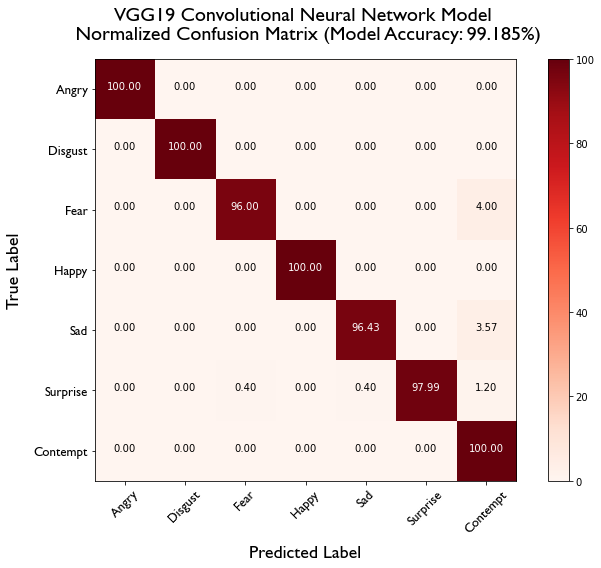

In [13]:
# Plot normalized confusion matrix
print('===> Creating VGG19 Confusion Matrix')
plt.figure(figsize=(10, 8))
plot_confusion_matrix(vgg_matrix, cmap = plt.cm.Reds, normalize=True,
                      title= 'VGG19 Convolutional Neural Network Model \n Normalized Confusion Matrix (Model Accuracy: %0.3f%%)' % max(vgg_best_test_acc))

plt.savefig('../model_visualizations/vgg19_model_confusion_matrix.png')
plt.show()


===> Creating ResNet18 Confusion Matrix


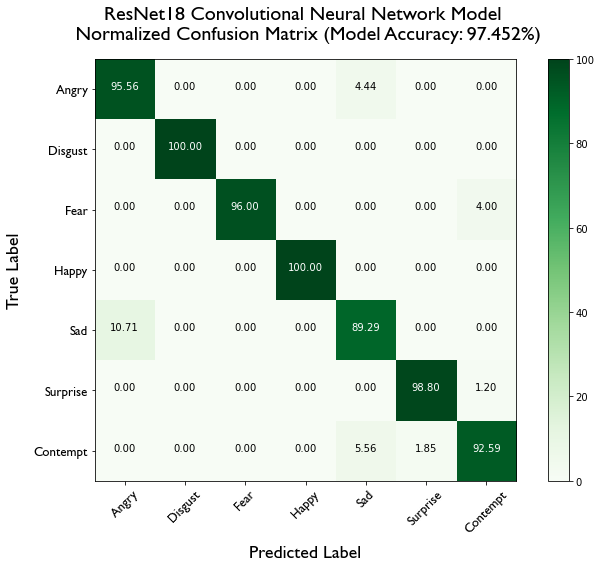

In [14]:
# Plot normalized confusion matrix
print('===> Creating ResNet18 Confusion Matrix')
plt.figure(figsize=(10, 8))
plot_confusion_matrix(res_matrix, cmap = plt.cm.Greens, normalize=True,
                      title= 'ResNet18 Convolutional Neural Network Model \n Normalized Confusion Matrix (Model Accuracy: %0.3f%%)' % max(res_best_test_acc))

plt.savefig('../model_visualizations/resnet18_model_confusion_matrix.png')
plt.show()


## Loss Model Plots

===> Creating Loss Plot


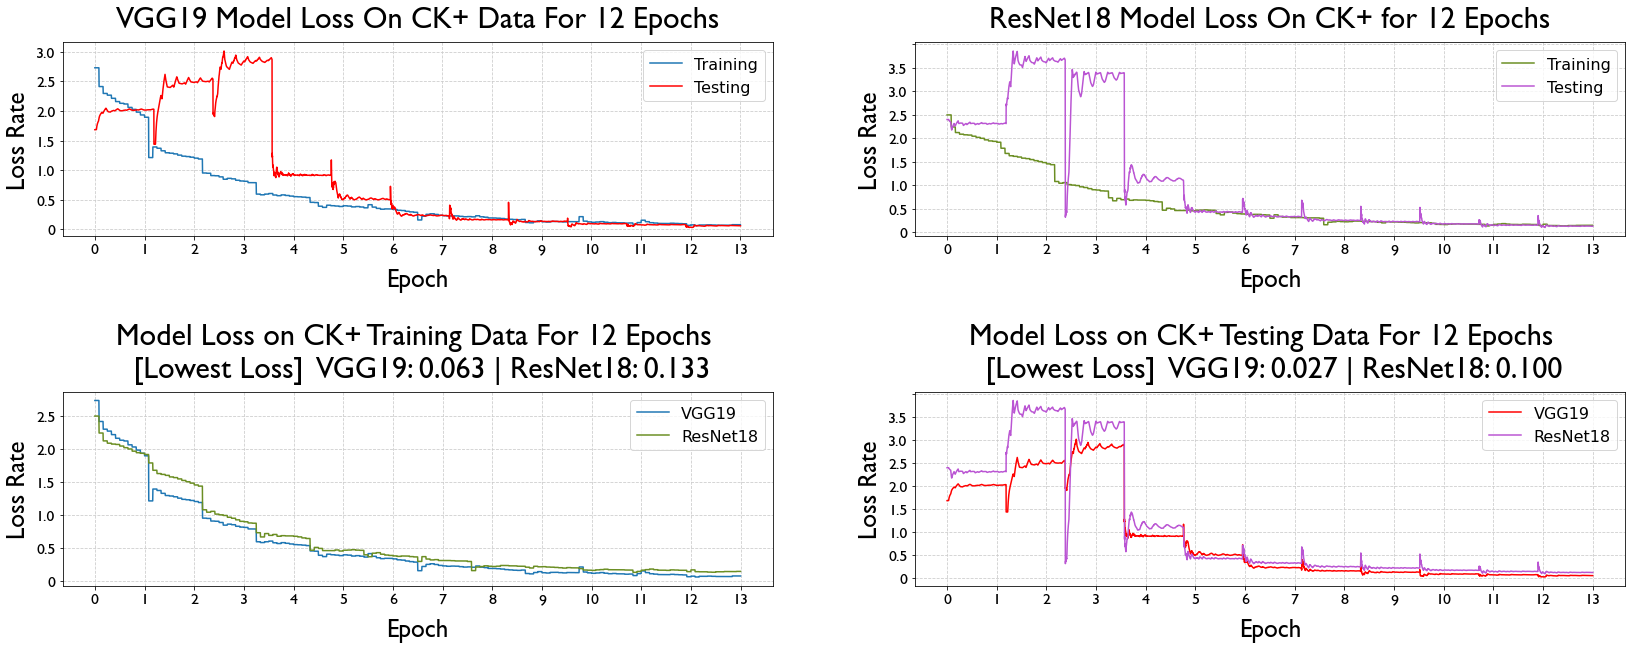

In [15]:
print('===> Creating Loss Plot')
fig, ax = plt.subplots(2, 2, figsize = (28, 10))
fig.subplots_adjust(left = None, bottom = None, right = None, top = None, wspace = None, hspace = 0.8)



#first plot
tral_vgg, = ax[0, 0].plot( train_loss_list_vgg)

tst_vgg_tr, = ax[0, 0].plot(test_loss_list_vgg[:6709], c = 'red' )


ax[0, 0].xaxis.set_major_locator(MultipleLocator(516))
ax[0, 0].yaxis.set_major_locator(MultipleLocator(0.5))
ax[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
ax[0, 0].set_xticklabels([0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], fontsize = 16)
ax[0, 0].set_yticklabels([ '-0.5','0', '0.5', '1.0', '1.5', '2.0', '2.5','3.0'],fontsize=16)

ax[0, 0].set_title('VGG19 Model Loss On CK+ Data For 12 Epochs', size = 30, pad = 15, fontname = 'Gill Sans MT')
ax[0, 0].legend([tral_vgg, tst_vgg_tr], ['Training',  'Testing'], prop={'size': 16} )
ax[0, 0].set_xlabel('Epoch', size = 25, labelpad = 12, fontname = 'Gill Sans MT')
ax[0, 0].set_ylabel('Loss Rate', size = 25, labelpad = 5, fontname = 'Gill Sans MT')


for tick in ax[0, 0].get_xticklabels():
    tick.set_fontname("Gill Sans MT")

for tick in ax[0, 0].get_yticklabels():
    tick.set_fontname("Gill Sans MT")
    
#second plot

tral_rn, = ax[0, 1].plot( train_loss_list_rn, c = 'olivedrab')

tst_rn_tr, = ax[0, 1].plot(test_loss_list_rn[:6709], c = 'mediumorchid')

ax[0, 1].xaxis.set_major_locator(MultipleLocator(516))
ax[0, 1].yaxis.set_major_locator(MultipleLocator(0.5))
ax[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
ax[0, 1].set_xticklabels([0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], fontsize = 16)
ax[0, 1].set_yticklabels([ '-0.5','0', '0.5', '1.0', '1.5', '2.0', '2.5','3.0', '3.5'],fontsize=16) 

ax[0, 1].set_title('ResNet18 Model Loss On CK+ for 12 Epochs', size = 30, pad = 15, fontname = 'Gill Sans MT')
ax[0, 1].legend([tral_rn, tst_rn_tr], ['Training', 'Testing'], prop={'size': 16} )
ax[0, 1].set_xlabel('Epoch', size = 25, labelpad = 12, fontname = 'Gill Sans MT')
ax[0, 1].set_ylabel('Loss Rate', size = 25, labelpad = 5, fontname = 'Gill Sans MT')


for tick in ax[0, 1].get_xticklabels():
    tick.set_fontname("Gill Sans MT")

for tick in ax[0, 1].get_yticklabels():
    tick.set_fontname("Gill Sans MT")

    
#third plot
tral_vgg, = ax[1, 0].plot( train_loss_list_vgg)
tral_rn, = ax[1, 0].plot( train_loss_list_rn, c = 'olivedrab')



ax[1, 0].xaxis.set_major_locator(MultipleLocator(516))
ax[1, 0].yaxis.set_major_locator(MultipleLocator(0.5))
ax[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
ax[1, 0].set_xticklabels([0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], fontsize = 16)
ax[1, 0].set_yticklabels([ '-0.5','0', '0.5', '1.0', '1.5', '2.0', '2.5','3.0'],fontsize=16)

ax[1, 0].set_title('Model Loss on CK+ Training Data For 12 Epochs \n [Lowest Loss]  VGG19: %0.3f | ResNet18: %0.3f' % ( min(train_loss_list_vgg),  min(train_loss_list_rn)), size = 30, pad = 15, fontname = 'Gill Sans MT')
ax[1, 0].legend([tral_vgg, tral_rn], ['VGG19',  'ResNet18'], prop={'size': 16} )
ax[1, 0].set_xlabel('Epoch', size = 25, labelpad = 12, fontname = 'Gill Sans MT')
ax[1, 0].set_ylabel('Loss Rate', size = 25, labelpad = 5, fontname = 'Gill Sans MT')


for tick in ax[1, 0].get_xticklabels():
    tick.set_fontname("Gill Sans MT")

for tick in ax[1, 0].get_yticklabels():
    tick.set_fontname("Gill Sans MT")
    
    
#fourth plot
vgg_test, = ax[1, 1].plot(test_loss_list_vgg[:6709], c = 'red' )
rn_test, =ax[1, 1].plot(test_loss_list_rn[:6709], c = 'mediumorchid')


ax[1, 1].xaxis.set_major_locator(MultipleLocator(516))
ax[1, 1].yaxis.set_major_locator(MultipleLocator(0.5))
ax[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')
ax[1, 1].set_yticklabels([ '-0.5','0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5'],fontsize=16)
ax[1, 1].set_xticklabels([ -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                     10, 11, 12, 13], fontsize = 16)

ax[1, 1].set_title('Model Loss on CK+ Testing Data For 12 Epochs  \n [Lowest Loss]  VGG19: %0.3f | ResNet18: %0.3f' % ( min(test_loss_list_vgg),  min(test_loss_list_rn)), size = 30, pad = 15, fontname = 'Gill Sans MT')
ax[1, 1].legend([vgg_test, rn_test], ['VGG19', 'ResNet18'], prop={'size': 16})

ax[1, 1].set_xlabel('Epoch', size = 25, labelpad = 12, fontname = 'Gill Sans MT')
ax[1, 1].set_ylabel('Loss Rate', size = 25, labelpad = 5, fontname = 'Gill Sans MT')

for tick in ax[1, 1].get_xticklabels():
    tick.set_fontname("Gill Sans MT")

for tick in ax[1, 1].get_yticklabels():
    tick.set_fontname("Gill Sans MT")
    
    
plt.savefig('../model_visualizations/model_loss_viz.png');


## Accuracy Model Plots

===> Creating Accuracy Plot


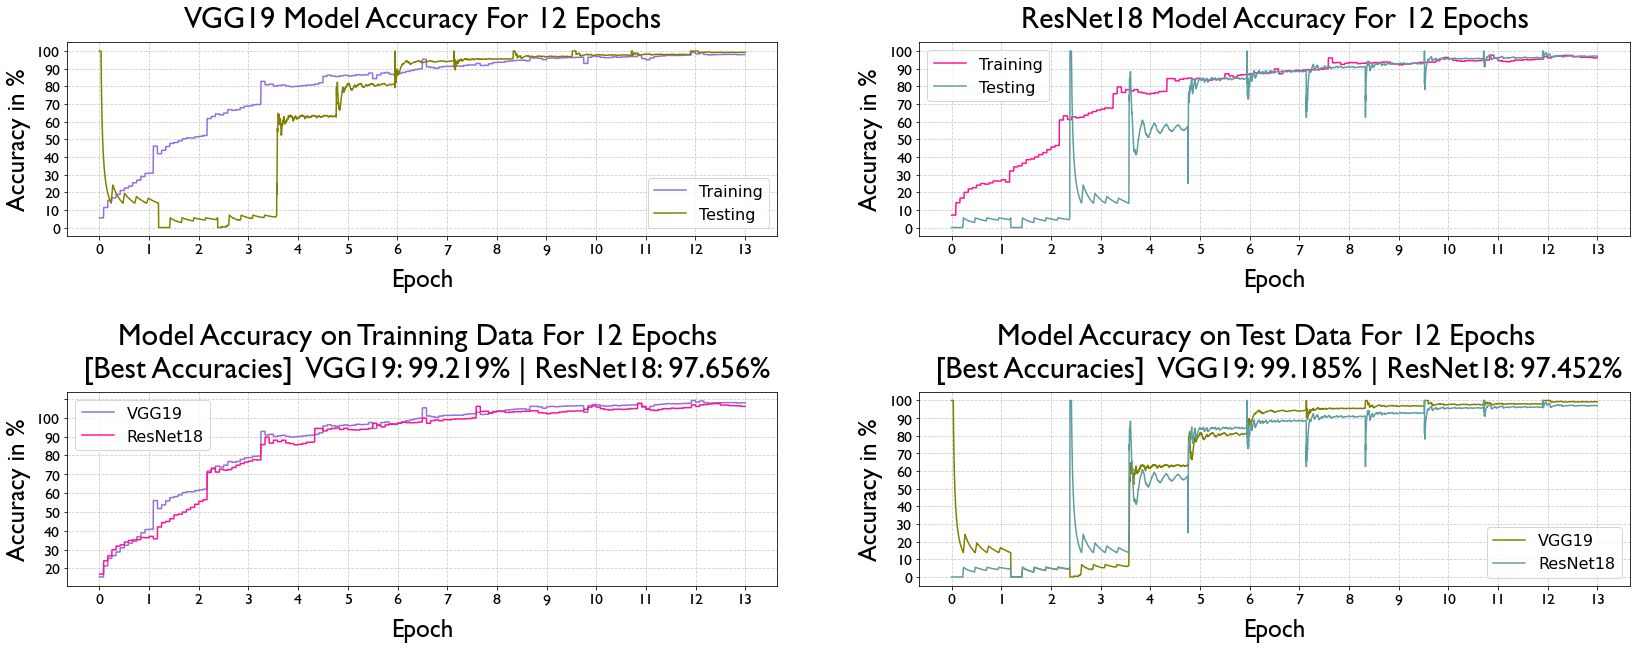

In [16]:
print('===> Creating Accuracy Plot')
fig, ax = plt.subplots(2, 2, figsize = (28, 10))
fig.subplots_adjust(left = None, bottom = None, right = None, top = None, wspace = None, hspace = 0.8)



#first plot
tral_vgg, = ax[0, 0].plot(train_acc_list_vgg, c = 'mediumpurple')

tst_vgg_tr, = ax[0, 0].plot(test_acc_list_vgg[:6709], c = 'olive' )


ax[0, 0].xaxis.set_major_locator(MultipleLocator(516))
ax[0, 0].yaxis.set_major_locator(MultipleLocator(10))
ax[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
ax[0, 0].set_xticklabels([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                     10, 11, 12, 13], fontsize = 16)
ax[0, 0].set_yticklabels(['-1' ,'0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'],fontsize=16)
ax[0, 0].set_title('VGG19 Model Accuracy For 12 Epochs', size = 30, pad = 15, fontname = 'Gill Sans MT')
ax[0, 0].legend([tral_vgg, tst_vgg_tr], ['Training','Testing'], prop={'size': 16} )
ax[0, 0].set_xlabel('Epoch', size = 25, labelpad = 12, fontname = 'Gill Sans MT')
ax[0, 0].set_ylabel('Accuracy in %', size = 25, labelpad = 5, fontname = 'Gill Sans MT')


for tick in ax[0, 0].get_xticklabels():
    tick.set_fontname("Gill Sans MT")

for tick in ax[0, 0].get_yticklabels():
    tick.set_fontname("Gill Sans MT")
    
#second plot

tral_rn, = ax[0, 1].plot( train_acc_list_rn, c = 'deeppink')

tst_rn_tr, = ax[0, 1].plot(test_acc_list_rn[:6709], c = 'cadetblue')

ax[0, 1].xaxis.set_major_locator(MultipleLocator(516))
ax[0, 1].yaxis.set_major_locator(MultipleLocator(10))
ax[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
ax[0, 1].set_xticklabels([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                     10, 11, 12, 13], fontsize = 16)
ax[0, 1].set_yticklabels(['-1' ,'0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'],fontsize=16)
ax[0, 1].set_title('ResNet18 Model Accuracy For 12 Epochs', size = 30, pad = 15, fontname = 'Gill Sans MT')
ax[0, 1].legend([tral_rn, tst_rn_tr], ['Training','Testing'], prop={'size': 16} )
ax[0, 1].set_xlabel('Epoch', size = 25, labelpad = 12, fontname = 'Gill Sans MT')
ax[0, 1].set_ylabel('Accuracy in %', size = 25, labelpad = 5, fontname = 'Gill Sans MT')


for tick in ax[0, 1].get_xticklabels():
    tick.set_fontname("Gill Sans MT")

for tick in ax[0, 1].get_yticklabels():
    tick.set_fontname("Gill Sans MT")

# third plot 
tral_vgg, = ax[1, 0].plot(train_acc_list_vgg, c = 'mediumpurple')

tral_rn, = ax[1, 0].plot( train_acc_list_rn, c = 'deeppink')


ax[1, 0].xaxis.set_major_locator(MultipleLocator(516))
ax[1, 0].yaxis.set_major_locator(MultipleLocator(10))
ax[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
ax[1, 0].set_xticklabels([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                     10, 11, 12, 13], fontsize = 16)
ax[1, 0].set_yticklabels([ '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'],fontsize=16)
ax[1, 0].set_title('Model Accuracy on Trainning Data For 12 Epochs \n [Best Accuracies]  VGG19: %0.3f%% | ResNet18: %0.3f%%' % ( max(train_acc_list_vgg),  max(train_acc_list_rn)), size = 30, pad = 15, fontname = 'Gill Sans MT')
ax[1, 0].legend([tral_vgg, tral_rn], ['VGG19', 'ResNet18'], prop={'size': 16} )
ax[1, 0].set_xlabel('Epoch', size = 25, labelpad = 12, fontname = 'Gill Sans MT')
ax[1, 0].set_ylabel('Accuracy in %', size = 25, labelpad = 5, fontname = 'Gill Sans MT')


for tick in ax[1, 0].get_xticklabels():
    tick.set_fontname("Gill Sans MT")

for tick in ax[1, 0].get_yticklabels():
    tick.set_fontname("Gill Sans MT")
  

    
#fourth plot
vgg_test, = ax[1, 1].plot(test_acc_list_vgg[:6709], c = 'olive' )
rn_test, =ax[1, 1].plot(test_acc_list_rn[:6709], c = 'cadetblue')


ax[1, 1].xaxis.set_major_locator(MultipleLocator(516))
ax[1, 1].yaxis.set_major_locator(MultipleLocator(10))
ax[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')
ax[1, 1].set_yticklabels(['-1', '0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'],fontsize=16)
ax[1, 1].set_xticklabels([  -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                     10, 11, 12, 13], fontsize = 16)

ax[1, 1].set_title('Model Accuracy on Test Data For 12 Epochs  \n [Best Accuracies]  VGG19: %0.3f%% | ResNet18: %0.3f%%' % ( max(vgg_best_test_acc),  max(res_best_test_acc)), size = 30, pad = 15, fontname = 'Gill Sans MT')
ax[1, 1].legend([vgg_test, rn_test], ['VGG19', 'ResNet18'], prop={'size': 16})

ax[1, 1].set_xlabel('Epoch', size = 25, labelpad = 12, fontname = 'Gill Sans MT')
ax[1, 1].set_ylabel('Accuracy in %', size = 25, labelpad = 5, fontname = 'Gill Sans MT')

for tick in ax[1, 1].get_xticklabels():
    tick.set_fontname("Gill Sans MT")

for tick in ax[1, 1].get_yticklabels():
    tick.set_fontname("Gill Sans MT")
    
plt.savefig('../model_visualizations/model_accuracy_viz.png');
    

In [17]:
print('===> Done Running Model Executor')

===> Done Running Model Executor
